# Рекуррентные нейронные сети

In [1054]:
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Dropout,  SimpleRNN, SimpleRNNCell
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from xgboost import XGBRegressor

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

In [1055]:
!wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O airline-passengers.csv

/bin/bash: /home/ekaterina/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-09-27 17:40:30--  https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb
Распознаётся drive.google.com (drive.google.com)… 209.85.233.194, 2a00:1450:4010:c0d::c2
Подключение к drive.google.com (drive.google.com)|209.85.233.194|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 303 See Other
Адрес: https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g0a977cico94r1imgcvhaboe2r1v2cve/1695825600000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download&uuid=b844d735-f98a-4ab4-be5a-510f784eb92e [переход]
Предупреждение: в HTTP маски не поддерживаются.
--2023-09-27 17:40:31--  https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g0a977cico94r1imgcvhaboe2r1v2cve/1695825600000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=down

In [1056]:
df = pd.read_csv('airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [1057]:
df['month'] = df['Month'].apply(lambda row: int(row[-2:]))

In [1058]:
df['year'] = df['Month'].apply(lambda row: int(row[:4]))

In [1059]:
df

,Month,Passengers,month,year
0,1949-01,112,1,1949
1,1949-02,118,2,1949
2,1949-03,132,3,1949
3,1949-04,129,4,1949
4,1949-05,121,5,1949
...,...,...,...,...
139,1960-08,606,8,1960
140,1960-09,508,9,1960
141,1960-10,461,10,1960
142,1960-11,390,11,1960


In [1060]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
 2   month       144 non-null    int64 
 3   year        144 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 4.6+ KB


/home/ekaterina/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='month', ylabel='Passengers'>

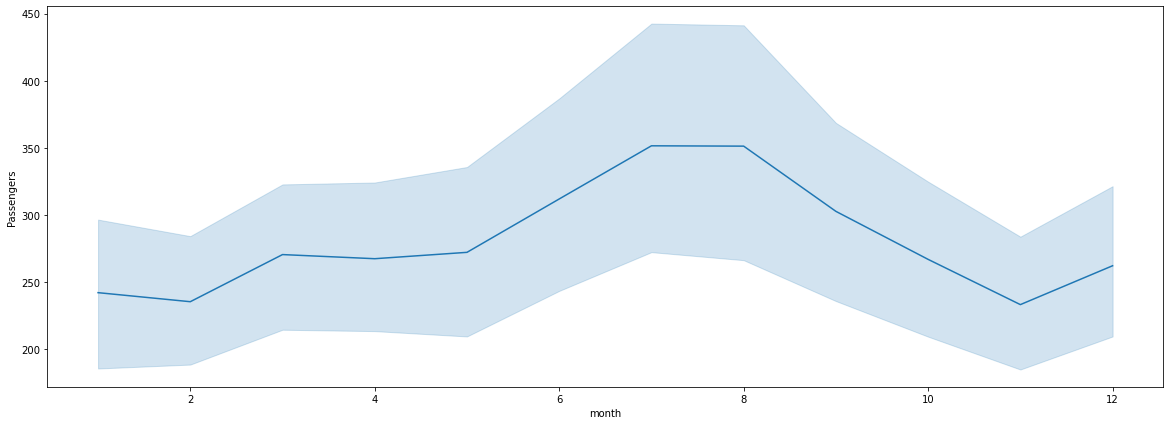

In [1061]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,7
sns.lineplot(df['month'], df['Passengers'])

/home/ekaterina/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year', ylabel='Passengers'>

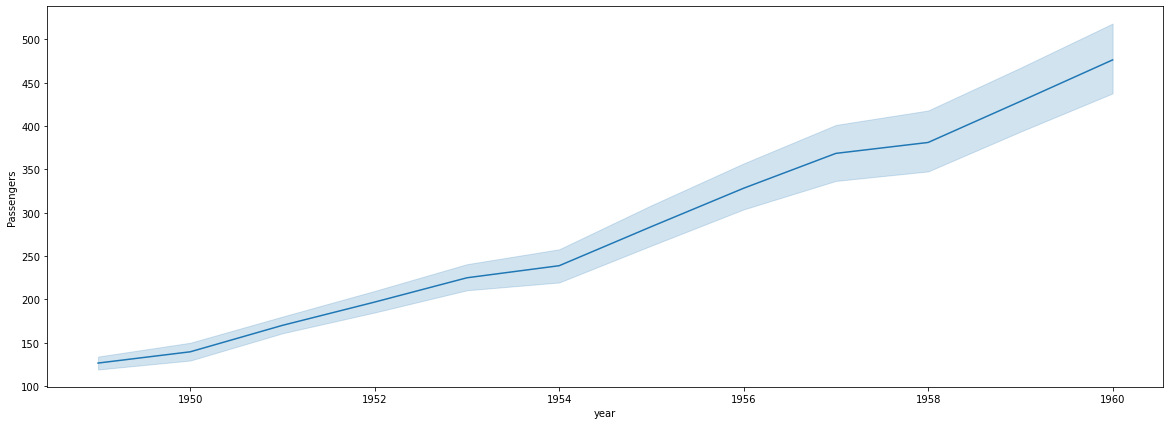

In [1062]:
sns.lineplot(df['year'], df['Passengers'])

Text(0.5, 1.0, 'График зависимости цены от площади')

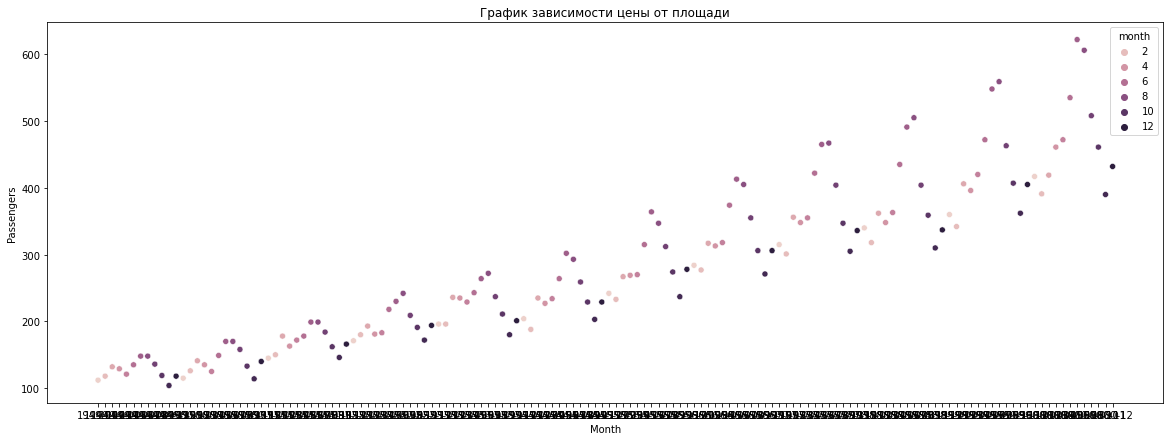

In [1063]:
sns.scatterplot(data = df, x = 'Month', y = 'Passengers', hue = 'month')
plt.title('График зависимости цены от площади')

In [1064]:
df['year'].unique()

array([1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960])

In [1065]:
x_len = 12 #анализируем 12 точек предыдущего периода, так как цикличность годовая
for i in range(1, x_len+1):
    df['Passengers'+str(i)+'month_back'] = df['Passengers'].shift(i, axis = 0)
    df['year'+str(i)+'month_back'] = df['year'].shift(i, axis = 0)
    df['month'+str(i)+'month_back'] = df['month'].shift(i, axis = 0)

In [1066]:
df.head(10)

,Month,Passengers,month,year,Passengers1month_back,year1month_back,month1month_back,Passengers2month_back,year2month_back,month2month_back,...,month9month_back,Passengers10month_back,year10month_back,month10month_back,Passengers11month_back,year11month_back,month11month_back,Passengers12month_back,year12month_back,month12month_back
0,1949-01,112,1,1949,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02,118,2,1949,112.0,1949.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-03,132,3,1949,118.0,1949.0,2.0,112.0,1949.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1949-04,129,4,1949,132.0,1949.0,3.0,118.0,1949.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1949-05,121,5,1949,129.0,1949.0,4.0,132.0,1949.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1949-06,135,6,1949,121.0,1949.0,5.0,129.0,1949.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1949-07,148,7,1949,135.0,1949.0,6.0,121.0,1949.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1949-08,148,8,1949,148.0,1949.0,7.0,135.0,1949.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1949-09,136,9,1949,148.0,1949.0,8.0,148.0,1949.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1949-10,119,10,1949,136.0,1949.0,9.0,148.0,1949.0,8.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1067]:
df_train = df.loc[df['year']<1960][x_len:]
df_train.shape

(120, 40)

In [1068]:
df_test = df.loc[df['year']>=1960]

df_test.shape

(12, 40)

In [1069]:
X_train = df_train[['month', 'year', 'Passengers1month_back',
       'year1month_back', 'month1month_back', 'Passengers2month_back',
       'year2month_back', 'month2month_back', 'Passengers3month_back',
       'year3month_back', 'month3month_back', 'Passengers4month_back',
       'year4month_back', 'month4month_back', 'Passengers5month_back',
       'year5month_back', 'month5month_back', 'Passengers6month_back',
       'year6month_back', 'month6month_back', 'Passengers7month_back',
       'year7month_back', 'month7month_back']]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled.shape

(120, 23)

In [1070]:
X_train_scaled

array([[0.        , 0.        , 0.00898876, ..., 0.07730673, 0.        ,
        0.45454545],
       [0.09090909, 0.        , 0.00224719, ..., 0.10972569, 0.        ,
        0.54545455],
       [0.18181818, 0.        , 0.02696629, ..., 0.10972569, 0.        ,
        0.63636364],
       ...,
       [0.81818182, 1.        , 0.78426966, ..., 0.75311721, 1.        ,
        0.18181818],
       [0.90909091, 1.        , 0.65842697, ..., 0.72817955, 1.        ,
        0.27272727],
       [1.        , 1.        , 0.55730337, ..., 0.78802993, 1.        ,
        0.36363636]])

In [1071]:
y_train = np.array(df_train['Passengers'])

In [1072]:
y_train.shape

(120,)

In [1073]:
y_train

array([115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145,
       150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180,
       193, 181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236,
       235, 229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227,
       234, 264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270,
       315, 364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374,
       413, 405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465,
       467, 404, 347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505,
       404, 359, 310, 337, 360, 342, 406, 396, 420, 472, 548, 559, 463,
       407, 362, 405])

In [1074]:
X_test = df_test[['month', 'year', 'Passengers1month_back',
       'year1month_back', 'month1month_back', 'Passengers2month_back',
       'year2month_back', 'month2month_back', 'Passengers3month_back',
       'year3month_back', 'month3month_back', 'Passengers4month_back',
       'year4month_back', 'month4month_back', 'Passengers5month_back',
       'year5month_back', 'month5month_back', 'Passengers6month_back',
       'year6month_back', 'month6month_back', 'Passengers7month_back',
       'year7month_back', 'month7month_back']]
X_test_scaled = scaler.transform(X_test)
X_test_scaled.shape

(12, 23)

In [1075]:
y_test = np.array(df_test['Passengers'])

In [1076]:
y_test

array([417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432])

# Посмотрим, как с этой задачей справляется XGboost

In [1077]:
XGBreg = XGBRegressor(n_estimators = 1000, random_state=21)

XGBreg.fit(X_train, y_train)

y_train_pred = XGBreg.predict(X_train)
y_test_pred = XGBreg.predict(X_test)

r2_score(y_test, y_test_pred)

0.6977566982397405

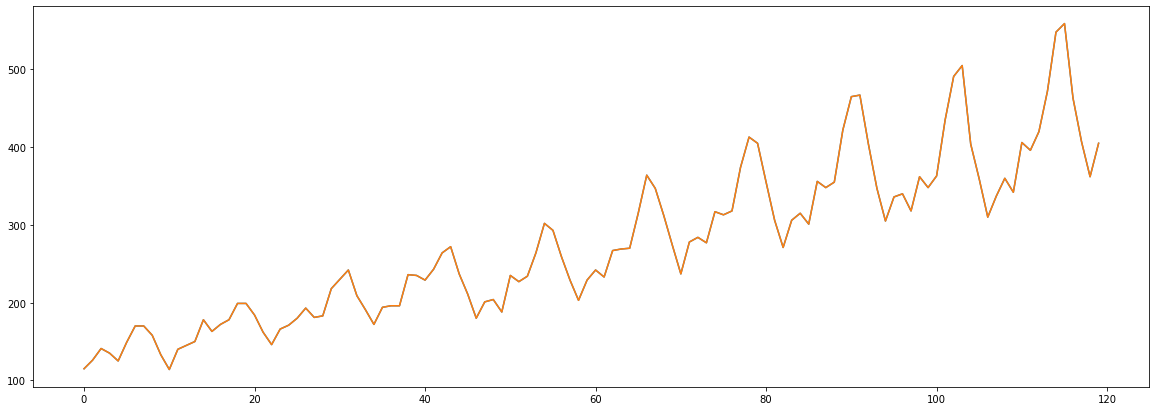

In [1078]:
plt.plot(np.array(y_train))
plt.plot(y_train_pred)

На трейне модель XGboostRegressor очень хорошо обучилась

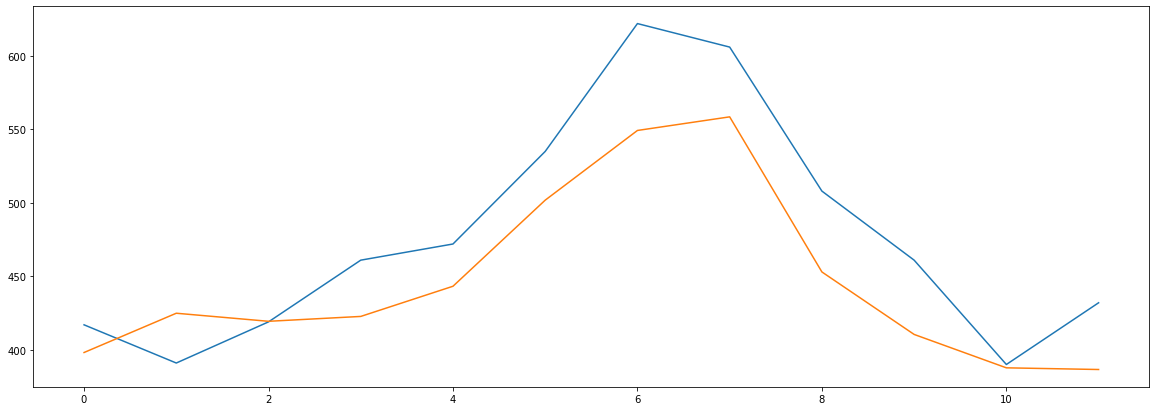

In [1079]:
plt.plot(np.array(y_test))
plt.plot(y_test_pred)

На тесте модель XGboostRegressor уловила тренд, неплохо работает, но требуются дополнительные настройки параметров

# Полносвязная сеть

In [1090]:
tf.random.set_seed(1)
inputs = Input(shape=(23))
hidden_layer_1 = Dense(128, activation='linear')(inputs) #linear работает лучше для данной сети, чем elu
outputs = Dense(1)(hidden_layer_1)

model = Model(inputs, outputs)

model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])

history = model.fit(X_train, 
                    y_train, 
                    epochs=5000,
                    batch_size = 1,
                    validation_split=0.1, 
                    verbose=2)


y_test_pred = model.predict(X_test)
test_mse, test_mae = model.evaluate(X_test, y_test, verbose=2)

test_r2 = r2_score(y_test, y_test_pred)

print 
(f'test_mse: {round(test_mse, 2)}, test_mae: {round(test_mae,2)}, test_r2: {round(test_r2,4)}')

Epoch 1/5000
108/108 - 0s - loss: 37901.3438 - mse: 37901.3438 - val_loss: 46204.6211 - val_mse: 46204.6211 - 327ms/epoch - 3ms/step
Epoch 2/5000
108/108 - 0s - loss: 27818.6797 - mse: 27818.6797 - val_loss: 145311.8906 - val_mse: 145311.8906 - 78ms/epoch - 718us/step
Epoch 3/5000
108/108 - 0s - loss: 26447.4922 - mse: 26447.4922 - val_loss: 6909.4731 - val_mse: 6909.4731 - 78ms/epoch - 723us/step
Epoch 4/5000
108/108 - 0s - loss: 21514.1133 - mse: 21514.1133 - val_loss: 22238.1172 - val_mse: 22238.1172 - 73ms/epoch - 676us/step
Epoch 5/5000
108/108 - 0s - loss: 23623.8477 - mse: 23623.8477 - val_loss: 77775.4609 - val_mse: 77775.4609 - 79ms/epoch - 728us/step
Epoch 6/5000
108/108 - 0s - loss: 20135.1914 - mse: 20135.1914 - val_loss: 6024.0923 - val_mse: 6024.0923 - 75ms/epoch - 697us/step
Epoch 7/5000
108/108 - 0s - loss: 23383.4004 - mse: 23383.4004 - val_loss: 31910.0391 - val_mse: 31910.0391 - 80ms/epoch - 744us/step
Epoch 8/5000
108/108 - 0s - loss: 17793.0332 - mse: 17793.0332 - 

108/108 - 0s - loss: 2867.3906 - mse: 2867.3906 - val_loss: 2618.5544 - val_mse: 2618.5544 - 74ms/epoch - 682us/step
Epoch 64/5000
108/108 - 0s - loss: 3052.7104 - mse: 3052.7104 - val_loss: 11869.3135 - val_mse: 11869.3135 - 73ms/epoch - 675us/step
Epoch 65/5000
108/108 - 0s - loss: 2509.2827 - mse: 2509.2827 - val_loss: 2414.2261 - val_mse: 2414.2261 - 70ms/epoch - 652us/step
Epoch 66/5000
108/108 - 0s - loss: 2777.3560 - mse: 2777.3560 - val_loss: 2466.1021 - val_mse: 2466.1021 - 75ms/epoch - 695us/step
Epoch 67/5000
108/108 - 0s - loss: 2742.9595 - mse: 2742.9595 - val_loss: 3761.3311 - val_mse: 3761.3311 - 73ms/epoch - 679us/step
Epoch 68/5000
108/108 - 0s - loss: 2790.4644 - mse: 2790.4644 - val_loss: 2417.3210 - val_mse: 2417.3210 - 72ms/epoch - 662us/step
Epoch 69/5000
108/108 - 0s - loss: 2935.3735 - mse: 2935.3735 - val_loss: 3482.3389 - val_mse: 3482.3389 - 73ms/epoch - 676us/step
Epoch 70/5000
108/108 - 0s - loss: 2562.9529 - mse: 2562.9529 - val_loss: 9803.8125 - val_mse: 

Epoch 126/5000
108/108 - 0s - loss: 1372.4580 - mse: 1372.4580 - val_loss: 5063.0293 - val_mse: 5063.0293 - 85ms/epoch - 788us/step
Epoch 127/5000
108/108 - 0s - loss: 1183.0846 - mse: 1183.0846 - val_loss: 3973.0537 - val_mse: 3973.0537 - 73ms/epoch - 680us/step
Epoch 128/5000
108/108 - 0s - loss: 1327.8375 - mse: 1327.8375 - val_loss: 2052.5315 - val_mse: 2052.5315 - 73ms/epoch - 676us/step
Epoch 129/5000
108/108 - 0s - loss: 1201.6327 - mse: 1201.6327 - val_loss: 2191.7317 - val_mse: 2191.7317 - 73ms/epoch - 676us/step
Epoch 130/5000
108/108 - 0s - loss: 1214.7069 - mse: 1214.7069 - val_loss: 2439.0554 - val_mse: 2439.0554 - 69ms/epoch - 640us/step
Epoch 131/5000
108/108 - 0s - loss: 1312.6671 - mse: 1312.6671 - val_loss: 4571.4204 - val_mse: 4571.4204 - 71ms/epoch - 661us/step
Epoch 132/5000
108/108 - 0s - loss: 1107.8519 - mse: 1107.8519 - val_loss: 2063.6882 - val_mse: 2063.6882 - 73ms/epoch - 679us/step
Epoch 133/5000
108/108 - 0s - loss: 1182.1733 - mse: 1182.1733 - val_loss: 4

Epoch 189/5000
108/108 - 0s - loss: 955.8708 - mse: 955.8708 - val_loss: 1673.6738 - val_mse: 1673.6738 - 74ms/epoch - 681us/step
Epoch 190/5000
108/108 - 0s - loss: 940.6812 - mse: 940.6812 - val_loss: 1909.4261 - val_mse: 1909.4261 - 72ms/epoch - 669us/step
Epoch 191/5000
108/108 - 0s - loss: 909.5911 - mse: 909.5911 - val_loss: 3419.4573 - val_mse: 3419.4573 - 75ms/epoch - 692us/step
Epoch 192/5000
108/108 - 0s - loss: 947.1469 - mse: 947.1469 - val_loss: 1591.5900 - val_mse: 1591.5900 - 75ms/epoch - 694us/step
Epoch 193/5000
108/108 - 0s - loss: 930.6304 - mse: 930.6304 - val_loss: 2018.5449 - val_mse: 2018.5449 - 73ms/epoch - 677us/step
Epoch 194/5000
108/108 - 0s - loss: 928.1448 - mse: 928.1448 - val_loss: 2122.2134 - val_mse: 2122.2134 - 71ms/epoch - 655us/step
Epoch 195/5000
108/108 - 0s - loss: 930.7919 - mse: 930.7919 - val_loss: 1951.7592 - val_mse: 1951.7592 - 73ms/epoch - 675us/step
Epoch 196/5000
108/108 - 0s - loss: 929.4357 - mse: 929.4357 - val_loss: 1647.0610 - val_m

108/108 - 0s - loss: 749.9833 - mse: 749.9833 - val_loss: 2967.1152 - val_mse: 2967.1152 - 73ms/epoch - 676us/step
Epoch 253/5000
108/108 - 0s - loss: 794.2025 - mse: 794.2025 - val_loss: 1851.1211 - val_mse: 1851.1211 - 74ms/epoch - 689us/step
Epoch 254/5000
108/108 - 0s - loss: 784.3951 - mse: 784.3951 - val_loss: 1415.6655 - val_mse: 1415.6655 - 72ms/epoch - 670us/step
Epoch 255/5000
108/108 - 0s - loss: 800.5507 - mse: 800.5507 - val_loss: 1530.2124 - val_mse: 1530.2124 - 73ms/epoch - 679us/step
Epoch 256/5000
108/108 - 0s - loss: 836.9732 - mse: 836.9732 - val_loss: 2266.6206 - val_mse: 2266.6206 - 73ms/epoch - 679us/step
Epoch 257/5000
108/108 - 0s - loss: 782.1360 - mse: 782.1360 - val_loss: 1595.8594 - val_mse: 1595.8594 - 78ms/epoch - 726us/step
Epoch 258/5000
108/108 - 0s - loss: 874.3032 - mse: 874.3032 - val_loss: 1456.3524 - val_mse: 1456.3524 - 71ms/epoch - 659us/step
Epoch 259/5000
108/108 - 0s - loss: 752.1996 - mse: 752.1996 - val_loss: 1417.7578 - val_mse: 1417.7578 -

Epoch 316/5000
108/108 - 0s - loss: 701.1573 - mse: 701.1573 - val_loss: 2145.8989 - val_mse: 2145.8989 - 69ms/epoch - 642us/step
Epoch 317/5000
108/108 - 0s - loss: 755.5876 - mse: 755.5876 - val_loss: 3215.1484 - val_mse: 3215.1484 - 70ms/epoch - 646us/step
Epoch 318/5000
108/108 - 0s - loss: 719.5208 - mse: 719.5208 - val_loss: 1279.7196 - val_mse: 1279.7196 - 71ms/epoch - 656us/step
Epoch 319/5000
108/108 - 0s - loss: 685.7855 - mse: 685.7855 - val_loss: 1606.0336 - val_mse: 1606.0336 - 74ms/epoch - 684us/step
Epoch 320/5000
108/108 - 0s - loss: 767.0864 - mse: 767.0864 - val_loss: 1577.6183 - val_mse: 1577.6183 - 73ms/epoch - 676us/step
Epoch 321/5000
108/108 - 0s - loss: 741.2969 - mse: 741.2969 - val_loss: 1410.1136 - val_mse: 1410.1136 - 73ms/epoch - 675us/step
Epoch 322/5000
108/108 - 0s - loss: 780.5493 - mse: 780.5493 - val_loss: 1722.3820 - val_mse: 1722.3820 - 74ms/epoch - 682us/step
Epoch 323/5000
108/108 - 0s - loss: 750.4677 - mse: 750.4677 - val_loss: 1339.9274 - val_m

108/108 - 0s - loss: 659.9258 - mse: 659.9258 - val_loss: 1558.0370 - val_mse: 1558.0370 - 73ms/epoch - 680us/step
Epoch 380/5000
108/108 - 0s - loss: 641.0211 - mse: 641.0211 - val_loss: 1350.2914 - val_mse: 1350.2914 - 74ms/epoch - 687us/step
Epoch 381/5000
108/108 - 0s - loss: 692.6147 - mse: 692.6147 - val_loss: 1795.2828 - val_mse: 1795.2828 - 72ms/epoch - 671us/step
Epoch 382/5000
108/108 - 0s - loss: 599.7073 - mse: 599.7073 - val_loss: 2431.2727 - val_mse: 2431.2727 - 72ms/epoch - 669us/step
Epoch 383/5000
108/108 - 0s - loss: 724.3172 - mse: 724.3172 - val_loss: 1336.2644 - val_mse: 1336.2644 - 76ms/epoch - 701us/step
Epoch 384/5000
108/108 - 0s - loss: 691.8152 - mse: 691.8152 - val_loss: 1378.8397 - val_mse: 1378.8397 - 74ms/epoch - 686us/step
Epoch 385/5000
108/108 - 0s - loss: 725.4481 - mse: 725.4481 - val_loss: 2990.5684 - val_mse: 2990.5684 - 73ms/epoch - 673us/step
Epoch 386/5000
108/108 - 0s - loss: 685.1970 - mse: 685.1970 - val_loss: 1994.0006 - val_mse: 1994.0006 -

Epoch 443/5000
108/108 - 0s - loss: 588.3305 - mse: 588.3305 - val_loss: 1269.6307 - val_mse: 1269.6307 - 71ms/epoch - 659us/step
Epoch 444/5000
108/108 - 0s - loss: 574.5607 - mse: 574.5607 - val_loss: 1151.4811 - val_mse: 1151.4811 - 73ms/epoch - 676us/step
Epoch 445/5000
108/108 - 0s - loss: 725.9273 - mse: 725.9273 - val_loss: 1258.0106 - val_mse: 1258.0106 - 72ms/epoch - 671us/step
Epoch 446/5000
108/108 - 0s - loss: 622.8665 - mse: 622.8665 - val_loss: 1216.8024 - val_mse: 1216.8024 - 75ms/epoch - 692us/step
Epoch 447/5000
108/108 - 0s - loss: 603.3312 - mse: 603.3312 - val_loss: 1214.3019 - val_mse: 1214.3019 - 73ms/epoch - 672us/step
Epoch 448/5000
108/108 - 0s - loss: 615.6263 - mse: 615.6263 - val_loss: 1833.3700 - val_mse: 1833.3700 - 69ms/epoch - 643us/step
Epoch 449/5000
108/108 - 0s - loss: 599.4138 - mse: 599.4138 - val_loss: 1599.7769 - val_mse: 1599.7769 - 73ms/epoch - 675us/step
Epoch 450/5000
108/108 - 0s - loss: 706.0696 - mse: 706.0696 - val_loss: 1276.7291 - val_m

108/108 - 0s - loss: 558.9953 - mse: 558.9953 - val_loss: 1413.2386 - val_mse: 1413.2386 - 72ms/epoch - 666us/step
Epoch 507/5000
108/108 - 0s - loss: 630.8362 - mse: 630.8362 - val_loss: 1074.1428 - val_mse: 1074.1428 - 74ms/epoch - 683us/step
Epoch 508/5000
108/108 - 0s - loss: 573.7740 - mse: 573.7740 - val_loss: 1023.3154 - val_mse: 1023.3154 - 74ms/epoch - 687us/step
Epoch 509/5000
108/108 - 0s - loss: 583.5143 - mse: 583.5143 - val_loss: 1652.4955 - val_mse: 1652.4955 - 70ms/epoch - 652us/step
Epoch 510/5000
108/108 - 0s - loss: 577.8472 - mse: 577.8472 - val_loss: 4632.7402 - val_mse: 4632.7402 - 74ms/epoch - 686us/step
Epoch 511/5000
108/108 - 0s - loss: 650.4612 - mse: 650.4612 - val_loss: 1094.2278 - val_mse: 1094.2278 - 74ms/epoch - 683us/step
Epoch 512/5000
108/108 - 0s - loss: 670.3840 - mse: 670.3840 - val_loss: 1359.8174 - val_mse: 1359.8174 - 71ms/epoch - 656us/step
Epoch 513/5000
108/108 - 0s - loss: 626.6754 - mse: 626.6754 - val_loss: 2042.3146 - val_mse: 2042.3146 -

Epoch 570/5000
108/108 - 0s - loss: 572.4596 - mse: 572.4596 - val_loss: 2426.0784 - val_mse: 2426.0784 - 77ms/epoch - 709us/step
Epoch 571/5000
108/108 - 0s - loss: 636.1072 - mse: 636.1072 - val_loss: 1009.1924 - val_mse: 1009.1924 - 76ms/epoch - 705us/step
Epoch 572/5000
108/108 - 0s - loss: 616.7075 - mse: 616.7075 - val_loss: 1401.1932 - val_mse: 1401.1932 - 88ms/epoch - 816us/step
Epoch 573/5000
108/108 - 0s - loss: 573.1283 - mse: 573.1283 - val_loss: 1452.8510 - val_mse: 1452.8510 - 78ms/epoch - 719us/step
Epoch 574/5000
108/108 - 0s - loss: 647.7544 - mse: 647.7544 - val_loss: 1193.5912 - val_mse: 1193.5912 - 93ms/epoch - 859us/step
Epoch 575/5000
108/108 - 0s - loss: 525.3328 - mse: 525.3328 - val_loss: 1297.8423 - val_mse: 1297.8423 - 83ms/epoch - 769us/step
Epoch 576/5000
108/108 - 0s - loss: 618.5349 - mse: 618.5349 - val_loss: 1336.6439 - val_mse: 1336.6439 - 71ms/epoch - 657us/step
Epoch 577/5000
108/108 - 0s - loss: 626.5922 - mse: 626.5922 - val_loss: 1787.5616 - val_m

108/108 - 0s - loss: 577.3562 - mse: 577.3562 - val_loss: 1639.2020 - val_mse: 1639.2020 - 74ms/epoch - 681us/step
Epoch 634/5000
108/108 - 0s - loss: 587.0173 - mse: 587.0173 - val_loss: 1809.3457 - val_mse: 1809.3457 - 75ms/epoch - 698us/step
Epoch 635/5000
108/108 - 0s - loss: 589.7845 - mse: 589.7845 - val_loss: 1467.5431 - val_mse: 1467.5431 - 73ms/epoch - 675us/step
Epoch 636/5000
108/108 - 0s - loss: 563.7225 - mse: 563.7225 - val_loss: 1908.4589 - val_mse: 1908.4589 - 71ms/epoch - 661us/step
Epoch 637/5000
108/108 - 0s - loss: 532.1996 - mse: 532.1996 - val_loss: 1034.1636 - val_mse: 1034.1636 - 72ms/epoch - 666us/step
Epoch 638/5000
108/108 - 0s - loss: 527.1743 - mse: 527.1743 - val_loss: 1261.3467 - val_mse: 1261.3467 - 72ms/epoch - 663us/step
Epoch 639/5000
108/108 - 0s - loss: 568.3962 - mse: 568.3962 - val_loss: 1163.4241 - val_mse: 1163.4241 - 72ms/epoch - 669us/step
Epoch 640/5000
108/108 - 0s - loss: 529.6991 - mse: 529.6991 - val_loss: 1673.3153 - val_mse: 1673.3153 -

Epoch 697/5000
108/108 - 0s - loss: 590.9761 - mse: 590.9761 - val_loss: 1199.6056 - val_mse: 1199.6056 - 71ms/epoch - 660us/step
Epoch 698/5000
108/108 - 0s - loss: 584.6278 - mse: 584.6278 - val_loss: 1438.8330 - val_mse: 1438.8330 - 72ms/epoch - 668us/step
Epoch 699/5000
108/108 - 0s - loss: 538.1644 - mse: 538.1644 - val_loss: 2567.0920 - val_mse: 2567.0920 - 73ms/epoch - 676us/step
Epoch 700/5000
108/108 - 0s - loss: 548.9560 - mse: 548.9560 - val_loss: 1481.5072 - val_mse: 1481.5072 - 75ms/epoch - 693us/step
Epoch 701/5000
108/108 - 0s - loss: 570.7007 - mse: 570.7007 - val_loss: 1406.3271 - val_mse: 1406.3271 - 83ms/epoch - 771us/step
Epoch 702/5000
108/108 - 0s - loss: 536.9611 - mse: 536.9611 - val_loss: 1115.0385 - val_mse: 1115.0385 - 78ms/epoch - 720us/step
Epoch 703/5000
108/108 - 0s - loss: 556.2983 - mse: 556.2983 - val_loss: 1235.8285 - val_mse: 1235.8285 - 72ms/epoch - 662us/step
Epoch 704/5000
108/108 - 0s - loss: 529.8021 - mse: 529.8021 - val_loss: 2133.0505 - val_m

108/108 - 0s - loss: 495.8248 - mse: 495.8248 - val_loss: 2143.9033 - val_mse: 2143.9033 - 83ms/epoch - 764us/step
Epoch 761/5000
108/108 - 0s - loss: 459.5163 - mse: 459.5163 - val_loss: 1066.8051 - val_mse: 1066.8051 - 88ms/epoch - 814us/step
Epoch 762/5000
108/108 - 0s - loss: 573.1530 - mse: 573.1530 - val_loss: 1433.3319 - val_mse: 1433.3319 - 89ms/epoch - 829us/step
Epoch 763/5000
108/108 - 0s - loss: 497.0302 - mse: 497.0302 - val_loss: 1253.6813 - val_mse: 1253.6813 - 85ms/epoch - 785us/step
Epoch 764/5000
108/108 - 0s - loss: 489.7223 - mse: 489.7223 - val_loss: 2032.2500 - val_mse: 2032.2500 - 85ms/epoch - 786us/step
Epoch 765/5000
108/108 - 0s - loss: 549.8713 - mse: 549.8713 - val_loss: 1396.3873 - val_mse: 1396.3873 - 83ms/epoch - 770us/step
Epoch 766/5000
108/108 - 0s - loss: 574.9146 - mse: 574.9146 - val_loss: 1062.2578 - val_mse: 1062.2578 - 82ms/epoch - 757us/step
Epoch 767/5000
108/108 - 0s - loss: 510.6013 - mse: 510.6013 - val_loss: 2155.9822 - val_mse: 2155.9822 -

Epoch 824/5000
108/108 - 0s - loss: 552.1037 - mse: 552.1037 - val_loss: 1787.0077 - val_mse: 1787.0077 - 82ms/epoch - 755us/step
Epoch 825/5000
108/108 - 0s - loss: 544.9220 - mse: 544.9220 - val_loss: 1301.9305 - val_mse: 1301.9305 - 84ms/epoch - 778us/step
Epoch 826/5000
108/108 - 0s - loss: 565.0694 - mse: 565.0694 - val_loss: 1378.4847 - val_mse: 1378.4847 - 83ms/epoch - 768us/step
Epoch 827/5000
108/108 - 0s - loss: 459.6916 - mse: 459.6916 - val_loss: 3237.0613 - val_mse: 3237.0613 - 80ms/epoch - 745us/step
Epoch 828/5000
108/108 - 0s - loss: 529.3630 - mse: 529.3630 - val_loss: 1401.0209 - val_mse: 1401.0209 - 84ms/epoch - 779us/step
Epoch 829/5000
108/108 - 0s - loss: 480.3525 - mse: 480.3525 - val_loss: 1458.8129 - val_mse: 1458.8129 - 81ms/epoch - 746us/step
Epoch 830/5000
108/108 - 0s - loss: 505.9918 - mse: 505.9918 - val_loss: 1379.7046 - val_mse: 1379.7046 - 82ms/epoch - 763us/step
Epoch 831/5000
108/108 - 0s - loss: 524.8219 - mse: 524.8219 - val_loss: 1468.2836 - val_m

108/108 - 0s - loss: 552.2780 - mse: 552.2780 - val_loss: 1217.6718 - val_mse: 1217.6718 - 82ms/epoch - 759us/step
Epoch 888/5000
108/108 - 0s - loss: 512.5237 - mse: 512.5237 - val_loss: 1204.3276 - val_mse: 1204.3276 - 82ms/epoch - 757us/step
Epoch 889/5000
108/108 - 0s - loss: 494.4164 - mse: 494.4164 - val_loss: 1087.2139 - val_mse: 1087.2139 - 77ms/epoch - 715us/step
Epoch 890/5000
108/108 - 0s - loss: 521.2539 - mse: 521.2539 - val_loss: 1151.5314 - val_mse: 1151.5314 - 89ms/epoch - 820us/step
Epoch 891/5000
108/108 - 0s - loss: 490.2436 - mse: 490.2436 - val_loss: 1326.0560 - val_mse: 1326.0560 - 87ms/epoch - 805us/step
Epoch 892/5000
108/108 - 0s - loss: 528.3979 - mse: 528.3979 - val_loss: 992.6138 - val_mse: 992.6138 - 84ms/epoch - 776us/step
Epoch 893/5000
108/108 - 0s - loss: 465.1545 - mse: 465.1545 - val_loss: 1713.3223 - val_mse: 1713.3223 - 83ms/epoch - 771us/step
Epoch 894/5000
108/108 - 0s - loss: 572.2534 - mse: 572.2534 - val_loss: 1205.4414 - val_mse: 1205.4414 - 8

Epoch 951/5000
108/108 - 0s - loss: 423.6675 - mse: 423.6675 - val_loss: 2974.3975 - val_mse: 2974.3975 - 84ms/epoch - 775us/step
Epoch 952/5000
108/108 - 0s - loss: 481.5914 - mse: 481.5914 - val_loss: 2246.5476 - val_mse: 2246.5476 - 81ms/epoch - 746us/step
Epoch 953/5000
108/108 - 0s - loss: 500.8167 - mse: 500.8167 - val_loss: 1152.9745 - val_mse: 1152.9745 - 81ms/epoch - 754us/step
Epoch 954/5000
108/108 - 0s - loss: 509.6619 - mse: 509.6619 - val_loss: 1740.6401 - val_mse: 1740.6401 - 80ms/epoch - 737us/step
Epoch 955/5000
108/108 - 0s - loss: 499.0801 - mse: 499.0801 - val_loss: 1152.5099 - val_mse: 1152.5099 - 95ms/epoch - 883us/step
Epoch 956/5000
108/108 - 0s - loss: 495.5339 - mse: 495.5339 - val_loss: 1075.5193 - val_mse: 1075.5193 - 94ms/epoch - 869us/step
Epoch 957/5000
108/108 - 0s - loss: 445.6865 - mse: 445.6865 - val_loss: 1132.0061 - val_mse: 1132.0061 - 87ms/epoch - 801us/step
Epoch 958/5000
108/108 - 0s - loss: 483.7799 - mse: 483.7799 - val_loss: 2027.3986 - val_m

Epoch 1014/5000
108/108 - 0s - loss: 493.0487 - mse: 493.0487 - val_loss: 1838.0358 - val_mse: 1838.0358 - 81ms/epoch - 749us/step
Epoch 1015/5000
108/108 - 0s - loss: 490.6169 - mse: 490.6169 - val_loss: 1552.3978 - val_mse: 1552.3978 - 90ms/epoch - 837us/step
Epoch 1016/5000
108/108 - 0s - loss: 489.3124 - mse: 489.3124 - val_loss: 1281.1241 - val_mse: 1281.1241 - 84ms/epoch - 777us/step
Epoch 1017/5000
108/108 - 0s - loss: 496.7375 - mse: 496.7375 - val_loss: 2331.0090 - val_mse: 2331.0090 - 85ms/epoch - 784us/step
Epoch 1018/5000
108/108 - 0s - loss: 456.1954 - mse: 456.1954 - val_loss: 1386.7583 - val_mse: 1386.7583 - 85ms/epoch - 783us/step
Epoch 1019/5000
108/108 - 0s - loss: 515.6801 - mse: 515.6801 - val_loss: 1123.0383 - val_mse: 1123.0383 - 83ms/epoch - 773us/step
Epoch 1020/5000
108/108 - 0s - loss: 507.4986 - mse: 507.4986 - val_loss: 1471.6837 - val_mse: 1471.6837 - 81ms/epoch - 746us/step
Epoch 1021/5000
108/108 - 0s - loss: 474.8941 - mse: 474.8941 - val_loss: 1095.2211

Epoch 1077/5000
108/108 - 0s - loss: 500.1382 - mse: 500.1382 - val_loss: 1265.7130 - val_mse: 1265.7130 - 82ms/epoch - 758us/step
Epoch 1078/5000
108/108 - 0s - loss: 426.1351 - mse: 426.1351 - val_loss: 1398.3160 - val_mse: 1398.3160 - 81ms/epoch - 749us/step
Epoch 1079/5000
108/108 - 0s - loss: 487.0920 - mse: 487.0920 - val_loss: 1594.9023 - val_mse: 1594.9023 - 83ms/epoch - 765us/step
Epoch 1080/5000
108/108 - 0s - loss: 541.6712 - mse: 541.6712 - val_loss: 1124.1711 - val_mse: 1124.1711 - 79ms/epoch - 731us/step
Epoch 1081/5000
108/108 - 0s - loss: 496.0215 - mse: 496.0215 - val_loss: 1071.4360 - val_mse: 1071.4360 - 81ms/epoch - 752us/step
Epoch 1082/5000
108/108 - 0s - loss: 464.1672 - mse: 464.1672 - val_loss: 2209.4285 - val_mse: 2209.4285 - 80ms/epoch - 742us/step
Epoch 1083/5000
108/108 - 0s - loss: 439.9492 - mse: 439.9492 - val_loss: 2071.9016 - val_mse: 2071.9016 - 83ms/epoch - 765us/step
Epoch 1084/5000
108/108 - 0s - loss: 513.2625 - mse: 513.2625 - val_loss: 1030.6896

Epoch 1140/5000
108/108 - 0s - loss: 501.0383 - mse: 501.0383 - val_loss: 1045.6958 - val_mse: 1045.6958 - 87ms/epoch - 809us/step
Epoch 1141/5000
108/108 - 0s - loss: 461.8950 - mse: 461.8950 - val_loss: 2304.1575 - val_mse: 2304.1575 - 88ms/epoch - 814us/step
Epoch 1142/5000
108/108 - 0s - loss: 444.7473 - mse: 444.7473 - val_loss: 1268.2382 - val_mse: 1268.2382 - 90ms/epoch - 831us/step
Epoch 1143/5000
108/108 - 0s - loss: 488.1805 - mse: 488.1805 - val_loss: 1635.2484 - val_mse: 1635.2484 - 99ms/epoch - 921us/step
Epoch 1144/5000
108/108 - 0s - loss: 467.8584 - mse: 467.8584 - val_loss: 1080.8115 - val_mse: 1080.8115 - 99ms/epoch - 916us/step
Epoch 1145/5000
108/108 - 0s - loss: 430.4864 - mse: 430.4864 - val_loss: 1475.2428 - val_mse: 1475.2428 - 97ms/epoch - 899us/step
Epoch 1146/5000
108/108 - 0s - loss: 403.8435 - mse: 403.8435 - val_loss: 1958.5135 - val_mse: 1958.5135 - 98ms/epoch - 909us/step
Epoch 1147/5000
108/108 - 0s - loss: 524.1489 - mse: 524.1489 - val_loss: 1085.8373

Epoch 1203/5000
108/108 - 0s - loss: 475.9579 - mse: 475.9579 - val_loss: 1667.9819 - val_mse: 1667.9819 - 89ms/epoch - 824us/step
Epoch 1204/5000
108/108 - 0s - loss: 466.1826 - mse: 466.1826 - val_loss: 986.0884 - val_mse: 986.0884 - 81ms/epoch - 747us/step
Epoch 1205/5000
108/108 - 0s - loss: 511.8069 - mse: 511.8069 - val_loss: 976.4365 - val_mse: 976.4365 - 83ms/epoch - 764us/step
Epoch 1206/5000
108/108 - 0s - loss: 506.3129 - mse: 506.3129 - val_loss: 2269.4744 - val_mse: 2269.4744 - 85ms/epoch - 788us/step
Epoch 1207/5000
108/108 - 0s - loss: 428.1892 - mse: 428.1892 - val_loss: 1077.6127 - val_mse: 1077.6127 - 80ms/epoch - 742us/step
Epoch 1208/5000
108/108 - 0s - loss: 489.8041 - mse: 489.8041 - val_loss: 1082.4836 - val_mse: 1082.4836 - 81ms/epoch - 748us/step
Epoch 1209/5000
108/108 - 0s - loss: 474.8167 - mse: 474.8167 - val_loss: 1042.7477 - val_mse: 1042.7477 - 80ms/epoch - 740us/step
Epoch 1210/5000
108/108 - 0s - loss: 483.4413 - mse: 483.4413 - val_loss: 1405.7843 - v

Epoch 1266/5000
108/108 - 0s - loss: 456.0306 - mse: 456.0306 - val_loss: 1314.4153 - val_mse: 1314.4153 - 92ms/epoch - 850us/step
Epoch 1267/5000
108/108 - 0s - loss: 525.8946 - mse: 525.8946 - val_loss: 1112.6703 - val_mse: 1112.6703 - 85ms/epoch - 789us/step
Epoch 1268/5000
108/108 - 0s - loss: 408.6299 - mse: 408.6299 - val_loss: 1807.9658 - val_mse: 1807.9658 - 85ms/epoch - 785us/step
Epoch 1269/5000
108/108 - 0s - loss: 453.5500 - mse: 453.5500 - val_loss: 1998.7866 - val_mse: 1998.7866 - 91ms/epoch - 840us/step
Epoch 1270/5000
108/108 - 0s - loss: 476.1070 - mse: 476.1070 - val_loss: 1326.9429 - val_mse: 1326.9429 - 89ms/epoch - 825us/step
Epoch 1271/5000
108/108 - 0s - loss: 462.4905 - mse: 462.4905 - val_loss: 1521.0157 - val_mse: 1521.0157 - 85ms/epoch - 783us/step
Epoch 1272/5000
108/108 - 0s - loss: 463.0277 - mse: 463.0277 - val_loss: 1165.4364 - val_mse: 1165.4364 - 81ms/epoch - 748us/step
Epoch 1273/5000
108/108 - 0s - loss: 471.9822 - mse: 471.9822 - val_loss: 1142.5936

Epoch 1329/5000
108/108 - 0s - loss: 414.8019 - mse: 414.8019 - val_loss: 1099.4264 - val_mse: 1099.4264 - 83ms/epoch - 766us/step
Epoch 1330/5000
108/108 - 0s - loss: 452.4573 - mse: 452.4573 - val_loss: 945.7418 - val_mse: 945.7418 - 91ms/epoch - 839us/step
Epoch 1331/5000
108/108 - 0s - loss: 470.8859 - mse: 470.8859 - val_loss: 1164.7429 - val_mse: 1164.7429 - 87ms/epoch - 809us/step
Epoch 1332/5000
108/108 - 0s - loss: 429.2406 - mse: 429.2406 - val_loss: 904.1234 - val_mse: 904.1234 - 94ms/epoch - 872us/step
Epoch 1333/5000
108/108 - 0s - loss: 436.4611 - mse: 436.4611 - val_loss: 986.3314 - val_mse: 986.3314 - 97ms/epoch - 899us/step
Epoch 1334/5000
108/108 - 0s - loss: 456.3933 - mse: 456.3933 - val_loss: 3988.7900 - val_mse: 3988.7900 - 101ms/epoch - 933us/step
Epoch 1335/5000
108/108 - 0s - loss: 507.8426 - mse: 507.8426 - val_loss: 1205.1559 - val_mse: 1205.1559 - 97ms/epoch - 898us/step
Epoch 1336/5000
108/108 - 0s - loss: 495.1740 - mse: 495.1740 - val_loss: 1042.0370 - va

Epoch 1392/5000
108/108 - 0s - loss: 456.7492 - mse: 456.7492 - val_loss: 1445.8231 - val_mse: 1445.8231 - 83ms/epoch - 764us/step
Epoch 1393/5000
108/108 - 0s - loss: 391.0151 - mse: 391.0151 - val_loss: 1023.2072 - val_mse: 1023.2072 - 81ms/epoch - 748us/step
Epoch 1394/5000
108/108 - 0s - loss: 489.0583 - mse: 489.0583 - val_loss: 1025.2963 - val_mse: 1025.2963 - 80ms/epoch - 742us/step
Epoch 1395/5000
108/108 - 0s - loss: 440.7299 - mse: 440.7299 - val_loss: 884.5090 - val_mse: 884.5090 - 83ms/epoch - 771us/step
Epoch 1396/5000
108/108 - 0s - loss: 377.4855 - mse: 377.4855 - val_loss: 918.5443 - val_mse: 918.5443 - 84ms/epoch - 775us/step
Epoch 1397/5000
108/108 - 0s - loss: 473.8494 - mse: 473.8494 - val_loss: 993.8179 - val_mse: 993.8179 - 85ms/epoch - 791us/step
Epoch 1398/5000
108/108 - 0s - loss: 450.5335 - mse: 450.5335 - val_loss: 1177.0085 - val_mse: 1177.0085 - 90ms/epoch - 834us/step
Epoch 1399/5000
108/108 - 0s - loss: 532.5040 - mse: 532.5040 - val_loss: 964.5247 - val_

Epoch 1455/5000
108/108 - 0s - loss: 455.8099 - mse: 455.8099 - val_loss: 988.1921 - val_mse: 988.1921 - 84ms/epoch - 780us/step
Epoch 1456/5000
108/108 - 0s - loss: 440.5153 - mse: 440.5153 - val_loss: 953.6580 - val_mse: 953.6580 - 82ms/epoch - 757us/step
Epoch 1457/5000
108/108 - 0s - loss: 465.2005 - mse: 465.2005 - val_loss: 2292.2576 - val_mse: 2292.2576 - 82ms/epoch - 756us/step
Epoch 1458/5000
108/108 - 0s - loss: 425.0696 - mse: 425.0696 - val_loss: 1024.7858 - val_mse: 1024.7858 - 81ms/epoch - 749us/step
Epoch 1459/5000
108/108 - 0s - loss: 436.9953 - mse: 436.9953 - val_loss: 1158.2538 - val_mse: 1158.2538 - 82ms/epoch - 759us/step
Epoch 1460/5000
108/108 - 0s - loss: 450.1843 - mse: 450.1843 - val_loss: 1460.4015 - val_mse: 1460.4015 - 81ms/epoch - 746us/step
Epoch 1461/5000
108/108 - 0s - loss: 447.0021 - mse: 447.0021 - val_loss: 1323.4938 - val_mse: 1323.4938 - 84ms/epoch - 776us/step
Epoch 1462/5000
108/108 - 0s - loss: 438.9792 - mse: 438.9792 - val_loss: 2282.0696 - v

Epoch 1518/5000
108/108 - 0s - loss: 462.3082 - mse: 462.3082 - val_loss: 1024.3761 - val_mse: 1024.3761 - 103ms/epoch - 956us/step
Epoch 1519/5000
108/108 - 0s - loss: 421.4658 - mse: 421.4658 - val_loss: 790.8006 - val_mse: 790.8006 - 96ms/epoch - 891us/step
Epoch 1520/5000
108/108 - 0s - loss: 446.2496 - mse: 446.2496 - val_loss: 871.7674 - val_mse: 871.7674 - 108ms/epoch - 996us/step
Epoch 1521/5000
108/108 - 0s - loss: 454.3875 - mse: 454.3875 - val_loss: 879.6667 - val_mse: 879.6667 - 120ms/epoch - 1ms/step
Epoch 1522/5000
108/108 - 0s - loss: 448.4266 - mse: 448.4266 - val_loss: 996.3702 - val_mse: 996.3702 - 100ms/epoch - 930us/step
Epoch 1523/5000
108/108 - 0s - loss: 432.9577 - mse: 432.9577 - val_loss: 1556.6842 - val_mse: 1556.6842 - 115ms/epoch - 1ms/step
Epoch 1524/5000
108/108 - 0s - loss: 431.0158 - mse: 431.0158 - val_loss: 1242.3768 - val_mse: 1242.3768 - 96ms/epoch - 887us/step
Epoch 1525/5000
108/108 - 0s - loss: 413.9661 - mse: 413.9661 - val_loss: 1021.3931 - val_

Epoch 1581/5000
108/108 - 0s - loss: 422.2583 - mse: 422.2583 - val_loss: 986.8809 - val_mse: 986.8809 - 80ms/epoch - 745us/step
Epoch 1582/5000
108/108 - 0s - loss: 406.9992 - mse: 406.9992 - val_loss: 1526.9844 - val_mse: 1526.9844 - 82ms/epoch - 758us/step
Epoch 1583/5000
108/108 - 0s - loss: 431.9038 - mse: 431.9038 - val_loss: 802.7622 - val_mse: 802.7622 - 84ms/epoch - 775us/step
Epoch 1584/5000
108/108 - 0s - loss: 446.8033 - mse: 446.8033 - val_loss: 1119.2360 - val_mse: 1119.2360 - 80ms/epoch - 738us/step
Epoch 1585/5000
108/108 - 0s - loss: 455.0258 - mse: 455.0258 - val_loss: 1686.9609 - val_mse: 1686.9609 - 79ms/epoch - 732us/step
Epoch 1586/5000
108/108 - 0s - loss: 494.6639 - mse: 494.6639 - val_loss: 974.3310 - val_mse: 974.3310 - 79ms/epoch - 735us/step
Epoch 1587/5000
108/108 - 0s - loss: 417.6844 - mse: 417.6844 - val_loss: 972.8856 - val_mse: 972.8856 - 84ms/epoch - 775us/step
Epoch 1588/5000
108/108 - 0s - loss: 442.8027 - mse: 442.8027 - val_loss: 858.6983 - val_ms

Epoch 1644/5000
108/108 - 0s - loss: 446.0757 - mse: 446.0757 - val_loss: 1387.7535 - val_mse: 1387.7535 - 82ms/epoch - 764us/step
Epoch 1645/5000
108/108 - 0s - loss: 429.5514 - mse: 429.5514 - val_loss: 882.8374 - val_mse: 882.8374 - 83ms/epoch - 768us/step
Epoch 1646/5000
108/108 - 0s - loss: 468.2508 - mse: 468.2508 - val_loss: 896.9365 - val_mse: 896.9365 - 84ms/epoch - 775us/step
Epoch 1647/5000
108/108 - 0s - loss: 422.3078 - mse: 422.3078 - val_loss: 1241.5138 - val_mse: 1241.5138 - 82ms/epoch - 762us/step
Epoch 1648/5000
108/108 - 0s - loss: 378.7456 - mse: 378.7456 - val_loss: 1668.7997 - val_mse: 1668.7997 - 81ms/epoch - 753us/step
Epoch 1649/5000
108/108 - 0s - loss: 449.0724 - mse: 449.0724 - val_loss: 999.2396 - val_mse: 999.2396 - 84ms/epoch - 774us/step
Epoch 1650/5000
108/108 - 0s - loss: 447.8804 - mse: 447.8804 - val_loss: 1278.2567 - val_mse: 1278.2567 - 80ms/epoch - 745us/step
Epoch 1651/5000
108/108 - 0s - loss: 417.4738 - mse: 417.4738 - val_loss: 1263.6661 - val

Epoch 1707/5000
108/108 - 0s - loss: 481.0473 - mse: 481.0473 - val_loss: 981.3959 - val_mse: 981.3959 - 82ms/epoch - 762us/step
Epoch 1708/5000
108/108 - 0s - loss: 409.6618 - mse: 409.6618 - val_loss: 1463.1992 - val_mse: 1463.1992 - 87ms/epoch - 808us/step
Epoch 1709/5000
108/108 - 0s - loss: 479.1346 - mse: 479.1346 - val_loss: 908.5716 - val_mse: 908.5716 - 95ms/epoch - 883us/step
Epoch 1710/5000
108/108 - 0s - loss: 440.4375 - mse: 440.4375 - val_loss: 1272.7274 - val_mse: 1272.7274 - 91ms/epoch - 841us/step
Epoch 1711/5000
108/108 - 0s - loss: 375.3172 - mse: 375.3172 - val_loss: 1069.6742 - val_mse: 1069.6742 - 94ms/epoch - 874us/step
Epoch 1712/5000
108/108 - 0s - loss: 484.7513 - mse: 484.7513 - val_loss: 921.3320 - val_mse: 921.3320 - 92ms/epoch - 852us/step
Epoch 1713/5000
108/108 - 0s - loss: 389.4276 - mse: 389.4276 - val_loss: 1145.6869 - val_mse: 1145.6869 - 92ms/epoch - 852us/step
Epoch 1714/5000
108/108 - 0s - loss: 390.6969 - mse: 390.6969 - val_loss: 1117.5121 - val

Epoch 1770/5000
108/108 - 0s - loss: 428.3008 - mse: 428.3008 - val_loss: 960.5704 - val_mse: 960.5704 - 80ms/epoch - 739us/step
Epoch 1771/5000
108/108 - 0s - loss: 440.6524 - mse: 440.6524 - val_loss: 1111.3719 - val_mse: 1111.3719 - 83ms/epoch - 766us/step
Epoch 1772/5000
108/108 - 0s - loss: 442.5392 - mse: 442.5392 - val_loss: 1361.9838 - val_mse: 1361.9838 - 86ms/epoch - 798us/step
Epoch 1773/5000
108/108 - 0s - loss: 455.3626 - mse: 455.3626 - val_loss: 1930.3129 - val_mse: 1930.3129 - 90ms/epoch - 831us/step
Epoch 1774/5000
108/108 - 0s - loss: 456.5107 - mse: 456.5107 - val_loss: 942.0452 - val_mse: 942.0452 - 77ms/epoch - 716us/step
Epoch 1775/5000
108/108 - 0s - loss: 428.9166 - mse: 428.9166 - val_loss: 1253.2321 - val_mse: 1253.2321 - 81ms/epoch - 754us/step
Epoch 1776/5000
108/108 - 0s - loss: 416.1268 - mse: 416.1268 - val_loss: 792.3836 - val_mse: 792.3836 - 84ms/epoch - 776us/step
Epoch 1777/5000
108/108 - 0s - loss: 432.2100 - mse: 432.2100 - val_loss: 1109.1537 - val

Epoch 1833/5000
108/108 - 0s - loss: 461.5139 - mse: 461.5139 - val_loss: 1101.3630 - val_mse: 1101.3630 - 79ms/epoch - 735us/step
Epoch 1834/5000
108/108 - 0s - loss: 391.9941 - mse: 391.9941 - val_loss: 919.0288 - val_mse: 919.0288 - 79ms/epoch - 731us/step
Epoch 1835/5000
108/108 - 0s - loss: 449.2218 - mse: 449.2218 - val_loss: 1261.7482 - val_mse: 1261.7482 - 80ms/epoch - 742us/step
Epoch 1836/5000
108/108 - 0s - loss: 439.0548 - mse: 439.0548 - val_loss: 984.1893 - val_mse: 984.1893 - 82ms/epoch - 761us/step
Epoch 1837/5000
108/108 - 0s - loss: 414.0748 - mse: 414.0748 - val_loss: 969.2562 - val_mse: 969.2562 - 84ms/epoch - 780us/step
Epoch 1838/5000
108/108 - 0s - loss: 427.9662 - mse: 427.9662 - val_loss: 926.2980 - val_mse: 926.2980 - 90ms/epoch - 832us/step
Epoch 1839/5000
108/108 - 0s - loss: 458.0924 - mse: 458.0924 - val_loss: 1041.5934 - val_mse: 1041.5934 - 81ms/epoch - 753us/step
Epoch 1840/5000
108/108 - 0s - loss: 433.1938 - mse: 433.1938 - val_loss: 894.0380 - val_ms

Epoch 1896/5000
108/108 - 0s - loss: 460.2741 - mse: 460.2741 - val_loss: 825.6727 - val_mse: 825.6727 - 81ms/epoch - 750us/step
Epoch 1897/5000
108/108 - 0s - loss: 401.4299 - mse: 401.4299 - val_loss: 1837.9644 - val_mse: 1837.9644 - 85ms/epoch - 791us/step
Epoch 1898/5000
108/108 - 0s - loss: 439.6584 - mse: 439.6584 - val_loss: 1150.9468 - val_mse: 1150.9468 - 86ms/epoch - 796us/step
Epoch 1899/5000
108/108 - 0s - loss: 406.3390 - mse: 406.3390 - val_loss: 1116.6287 - val_mse: 1116.6287 - 91ms/epoch - 841us/step
Epoch 1900/5000
108/108 - 0s - loss: 431.7655 - mse: 431.7655 - val_loss: 894.6599 - val_mse: 894.6599 - 87ms/epoch - 802us/step
Epoch 1901/5000
108/108 - 0s - loss: 390.2686 - mse: 390.2686 - val_loss: 1863.4521 - val_mse: 1863.4521 - 94ms/epoch - 874us/step
Epoch 1902/5000
108/108 - 0s - loss: 467.2779 - mse: 467.2779 - val_loss: 1097.3826 - val_mse: 1097.3826 - 97ms/epoch - 899us/step
Epoch 1903/5000
108/108 - 0s - loss: 426.3941 - mse: 426.3941 - val_loss: 1491.2344 - v

Epoch 1959/5000
108/108 - 0s - loss: 420.8754 - mse: 420.8754 - val_loss: 1393.6357 - val_mse: 1393.6357 - 80ms/epoch - 736us/step
Epoch 1960/5000
108/108 - 0s - loss: 442.4697 - mse: 442.4697 - val_loss: 1037.0831 - val_mse: 1037.0831 - 79ms/epoch - 730us/step
Epoch 1961/5000
108/108 - 0s - loss: 423.8678 - mse: 423.8678 - val_loss: 886.0226 - val_mse: 886.0226 - 78ms/epoch - 725us/step
Epoch 1962/5000
108/108 - 0s - loss: 420.3738 - mse: 420.3738 - val_loss: 912.4385 - val_mse: 912.4385 - 84ms/epoch - 774us/step
Epoch 1963/5000
108/108 - 0s - loss: 387.6201 - mse: 387.6201 - val_loss: 1115.2809 - val_mse: 1115.2809 - 80ms/epoch - 741us/step
Epoch 1964/5000
108/108 - 0s - loss: 425.1742 - mse: 425.1742 - val_loss: 850.8357 - val_mse: 850.8357 - 79ms/epoch - 733us/step
Epoch 1965/5000
108/108 - 0s - loss: 405.7234 - mse: 405.7234 - val_loss: 964.0309 - val_mse: 964.0309 - 82ms/epoch - 757us/step
Epoch 1966/5000
108/108 - 0s - loss: 374.8100 - mse: 374.8100 - val_loss: 932.8633 - val_ms

Epoch 2022/5000
108/108 - 0s - loss: 416.1635 - mse: 416.1635 - val_loss: 1085.7496 - val_mse: 1085.7496 - 84ms/epoch - 780us/step
Epoch 2023/5000
108/108 - 0s - loss: 428.7545 - mse: 428.7545 - val_loss: 1267.9746 - val_mse: 1267.9746 - 82ms/epoch - 761us/step
Epoch 2024/5000
108/108 - 0s - loss: 449.3116 - mse: 449.3116 - val_loss: 980.9494 - val_mse: 980.9494 - 81ms/epoch - 748us/step
Epoch 2025/5000
108/108 - 0s - loss: 424.6991 - mse: 424.6991 - val_loss: 933.9421 - val_mse: 933.9421 - 79ms/epoch - 732us/step
Epoch 2026/5000
108/108 - 0s - loss: 438.9005 - mse: 438.9005 - val_loss: 794.4128 - val_mse: 794.4128 - 82ms/epoch - 763us/step
Epoch 2027/5000
108/108 - 0s - loss: 375.7475 - mse: 375.7475 - val_loss: 919.1592 - val_mse: 919.1592 - 83ms/epoch - 768us/step
Epoch 2028/5000
108/108 - 0s - loss: 421.9400 - mse: 421.9400 - val_loss: 1009.2681 - val_mse: 1009.2681 - 82ms/epoch - 755us/step
Epoch 2029/5000
108/108 - 0s - loss: 438.9201 - mse: 438.9201 - val_loss: 1111.3297 - val_m

Epoch 2085/5000
108/108 - 0s - loss: 424.6974 - mse: 424.6974 - val_loss: 1115.2555 - val_mse: 1115.2555 - 81ms/epoch - 746us/step
Epoch 2086/5000
108/108 - 0s - loss: 450.5147 - mse: 450.5147 - val_loss: 1293.4924 - val_mse: 1293.4924 - 81ms/epoch - 745us/step
Epoch 2087/5000
108/108 - 0s - loss: 429.4752 - mse: 429.4752 - val_loss: 850.8207 - val_mse: 850.8207 - 89ms/epoch - 822us/step
Epoch 2088/5000
108/108 - 0s - loss: 372.8527 - mse: 372.8527 - val_loss: 1061.2899 - val_mse: 1061.2899 - 96ms/epoch - 890us/step
Epoch 2089/5000
108/108 - 0s - loss: 353.0598 - mse: 353.0598 - val_loss: 1134.5175 - val_mse: 1134.5175 - 101ms/epoch - 931us/step
Epoch 2090/5000
108/108 - 0s - loss: 399.5231 - mse: 399.5231 - val_loss: 797.1006 - val_mse: 797.1006 - 98ms/epoch - 910us/step
Epoch 2091/5000
108/108 - 0s - loss: 445.3055 - mse: 445.3055 - val_loss: 1136.4146 - val_mse: 1136.4146 - 109ms/epoch - 1ms/step
Epoch 2092/5000
108/108 - 0s - loss: 370.9122 - mse: 370.9122 - val_loss: 1886.9189 - v

Epoch 2148/5000
108/108 - 0s - loss: 440.3121 - mse: 440.3121 - val_loss: 930.7767 - val_mse: 930.7767 - 89ms/epoch - 823us/step
Epoch 2149/5000
108/108 - 0s - loss: 437.8989 - mse: 437.8989 - val_loss: 903.4526 - val_mse: 903.4526 - 84ms/epoch - 782us/step
Epoch 2150/5000
108/108 - 0s - loss: 385.8919 - mse: 385.8919 - val_loss: 1212.1595 - val_mse: 1212.1595 - 87ms/epoch - 803us/step
Epoch 2151/5000
108/108 - 0s - loss: 385.5775 - mse: 385.5775 - val_loss: 749.4548 - val_mse: 749.4548 - 85ms/epoch - 786us/step
Epoch 2152/5000
108/108 - 0s - loss: 392.4295 - mse: 392.4295 - val_loss: 860.6459 - val_mse: 860.6459 - 84ms/epoch - 781us/step
Epoch 2153/5000
108/108 - 0s - loss: 413.4416 - mse: 413.4416 - val_loss: 935.7312 - val_mse: 935.7312 - 83ms/epoch - 771us/step
Epoch 2154/5000
108/108 - 0s - loss: 420.1524 - mse: 420.1524 - val_loss: 900.8011 - val_mse: 900.8011 - 82ms/epoch - 764us/step
Epoch 2155/5000
108/108 - 0s - loss: 444.9615 - mse: 444.9615 - val_loss: 844.8087 - val_mse: 8

108/108 - 0s - loss: 415.4722 - mse: 415.4722 - val_loss: 1230.9673 - val_mse: 1230.9673 - 82ms/epoch - 758us/step
Epoch 2212/5000
108/108 - 0s - loss: 425.2845 - mse: 425.2845 - val_loss: 1031.9708 - val_mse: 1031.9708 - 90ms/epoch - 831us/step
Epoch 2213/5000
108/108 - 0s - loss: 454.6855 - mse: 454.6855 - val_loss: 1289.3525 - val_mse: 1289.3525 - 88ms/epoch - 812us/step
Epoch 2214/5000
108/108 - 0s - loss: 404.5152 - mse: 404.5152 - val_loss: 956.4651 - val_mse: 956.4651 - 84ms/epoch - 774us/step
Epoch 2215/5000
108/108 - 0s - loss: 401.6719 - mse: 401.6719 - val_loss: 923.5796 - val_mse: 923.5796 - 81ms/epoch - 750us/step
Epoch 2216/5000
108/108 - 0s - loss: 400.9959 - mse: 400.9959 - val_loss: 1614.5988 - val_mse: 1614.5988 - 80ms/epoch - 745us/step
Epoch 2217/5000
108/108 - 0s - loss: 411.9491 - mse: 411.9491 - val_loss: 1688.6029 - val_mse: 1688.6029 - 81ms/epoch - 751us/step
Epoch 2218/5000
108/108 - 0s - loss: 401.9154 - mse: 401.9154 - val_loss: 1063.4896 - val_mse: 1063.489

108/108 - 0s - loss: 440.5735 - mse: 440.5735 - val_loss: 1066.9861 - val_mse: 1066.9861 - 88ms/epoch - 815us/step
Epoch 2275/5000
108/108 - 0s - loss: 419.2756 - mse: 419.2756 - val_loss: 965.4816 - val_mse: 965.4816 - 96ms/epoch - 889us/step
Epoch 2276/5000
108/108 - 0s - loss: 433.6519 - mse: 433.6519 - val_loss: 854.8435 - val_mse: 854.8435 - 111ms/epoch - 1ms/step
Epoch 2277/5000
108/108 - 0s - loss: 360.7661 - mse: 360.7661 - val_loss: 1260.8175 - val_mse: 1260.8175 - 104ms/epoch - 964us/step
Epoch 2278/5000
108/108 - 0s - loss: 388.3361 - mse: 388.3361 - val_loss: 810.5024 - val_mse: 810.5024 - 102ms/epoch - 942us/step
Epoch 2279/5000
108/108 - 0s - loss: 426.1241 - mse: 426.1241 - val_loss: 867.6575 - val_mse: 867.6575 - 92ms/epoch - 850us/step
Epoch 2280/5000
108/108 - 0s - loss: 362.4745 - mse: 362.4745 - val_loss: 830.9178 - val_mse: 830.9178 - 85ms/epoch - 789us/step
Epoch 2281/5000
108/108 - 0s - loss: 391.6150 - mse: 391.6150 - val_loss: 994.0711 - val_mse: 994.0711 - 88m

Epoch 2338/5000
108/108 - 0s - loss: 351.9647 - mse: 351.9647 - val_loss: 1474.3973 - val_mse: 1474.3973 - 81ms/epoch - 748us/step
Epoch 2339/5000
108/108 - 0s - loss: 359.3882 - mse: 359.3882 - val_loss: 1334.8760 - val_mse: 1334.8760 - 81ms/epoch - 753us/step
Epoch 2340/5000
108/108 - 0s - loss: 369.9330 - mse: 369.9330 - val_loss: 1505.3356 - val_mse: 1505.3356 - 85ms/epoch - 786us/step
Epoch 2341/5000
108/108 - 0s - loss: 415.4830 - mse: 415.4830 - val_loss: 1323.7504 - val_mse: 1323.7504 - 80ms/epoch - 738us/step
Epoch 2342/5000
108/108 - 0s - loss: 417.0957 - mse: 417.0957 - val_loss: 904.7857 - val_mse: 904.7857 - 85ms/epoch - 786us/step
Epoch 2343/5000
108/108 - 0s - loss: 422.7431 - mse: 422.7431 - val_loss: 827.2365 - val_mse: 827.2365 - 79ms/epoch - 733us/step
Epoch 2344/5000
108/108 - 0s - loss: 382.1502 - mse: 382.1502 - val_loss: 1539.3881 - val_mse: 1539.3881 - 89ms/epoch - 822us/step
Epoch 2345/5000
108/108 - 0s - loss: 396.4761 - mse: 396.4761 - val_loss: 1152.7001 - v

Epoch 2401/5000
108/108 - 0s - loss: 397.4691 - mse: 397.4691 - val_loss: 802.4265 - val_mse: 802.4265 - 80ms/epoch - 741us/step
Epoch 2402/5000
108/108 - 0s - loss: 401.4547 - mse: 401.4547 - val_loss: 846.1096 - val_mse: 846.1096 - 81ms/epoch - 751us/step
Epoch 2403/5000
108/108 - 0s - loss: 397.3221 - mse: 397.3221 - val_loss: 1319.8899 - val_mse: 1319.8899 - 81ms/epoch - 753us/step
Epoch 2404/5000
108/108 - 0s - loss: 385.2601 - mse: 385.2601 - val_loss: 999.3173 - val_mse: 999.3173 - 82ms/epoch - 758us/step
Epoch 2405/5000
108/108 - 0s - loss: 409.1927 - mse: 409.1927 - val_loss: 1429.0015 - val_mse: 1429.0015 - 81ms/epoch - 746us/step
Epoch 2406/5000
108/108 - 0s - loss: 393.5072 - mse: 393.5072 - val_loss: 1763.6935 - val_mse: 1763.6935 - 81ms/epoch - 749us/step
Epoch 2407/5000
108/108 - 0s - loss: 389.1868 - mse: 389.1868 - val_loss: 882.6213 - val_mse: 882.6213 - 84ms/epoch - 777us/step
Epoch 2408/5000
108/108 - 0s - loss: 405.0473 - mse: 405.0473 - val_loss: 858.1096 - val_ms

Epoch 2464/5000
108/108 - 0s - loss: 350.9813 - mse: 350.9813 - val_loss: 867.8511 - val_mse: 867.8511 - 95ms/epoch - 883us/step
Epoch 2465/5000
108/108 - 0s - loss: 384.9133 - mse: 384.9133 - val_loss: 978.8897 - val_mse: 978.8897 - 109ms/epoch - 1ms/step
Epoch 2466/5000
108/108 - 0s - loss: 423.0976 - mse: 423.0976 - val_loss: 838.4829 - val_mse: 838.4829 - 93ms/epoch - 863us/step
Epoch 2467/5000
108/108 - 0s - loss: 417.2725 - mse: 417.2725 - val_loss: 1370.3389 - val_mse: 1370.3389 - 97ms/epoch - 896us/step
Epoch 2468/5000
108/108 - 0s - loss: 416.0754 - mse: 416.0754 - val_loss: 1034.7208 - val_mse: 1034.7208 - 106ms/epoch - 977us/step
Epoch 2469/5000
108/108 - 0s - loss: 389.2354 - mse: 389.2354 - val_loss: 1325.7322 - val_mse: 1325.7322 - 87ms/epoch - 805us/step
Epoch 2470/5000
108/108 - 0s - loss: 408.2728 - mse: 408.2728 - val_loss: 1157.7902 - val_mse: 1157.7902 - 87ms/epoch - 807us/step
Epoch 2471/5000
108/108 - 0s - loss: 364.5764 - mse: 364.5764 - val_loss: 869.0691 - val_

Epoch 2527/5000
108/108 - 0s - loss: 391.8716 - mse: 391.8716 - val_loss: 1248.6189 - val_mse: 1248.6189 - 87ms/epoch - 809us/step
Epoch 2528/5000
108/108 - 0s - loss: 383.2994 - mse: 383.2994 - val_loss: 1043.6913 - val_mse: 1043.6913 - 90ms/epoch - 832us/step
Epoch 2529/5000
108/108 - 0s - loss: 392.9814 - mse: 392.9814 - val_loss: 1185.3297 - val_mse: 1185.3297 - 92ms/epoch - 854us/step
Epoch 2530/5000
108/108 - 0s - loss: 406.9565 - mse: 406.9565 - val_loss: 1053.2162 - val_mse: 1053.2162 - 89ms/epoch - 827us/step
Epoch 2531/5000
108/108 - 0s - loss: 400.9845 - mse: 400.9845 - val_loss: 1019.7742 - val_mse: 1019.7742 - 80ms/epoch - 742us/step
Epoch 2532/5000
108/108 - 0s - loss: 398.7753 - mse: 398.7753 - val_loss: 928.9210 - val_mse: 928.9210 - 84ms/epoch - 778us/step
Epoch 2533/5000
108/108 - 0s - loss: 381.2988 - mse: 381.2988 - val_loss: 1453.7163 - val_mse: 1453.7163 - 85ms/epoch - 790us/step
Epoch 2534/5000
108/108 - 0s - loss: 367.3488 - mse: 367.3488 - val_loss: 1152.4657 -

108/108 - 0s - loss: 446.1796 - mse: 446.1796 - val_loss: 1147.7726 - val_mse: 1147.7726 - 83ms/epoch - 768us/step
Epoch 2591/5000
108/108 - 0s - loss: 412.6687 - mse: 412.6687 - val_loss: 831.9587 - val_mse: 831.9587 - 84ms/epoch - 774us/step
Epoch 2592/5000
108/108 - 0s - loss: 413.7170 - mse: 413.7170 - val_loss: 1773.2720 - val_mse: 1773.2720 - 95ms/epoch - 880us/step
Epoch 2593/5000
108/108 - 0s - loss: 430.6785 - mse: 430.6785 - val_loss: 917.2676 - val_mse: 917.2676 - 97ms/epoch - 899us/step
Epoch 2594/5000
108/108 - 0s - loss: 402.0178 - mse: 402.0178 - val_loss: 860.4481 - val_mse: 860.4481 - 92ms/epoch - 855us/step
Epoch 2595/5000
108/108 - 0s - loss: 393.9604 - mse: 393.9604 - val_loss: 853.5897 - val_mse: 853.5897 - 87ms/epoch - 807us/step
Epoch 2596/5000
108/108 - 0s - loss: 394.9467 - mse: 394.9467 - val_loss: 960.4138 - val_mse: 960.4138 - 84ms/epoch - 779us/step
Epoch 2597/5000
108/108 - 0s - loss: 414.2646 - mse: 414.2646 - val_loss: 818.1620 - val_mse: 818.1620 - 86ms

Epoch 2654/5000
108/108 - 0s - loss: 351.1012 - mse: 351.1012 - val_loss: 1182.4313 - val_mse: 1182.4313 - 102ms/epoch - 942us/step
Epoch 2655/5000
108/108 - 0s - loss: 399.5996 - mse: 399.5996 - val_loss: 835.2366 - val_mse: 835.2366 - 101ms/epoch - 933us/step
Epoch 2656/5000
108/108 - 0s - loss: 430.6451 - mse: 430.6451 - val_loss: 835.7159 - val_mse: 835.7159 - 89ms/epoch - 820us/step
Epoch 2657/5000
108/108 - 0s - loss: 412.0962 - mse: 412.0962 - val_loss: 1065.1670 - val_mse: 1065.1670 - 84ms/epoch - 781us/step
Epoch 2658/5000
108/108 - 0s - loss: 384.3459 - mse: 384.3459 - val_loss: 1162.5829 - val_mse: 1162.5829 - 85ms/epoch - 785us/step
Epoch 2659/5000
108/108 - 0s - loss: 375.5446 - mse: 375.5446 - val_loss: 1038.4788 - val_mse: 1038.4788 - 81ms/epoch - 750us/step
Epoch 2660/5000
108/108 - 0s - loss: 379.0033 - mse: 379.0033 - val_loss: 951.7563 - val_mse: 951.7563 - 82ms/epoch - 759us/step
Epoch 2661/5000
108/108 - 0s - loss: 371.3253 - mse: 371.3253 - val_loss: 919.9702 - va

108/108 - 0s - loss: 383.6759 - mse: 383.6759 - val_loss: 1252.6942 - val_mse: 1252.6942 - 97ms/epoch - 895us/step
Epoch 2718/5000
108/108 - 0s - loss: 406.4409 - mse: 406.4409 - val_loss: 1118.2594 - val_mse: 1118.2594 - 87ms/epoch - 809us/step
Epoch 2719/5000
108/108 - 0s - loss: 409.1328 - mse: 409.1328 - val_loss: 1392.9242 - val_mse: 1392.9242 - 92ms/epoch - 849us/step
Epoch 2720/5000
108/108 - 0s - loss: 394.6054 - mse: 394.6054 - val_loss: 930.4686 - val_mse: 930.4686 - 93ms/epoch - 860us/step
Epoch 2721/5000
108/108 - 0s - loss: 396.5275 - mse: 396.5275 - val_loss: 1123.6475 - val_mse: 1123.6475 - 85ms/epoch - 789us/step
Epoch 2722/5000
108/108 - 0s - loss: 404.4370 - mse: 404.4370 - val_loss: 782.1302 - val_mse: 782.1302 - 85ms/epoch - 791us/step
Epoch 2723/5000
108/108 - 0s - loss: 404.2284 - mse: 404.2284 - val_loss: 941.3785 - val_mse: 941.3785 - 83ms/epoch - 768us/step
Epoch 2724/5000
108/108 - 0s - loss: 385.9383 - mse: 385.9383 - val_loss: 808.8989 - val_mse: 808.8989 - 

Epoch 2781/5000
108/108 - 0s - loss: 364.5338 - mse: 364.5338 - val_loss: 1545.2085 - val_mse: 1545.2085 - 93ms/epoch - 861us/step
Epoch 2782/5000
108/108 - 0s - loss: 394.9119 - mse: 394.9119 - val_loss: 903.8415 - val_mse: 903.8415 - 96ms/epoch - 886us/step
Epoch 2783/5000
108/108 - 0s - loss: 354.2079 - mse: 354.2079 - val_loss: 874.3893 - val_mse: 874.3893 - 88ms/epoch - 817us/step
Epoch 2784/5000
108/108 - 0s - loss: 397.9858 - mse: 397.9858 - val_loss: 1017.2961 - val_mse: 1017.2961 - 82ms/epoch - 758us/step
Epoch 2785/5000
108/108 - 0s - loss: 371.0010 - mse: 371.0010 - val_loss: 1741.1669 - val_mse: 1741.1669 - 81ms/epoch - 751us/step
Epoch 2786/5000
108/108 - 0s - loss: 390.0619 - mse: 390.0619 - val_loss: 954.2957 - val_mse: 954.2957 - 85ms/epoch - 784us/step
Epoch 2787/5000
108/108 - 0s - loss: 382.2551 - mse: 382.2551 - val_loss: 858.4663 - val_mse: 858.4663 - 86ms/epoch - 797us/step
Epoch 2788/5000
108/108 - 0s - loss: 365.8389 - mse: 365.8389 - val_loss: 842.3779 - val_ms

108/108 - 0s - loss: 393.1633 - mse: 393.1633 - val_loss: 928.0912 - val_mse: 928.0912 - 88ms/epoch - 810us/step
Epoch 2845/5000
108/108 - 0s - loss: 399.2396 - mse: 399.2396 - val_loss: 687.0040 - val_mse: 687.0040 - 82ms/epoch - 762us/step
Epoch 2846/5000
108/108 - 0s - loss: 396.1348 - mse: 396.1348 - val_loss: 926.3035 - val_mse: 926.3035 - 82ms/epoch - 761us/step
Epoch 2847/5000
108/108 - 0s - loss: 365.3105 - mse: 365.3105 - val_loss: 874.6104 - val_mse: 874.6104 - 83ms/epoch - 767us/step
Epoch 2848/5000
108/108 - 0s - loss: 358.3205 - mse: 358.3205 - val_loss: 1072.7511 - val_mse: 1072.7511 - 80ms/epoch - 739us/step
Epoch 2849/5000
108/108 - 0s - loss: 380.7505 - mse: 380.7505 - val_loss: 949.6556 - val_mse: 949.6556 - 79ms/epoch - 733us/step
Epoch 2850/5000
108/108 - 0s - loss: 380.4379 - mse: 380.4379 - val_loss: 923.5777 - val_mse: 923.5777 - 82ms/epoch - 757us/step
Epoch 2851/5000
108/108 - 0s - loss: 384.6918 - mse: 384.6918 - val_loss: 767.5363 - val_mse: 767.5363 - 84ms/e

Epoch 2908/5000
108/108 - 0s - loss: 407.2151 - mse: 407.2151 - val_loss: 822.1577 - val_mse: 822.1577 - 95ms/epoch - 879us/step
Epoch 2909/5000
108/108 - 0s - loss: 365.8624 - mse: 365.8624 - val_loss: 789.2659 - val_mse: 789.2659 - 92ms/epoch - 850us/step
Epoch 2910/5000
108/108 - 0s - loss: 393.6875 - mse: 393.6875 - val_loss: 1083.5802 - val_mse: 1083.5802 - 83ms/epoch - 766us/step
Epoch 2911/5000
108/108 - 0s - loss: 391.6744 - mse: 391.6744 - val_loss: 761.1884 - val_mse: 761.1884 - 85ms/epoch - 790us/step
Epoch 2912/5000
108/108 - 0s - loss: 399.4700 - mse: 399.4700 - val_loss: 897.3828 - val_mse: 897.3828 - 92ms/epoch - 852us/step
Epoch 2913/5000
108/108 - 0s - loss: 395.6438 - mse: 395.6438 - val_loss: 884.6152 - val_mse: 884.6152 - 91ms/epoch - 840us/step
Epoch 2914/5000
108/108 - 0s - loss: 397.6444 - mse: 397.6444 - val_loss: 761.3243 - val_mse: 761.3243 - 80ms/epoch - 737us/step
Epoch 2915/5000
108/108 - 0s - loss: 361.2329 - mse: 361.2329 - val_loss: 993.4617 - val_mse: 9

Epoch 2972/5000
108/108 - 0s - loss: 396.6052 - mse: 396.6052 - val_loss: 743.6391 - val_mse: 743.6391 - 84ms/epoch - 777us/step
Epoch 2973/5000
108/108 - 0s - loss: 374.1779 - mse: 374.1779 - val_loss: 914.7426 - val_mse: 914.7426 - 85ms/epoch - 791us/step
Epoch 2974/5000
108/108 - 0s - loss: 367.2329 - mse: 367.2329 - val_loss: 878.8268 - val_mse: 878.8268 - 79ms/epoch - 736us/step
Epoch 2975/5000
108/108 - 0s - loss: 341.9170 - mse: 341.9170 - val_loss: 991.3215 - val_mse: 991.3215 - 81ms/epoch - 753us/step
Epoch 2976/5000
108/108 - 0s - loss: 383.9586 - mse: 383.9586 - val_loss: 1026.2115 - val_mse: 1026.2115 - 80ms/epoch - 742us/step
Epoch 2977/5000
108/108 - 0s - loss: 350.1948 - mse: 350.1948 - val_loss: 891.8887 - val_mse: 891.8887 - 84ms/epoch - 776us/step
Epoch 2978/5000
108/108 - 0s - loss: 374.8679 - mse: 374.8679 - val_loss: 1227.0863 - val_mse: 1227.0863 - 85ms/epoch - 785us/step
Epoch 2979/5000
108/108 - 0s - loss: 333.1305 - mse: 333.1305 - val_loss: 2157.7493 - val_mse

108/108 - 0s - loss: 426.8050 - mse: 426.8050 - val_loss: 1059.9004 - val_mse: 1059.9004 - 105ms/epoch - 976us/step
Epoch 3036/5000
108/108 - 0s - loss: 384.7889 - mse: 384.7889 - val_loss: 2164.2241 - val_mse: 2164.2241 - 85ms/epoch - 790us/step
Epoch 3037/5000
108/108 - 0s - loss: 409.7799 - mse: 409.7799 - val_loss: 787.8284 - val_mse: 787.8284 - 85ms/epoch - 788us/step
Epoch 3038/5000
108/108 - 0s - loss: 386.0327 - mse: 386.0327 - val_loss: 1349.9816 - val_mse: 1349.9816 - 84ms/epoch - 775us/step
Epoch 3039/5000
108/108 - 0s - loss: 398.4357 - mse: 398.4357 - val_loss: 1038.9824 - val_mse: 1038.9824 - 82ms/epoch - 759us/step
Epoch 3040/5000
108/108 - 0s - loss: 368.0230 - mse: 368.0230 - val_loss: 900.8824 - val_mse: 900.8824 - 83ms/epoch - 771us/step
Epoch 3041/5000
108/108 - 0s - loss: 385.1075 - mse: 385.1075 - val_loss: 1034.2819 - val_mse: 1034.2819 - 89ms/epoch - 827us/step
Epoch 3042/5000
108/108 - 0s - loss: 385.0820 - mse: 385.0820 - val_loss: 978.4061 - val_mse: 978.4061

Epoch 3099/5000
108/108 - 0s - loss: 392.0804 - mse: 392.0804 - val_loss: 820.5862 - val_mse: 820.5862 - 81ms/epoch - 753us/step
Epoch 3100/5000
108/108 - 0s - loss: 334.2789 - mse: 334.2789 - val_loss: 1124.2170 - val_mse: 1124.2170 - 82ms/epoch - 763us/step
Epoch 3101/5000
108/108 - 0s - loss: 396.1681 - mse: 396.1681 - val_loss: 1207.1556 - val_mse: 1207.1556 - 82ms/epoch - 758us/step
Epoch 3102/5000
108/108 - 0s - loss: 381.0637 - mse: 381.0637 - val_loss: 932.9277 - val_mse: 932.9277 - 79ms/epoch - 732us/step
Epoch 3103/5000
108/108 - 0s - loss: 350.2897 - mse: 350.2897 - val_loss: 868.8024 - val_mse: 868.8024 - 86ms/epoch - 792us/step
Epoch 3104/5000
108/108 - 0s - loss: 416.8542 - mse: 416.8542 - val_loss: 817.5125 - val_mse: 817.5125 - 83ms/epoch - 768us/step
Epoch 3105/5000
108/108 - 0s - loss: 372.6636 - mse: 372.6636 - val_loss: 1075.3235 - val_mse: 1075.3235 - 82ms/epoch - 763us/step
Epoch 3106/5000
108/108 - 0s - loss: 421.4940 - mse: 421.4940 - val_loss: 868.9255 - val_ms

Epoch 3163/5000
108/108 - 0s - loss: 398.9286 - mse: 398.9286 - val_loss: 872.6064 - val_mse: 872.6064 - 83ms/epoch - 767us/step
Epoch 3164/5000
108/108 - 0s - loss: 373.9828 - mse: 373.9828 - val_loss: 1069.2611 - val_mse: 1069.2611 - 82ms/epoch - 763us/step
Epoch 3165/5000
108/108 - 0s - loss: 391.2441 - mse: 391.2441 - val_loss: 939.9644 - val_mse: 939.9644 - 80ms/epoch - 744us/step
Epoch 3166/5000
108/108 - 0s - loss: 401.8858 - mse: 401.8858 - val_loss: 890.6234 - val_mse: 890.6234 - 81ms/epoch - 749us/step
Epoch 3167/5000
108/108 - 0s - loss: 381.4612 - mse: 381.4612 - val_loss: 1141.2972 - val_mse: 1141.2972 - 79ms/epoch - 734us/step
Epoch 3168/5000
108/108 - 0s - loss: 378.5529 - mse: 378.5529 - val_loss: 754.6273 - val_mse: 754.6273 - 79ms/epoch - 727us/step
Epoch 3169/5000
108/108 - 0s - loss: 401.3910 - mse: 401.3910 - val_loss: 1033.3700 - val_mse: 1033.3700 - 80ms/epoch - 738us/step
Epoch 3170/5000
108/108 - 0s - loss: 389.1943 - mse: 389.1943 - val_loss: 802.3042 - val_ms

108/108 - 0s - loss: 394.4562 - mse: 394.4562 - val_loss: 873.8359 - val_mse: 873.8359 - 82ms/epoch - 756us/step
Epoch 3227/5000
108/108 - 0s - loss: 341.4730 - mse: 341.4730 - val_loss: 1493.9972 - val_mse: 1493.9972 - 84ms/epoch - 774us/step
Epoch 3228/5000
108/108 - 0s - loss: 386.4482 - mse: 386.4482 - val_loss: 775.8311 - val_mse: 775.8311 - 80ms/epoch - 742us/step
Epoch 3229/5000
108/108 - 0s - loss: 394.1263 - mse: 394.1263 - val_loss: 851.7988 - val_mse: 851.7988 - 83ms/epoch - 765us/step
Epoch 3230/5000
108/108 - 0s - loss: 380.0772 - mse: 380.0772 - val_loss: 899.0745 - val_mse: 899.0745 - 82ms/epoch - 756us/step
Epoch 3231/5000
108/108 - 0s - loss: 392.2572 - mse: 392.2572 - val_loss: 991.5092 - val_mse: 991.5092 - 92ms/epoch - 849us/step
Epoch 3232/5000
108/108 - 0s - loss: 380.7452 - mse: 380.7452 - val_loss: 1495.2384 - val_mse: 1495.2384 - 93ms/epoch - 859us/step
Epoch 3233/5000
108/108 - 0s - loss: 391.9430 - mse: 391.9430 - val_loss: 1188.2230 - val_mse: 1188.2230 - 80

108/108 - 0s - loss: 367.8545 - mse: 367.8545 - val_loss: 1344.8053 - val_mse: 1344.8053 - 97ms/epoch - 902us/step
Epoch 3290/5000
108/108 - 0s - loss: 371.3914 - mse: 371.3914 - val_loss: 928.6579 - val_mse: 928.6579 - 100ms/epoch - 926us/step
Epoch 3291/5000
108/108 - 0s - loss: 357.1824 - mse: 357.1824 - val_loss: 920.8515 - val_mse: 920.8515 - 95ms/epoch - 881us/step
Epoch 3292/5000
108/108 - 0s - loss: 378.6131 - mse: 378.6131 - val_loss: 1636.1935 - val_mse: 1636.1935 - 96ms/epoch - 892us/step
Epoch 3293/5000
108/108 - 0s - loss: 368.9410 - mse: 368.9410 - val_loss: 944.8049 - val_mse: 944.8049 - 85ms/epoch - 783us/step
Epoch 3294/5000
108/108 - 0s - loss: 355.1111 - mse: 355.1111 - val_loss: 878.4246 - val_mse: 878.4246 - 92ms/epoch - 850us/step
Epoch 3295/5000
108/108 - 0s - loss: 388.6530 - mse: 388.6530 - val_loss: 724.5864 - val_mse: 724.5864 - 95ms/epoch - 878us/step
Epoch 3296/5000
108/108 - 0s - loss: 362.8387 - mse: 362.8387 - val_loss: 1553.5234 - val_mse: 1553.5234 - 8

Epoch 3353/5000
108/108 - 0s - loss: 355.3381 - mse: 355.3381 - val_loss: 876.6182 - val_mse: 876.6182 - 81ms/epoch - 746us/step
Epoch 3354/5000
108/108 - 0s - loss: 370.6156 - mse: 370.6156 - val_loss: 720.0466 - val_mse: 720.0466 - 81ms/epoch - 747us/step
Epoch 3355/5000
108/108 - 0s - loss: 388.2767 - mse: 388.2767 - val_loss: 954.2718 - val_mse: 954.2718 - 81ms/epoch - 748us/step
Epoch 3356/5000
108/108 - 0s - loss: 374.1444 - mse: 374.1444 - val_loss: 1000.6118 - val_mse: 1000.6118 - 83ms/epoch - 764us/step
Epoch 3357/5000
108/108 - 0s - loss: 358.4408 - mse: 358.4408 - val_loss: 722.4550 - val_mse: 722.4550 - 78ms/epoch - 720us/step
Epoch 3358/5000
108/108 - 0s - loss: 347.8298 - mse: 347.8298 - val_loss: 1236.8528 - val_mse: 1236.8528 - 79ms/epoch - 728us/step
Epoch 3359/5000
108/108 - 0s - loss: 387.1024 - mse: 387.1024 - val_loss: 1127.8317 - val_mse: 1127.8317 - 81ms/epoch - 754us/step
Epoch 3360/5000
108/108 - 0s - loss: 368.9478 - mse: 368.9478 - val_loss: 1261.4602 - val_m

108/108 - 0s - loss: 396.9304 - mse: 396.9304 - val_loss: 836.3655 - val_mse: 836.3655 - 80ms/epoch - 742us/step
Epoch 3417/5000
108/108 - 0s - loss: 368.8096 - mse: 368.8096 - val_loss: 1615.2880 - val_mse: 1615.2880 - 81ms/epoch - 749us/step
Epoch 3418/5000
108/108 - 0s - loss: 361.9928 - mse: 361.9928 - val_loss: 944.5620 - val_mse: 944.5620 - 81ms/epoch - 746us/step
Epoch 3419/5000
108/108 - 0s - loss: 356.9566 - mse: 356.9566 - val_loss: 692.2394 - val_mse: 692.2394 - 81ms/epoch - 754us/step
Epoch 3420/5000
108/108 - 0s - loss: 387.2191 - mse: 387.2191 - val_loss: 843.4771 - val_mse: 843.4771 - 81ms/epoch - 752us/step
Epoch 3421/5000
108/108 - 0s - loss: 352.5871 - mse: 352.5871 - val_loss: 801.7849 - val_mse: 801.7849 - 81ms/epoch - 748us/step
Epoch 3422/5000
108/108 - 0s - loss: 422.2367 - mse: 422.2367 - val_loss: 1092.4211 - val_mse: 1092.4211 - 81ms/epoch - 749us/step
Epoch 3423/5000
108/108 - 0s - loss: 382.1990 - mse: 382.1990 - val_loss: 1077.9467 - val_mse: 1077.9467 - 80

Epoch 3480/5000
108/108 - 0s - loss: 393.6996 - mse: 393.6996 - val_loss: 727.9420 - val_mse: 727.9420 - 79ms/epoch - 734us/step
Epoch 3481/5000
108/108 - 0s - loss: 347.5049 - mse: 347.5049 - val_loss: 2679.2324 - val_mse: 2679.2324 - 81ms/epoch - 746us/step
Epoch 3482/5000
108/108 - 0s - loss: 421.4276 - mse: 421.4276 - val_loss: 835.7171 - val_mse: 835.7171 - 79ms/epoch - 734us/step
Epoch 3483/5000
108/108 - 0s - loss: 382.0410 - mse: 382.0410 - val_loss: 842.4936 - val_mse: 842.4936 - 84ms/epoch - 777us/step
Epoch 3484/5000
108/108 - 0s - loss: 397.8551 - mse: 397.8551 - val_loss: 1006.1951 - val_mse: 1006.1951 - 81ms/epoch - 748us/step
Epoch 3485/5000
108/108 - 0s - loss: 375.6406 - mse: 375.6406 - val_loss: 836.5577 - val_mse: 836.5577 - 82ms/epoch - 757us/step
Epoch 3486/5000
108/108 - 0s - loss: 407.9579 - mse: 407.9579 - val_loss: 960.2816 - val_mse: 960.2816 - 82ms/epoch - 759us/step
Epoch 3487/5000
108/108 - 0s - loss: 356.6434 - mse: 356.6434 - val_loss: 844.8582 - val_mse:

Epoch 3544/5000
108/108 - 0s - loss: 377.0204 - mse: 377.0204 - val_loss: 905.6245 - val_mse: 905.6245 - 82ms/epoch - 759us/step
Epoch 3545/5000
108/108 - 0s - loss: 392.4728 - mse: 392.4728 - val_loss: 1070.3429 - val_mse: 1070.3429 - 79ms/epoch - 734us/step
Epoch 3546/5000
108/108 - 0s - loss: 382.0664 - mse: 382.0664 - val_loss: 772.0895 - val_mse: 772.0895 - 84ms/epoch - 779us/step
Epoch 3547/5000
108/108 - 0s - loss: 362.5424 - mse: 362.5424 - val_loss: 773.4536 - val_mse: 773.4536 - 81ms/epoch - 751us/step
Epoch 3548/5000
108/108 - 0s - loss: 320.6705 - mse: 320.6705 - val_loss: 2055.8113 - val_mse: 2055.8113 - 80ms/epoch - 737us/step
Epoch 3549/5000
108/108 - 0s - loss: 422.6963 - mse: 422.6963 - val_loss: 832.2206 - val_mse: 832.2206 - 83ms/epoch - 766us/step
Epoch 3550/5000
108/108 - 0s - loss: 361.7346 - mse: 361.7346 - val_loss: 840.4997 - val_mse: 840.4997 - 80ms/epoch - 744us/step
Epoch 3551/5000
108/108 - 0s - loss: 316.1063 - mse: 316.1063 - val_loss: 1439.9918 - val_mse

Epoch 3608/5000
108/108 - 0s - loss: 384.0320 - mse: 384.0320 - val_loss: 710.0066 - val_mse: 710.0066 - 81ms/epoch - 749us/step
Epoch 3609/5000
108/108 - 0s - loss: 372.6750 - mse: 372.6750 - val_loss: 1036.7786 - val_mse: 1036.7786 - 85ms/epoch - 785us/step
Epoch 3610/5000
108/108 - 0s - loss: 398.4113 - mse: 398.4113 - val_loss: 943.2200 - val_mse: 943.2200 - 79ms/epoch - 735us/step
Epoch 3611/5000
108/108 - 0s - loss: 362.9247 - mse: 362.9247 - val_loss: 1007.9810 - val_mse: 1007.9810 - 82ms/epoch - 759us/step
Epoch 3612/5000
108/108 - 0s - loss: 391.7814 - mse: 391.7814 - val_loss: 2345.9509 - val_mse: 2345.9509 - 82ms/epoch - 760us/step
Epoch 3613/5000
108/108 - 0s - loss: 381.0817 - mse: 381.0817 - val_loss: 1068.8336 - val_mse: 1068.8336 - 82ms/epoch - 758us/step
Epoch 3614/5000
108/108 - 0s - loss: 366.0986 - mse: 366.0986 - val_loss: 780.7169 - val_mse: 780.7169 - 96ms/epoch - 889us/step
Epoch 3615/5000
108/108 - 0s - loss: 350.9958 - mse: 350.9958 - val_loss: 900.6179 - val_

Epoch 3672/5000
108/108 - 0s - loss: 395.6548 - mse: 395.6548 - val_loss: 783.1292 - val_mse: 783.1292 - 95ms/epoch - 879us/step
Epoch 3673/5000
108/108 - 0s - loss: 384.8748 - mse: 384.8748 - val_loss: 796.0750 - val_mse: 796.0750 - 84ms/epoch - 778us/step
Epoch 3674/5000
108/108 - 0s - loss: 379.2493 - mse: 379.2493 - val_loss: 1152.8367 - val_mse: 1152.8367 - 83ms/epoch - 768us/step
Epoch 3675/5000
108/108 - 0s - loss: 368.4109 - mse: 368.4109 - val_loss: 822.8762 - val_mse: 822.8762 - 81ms/epoch - 752us/step
Epoch 3676/5000
108/108 - 0s - loss: 346.5173 - mse: 346.5173 - val_loss: 1325.1943 - val_mse: 1325.1943 - 82ms/epoch - 763us/step
Epoch 3677/5000
108/108 - 0s - loss: 401.0412 - mse: 401.0412 - val_loss: 827.7834 - val_mse: 827.7834 - 85ms/epoch - 792us/step
Epoch 3678/5000
108/108 - 0s - loss: 387.3662 - mse: 387.3662 - val_loss: 904.5175 - val_mse: 904.5175 - 95ms/epoch - 882us/step
Epoch 3679/5000
108/108 - 0s - loss: 347.4398 - mse: 347.4398 - val_loss: 829.5053 - val_mse:

Epoch 3736/5000
108/108 - 0s - loss: 364.4928 - mse: 364.4928 - val_loss: 918.4432 - val_mse: 918.4432 - 82ms/epoch - 759us/step
Epoch 3737/5000
108/108 - 0s - loss: 368.8781 - mse: 368.8781 - val_loss: 1201.2797 - val_mse: 1201.2797 - 79ms/epoch - 736us/step
Epoch 3738/5000
108/108 - 0s - loss: 359.8814 - mse: 359.8814 - val_loss: 1288.9398 - val_mse: 1288.9398 - 80ms/epoch - 743us/step
Epoch 3739/5000
108/108 - 0s - loss: 396.3893 - mse: 396.3893 - val_loss: 895.7336 - val_mse: 895.7336 - 79ms/epoch - 735us/step
Epoch 3740/5000
108/108 - 0s - loss: 388.6691 - mse: 388.6691 - val_loss: 724.1725 - val_mse: 724.1725 - 83ms/epoch - 771us/step
Epoch 3741/5000
108/108 - 0s - loss: 380.5414 - mse: 380.5414 - val_loss: 883.1454 - val_mse: 883.1454 - 82ms/epoch - 763us/step
Epoch 3742/5000
108/108 - 0s - loss: 343.5818 - mse: 343.5818 - val_loss: 1245.0465 - val_mse: 1245.0465 - 83ms/epoch - 772us/step
Epoch 3743/5000
108/108 - 0s - loss: 357.6825 - mse: 357.6825 - val_loss: 1276.2953 - val_m

Epoch 3800/5000
108/108 - 0s - loss: 431.2846 - mse: 431.2846 - val_loss: 792.5068 - val_mse: 792.5068 - 80ms/epoch - 739us/step
Epoch 3801/5000
108/108 - 0s - loss: 350.0154 - mse: 350.0154 - val_loss: 1220.2179 - val_mse: 1220.2179 - 80ms/epoch - 743us/step
Epoch 3802/5000
108/108 - 0s - loss: 410.5245 - mse: 410.5245 - val_loss: 908.4976 - val_mse: 908.4976 - 81ms/epoch - 751us/step
Epoch 3803/5000
108/108 - 0s - loss: 396.0961 - mse: 396.0961 - val_loss: 732.8452 - val_mse: 732.8452 - 84ms/epoch - 774us/step
Epoch 3804/5000
108/108 - 0s - loss: 360.0343 - mse: 360.0343 - val_loss: 1352.4044 - val_mse: 1352.4044 - 80ms/epoch - 737us/step
Epoch 3805/5000
108/108 - 0s - loss: 408.1143 - mse: 408.1143 - val_loss: 815.9583 - val_mse: 815.9583 - 80ms/epoch - 742us/step
Epoch 3806/5000
108/108 - 0s - loss: 401.9418 - mse: 401.9418 - val_loss: 771.5212 - val_mse: 771.5212 - 81ms/epoch - 747us/step
Epoch 3807/5000
108/108 - 0s - loss: 371.7000 - mse: 371.7000 - val_loss: 1422.9897 - val_mse

Epoch 3864/5000
108/108 - 0s - loss: 369.8597 - mse: 369.8597 - val_loss: 876.7838 - val_mse: 876.7838 - 82ms/epoch - 763us/step
Epoch 3865/5000
108/108 - 0s - loss: 377.8002 - mse: 377.8002 - val_loss: 857.8060 - val_mse: 857.8060 - 82ms/epoch - 757us/step
Epoch 3866/5000
108/108 - 0s - loss: 354.2535 - mse: 354.2535 - val_loss: 825.2502 - val_mse: 825.2502 - 83ms/epoch - 769us/step
Epoch 3867/5000
108/108 - 0s - loss: 372.6382 - mse: 372.6382 - val_loss: 1060.3820 - val_mse: 1060.3820 - 80ms/epoch - 738us/step
Epoch 3868/5000
108/108 - 0s - loss: 419.8190 - mse: 419.8190 - val_loss: 757.1194 - val_mse: 757.1194 - 85ms/epoch - 784us/step
Epoch 3869/5000
108/108 - 0s - loss: 360.8057 - mse: 360.8057 - val_loss: 907.8154 - val_mse: 907.8154 - 85ms/epoch - 783us/step
Epoch 3870/5000
108/108 - 0s - loss: 356.5255 - mse: 356.5255 - val_loss: 802.4769 - val_mse: 802.4769 - 84ms/epoch - 775us/step
Epoch 3871/5000
108/108 - 0s - loss: 379.2116 - mse: 379.2116 - val_loss: 1286.4132 - val_mse: 

108/108 - 0s - loss: 340.3500 - mse: 340.3500 - val_loss: 889.4481 - val_mse: 889.4481 - 82ms/epoch - 759us/step
Epoch 3928/5000
108/108 - 0s - loss: 383.5901 - mse: 383.5901 - val_loss: 781.6016 - val_mse: 781.6016 - 81ms/epoch - 754us/step
Epoch 3929/5000
108/108 - 0s - loss: 333.4348 - mse: 333.4348 - val_loss: 776.1299 - val_mse: 776.1299 - 83ms/epoch - 769us/step
Epoch 3930/5000
108/108 - 0s - loss: 343.5693 - mse: 343.5693 - val_loss: 1463.1417 - val_mse: 1463.1417 - 79ms/epoch - 730us/step
Epoch 3931/5000
108/108 - 0s - loss: 370.8136 - mse: 370.8136 - val_loss: 1315.1823 - val_mse: 1315.1823 - 80ms/epoch - 738us/step
Epoch 3932/5000
108/108 - 0s - loss: 344.3492 - mse: 344.3492 - val_loss: 823.8251 - val_mse: 823.8251 - 80ms/epoch - 743us/step
Epoch 3933/5000
108/108 - 0s - loss: 306.4347 - mse: 306.4347 - val_loss: 1063.5321 - val_mse: 1063.5321 - 83ms/epoch - 773us/step
Epoch 3934/5000
108/108 - 0s - loss: 346.2893 - mse: 346.2893 - val_loss: 1213.5082 - val_mse: 1213.5082 - 

Epoch 3991/5000
108/108 - 0s - loss: 387.5667 - mse: 387.5667 - val_loss: 1090.4784 - val_mse: 1090.4784 - 83ms/epoch - 767us/step
Epoch 3992/5000
108/108 - 0s - loss: 389.0280 - mse: 389.0280 - val_loss: 750.3096 - val_mse: 750.3096 - 83ms/epoch - 769us/step
Epoch 3993/5000
108/108 - 0s - loss: 370.6264 - mse: 370.6264 - val_loss: 750.5350 - val_mse: 750.5350 - 79ms/epoch - 735us/step
Epoch 3994/5000
108/108 - 0s - loss: 347.9713 - mse: 347.9713 - val_loss: 697.8228 - val_mse: 697.8228 - 79ms/epoch - 734us/step
Epoch 3995/5000
108/108 - 0s - loss: 388.4412 - mse: 388.4412 - val_loss: 793.5622 - val_mse: 793.5622 - 85ms/epoch - 788us/step
Epoch 3996/5000
108/108 - 0s - loss: 337.7632 - mse: 337.7632 - val_loss: 897.5476 - val_mse: 897.5476 - 81ms/epoch - 750us/step
Epoch 3997/5000
108/108 - 0s - loss: 374.4373 - mse: 374.4373 - val_loss: 746.4313 - val_mse: 746.4313 - 81ms/epoch - 753us/step
Epoch 3998/5000
108/108 - 0s - loss: 366.4187 - mse: 366.4187 - val_loss: 1216.5686 - val_mse: 

Epoch 4055/5000
108/108 - 0s - loss: 377.2210 - mse: 377.2210 - val_loss: 802.1652 - val_mse: 802.1652 - 80ms/epoch - 739us/step
Epoch 4056/5000
108/108 - 0s - loss: 367.9795 - mse: 367.9795 - val_loss: 816.5300 - val_mse: 816.5300 - 82ms/epoch - 762us/step
Epoch 4057/5000
108/108 - 0s - loss: 362.0389 - mse: 362.0389 - val_loss: 885.3356 - val_mse: 885.3356 - 81ms/epoch - 753us/step
Epoch 4058/5000
108/108 - 0s - loss: 358.6728 - mse: 358.6728 - val_loss: 892.2439 - val_mse: 892.2439 - 84ms/epoch - 779us/step
Epoch 4059/5000
108/108 - 0s - loss: 379.8886 - mse: 379.8886 - val_loss: 900.9609 - val_mse: 900.9609 - 83ms/epoch - 767us/step
Epoch 4060/5000
108/108 - 0s - loss: 341.8383 - mse: 341.8383 - val_loss: 770.2100 - val_mse: 770.2100 - 80ms/epoch - 741us/step
Epoch 4061/5000
108/108 - 0s - loss: 372.7807 - mse: 372.7807 - val_loss: 1168.7390 - val_mse: 1168.7390 - 84ms/epoch - 779us/step
Epoch 4062/5000
108/108 - 0s - loss: 367.9393 - mse: 367.9393 - val_loss: 788.9041 - val_mse: 7

Epoch 4119/5000
108/108 - 0s - loss: 336.8124 - mse: 336.8124 - val_loss: 1365.6940 - val_mse: 1365.6940 - 83ms/epoch - 770us/step
Epoch 4120/5000
108/108 - 0s - loss: 369.2106 - mse: 369.2106 - val_loss: 936.1501 - val_mse: 936.1501 - 84ms/epoch - 775us/step
Epoch 4121/5000
108/108 - 0s - loss: 373.0551 - mse: 373.0551 - val_loss: 1301.4059 - val_mse: 1301.4059 - 82ms/epoch - 758us/step
Epoch 4122/5000
108/108 - 0s - loss: 374.6688 - mse: 374.6688 - val_loss: 1029.4830 - val_mse: 1029.4830 - 81ms/epoch - 746us/step
Epoch 4123/5000
108/108 - 0s - loss: 349.7061 - mse: 349.7061 - val_loss: 684.2939 - val_mse: 684.2939 - 84ms/epoch - 774us/step
Epoch 4124/5000
108/108 - 0s - loss: 364.9215 - mse: 364.9215 - val_loss: 978.2175 - val_mse: 978.2175 - 80ms/epoch - 744us/step
Epoch 4125/5000
108/108 - 0s - loss: 360.7086 - mse: 360.7086 - val_loss: 951.2686 - val_mse: 951.2686 - 82ms/epoch - 757us/step
Epoch 4126/5000
108/108 - 0s - loss: 390.1151 - mse: 390.1151 - val_loss: 891.1636 - val_ms

Epoch 4183/5000
108/108 - 0s - loss: 332.8213 - mse: 332.8213 - val_loss: 1251.1073 - val_mse: 1251.1073 - 79ms/epoch - 729us/step
Epoch 4184/5000
108/108 - 0s - loss: 374.7072 - mse: 374.7072 - val_loss: 1152.0895 - val_mse: 1152.0895 - 82ms/epoch - 757us/step
Epoch 4185/5000
108/108 - 0s - loss: 363.2635 - mse: 363.2635 - val_loss: 1169.2347 - val_mse: 1169.2347 - 80ms/epoch - 742us/step
Epoch 4186/5000
108/108 - 0s - loss: 318.3027 - mse: 318.3027 - val_loss: 1035.4244 - val_mse: 1035.4244 - 84ms/epoch - 776us/step
Epoch 4187/5000
108/108 - 0s - loss: 369.2854 - mse: 369.2854 - val_loss: 954.4719 - val_mse: 954.4719 - 83ms/epoch - 765us/step
Epoch 4188/5000
108/108 - 0s - loss: 357.2159 - mse: 357.2159 - val_loss: 899.2510 - val_mse: 899.2510 - 81ms/epoch - 746us/step
Epoch 4189/5000
108/108 - 0s - loss: 407.1385 - mse: 407.1385 - val_loss: 1177.5824 - val_mse: 1177.5824 - 79ms/epoch - 732us/step
Epoch 4190/5000
108/108 - 0s - loss: 355.0714 - mse: 355.0714 - val_loss: 949.8967 - va

Epoch 4247/5000
108/108 - 0s - loss: 393.2643 - mse: 393.2643 - val_loss: 841.4726 - val_mse: 841.4726 - 82ms/epoch - 761us/step
Epoch 4248/5000
108/108 - 0s - loss: 346.4473 - mse: 346.4473 - val_loss: 756.5429 - val_mse: 756.5429 - 82ms/epoch - 758us/step
Epoch 4249/5000
108/108 - 0s - loss: 350.2144 - mse: 350.2144 - val_loss: 1324.8717 - val_mse: 1324.8717 - 80ms/epoch - 741us/step
Epoch 4250/5000
108/108 - 0s - loss: 399.1098 - mse: 399.1098 - val_loss: 765.5764 - val_mse: 765.5764 - 81ms/epoch - 750us/step
Epoch 4251/5000
108/108 - 0s - loss: 353.2541 - mse: 353.2541 - val_loss: 879.8909 - val_mse: 879.8909 - 79ms/epoch - 734us/step
Epoch 4252/5000
108/108 - 0s - loss: 347.0306 - mse: 347.0306 - val_loss: 965.9035 - val_mse: 965.9035 - 81ms/epoch - 754us/step
Epoch 4253/5000
108/108 - 0s - loss: 369.1562 - mse: 369.1562 - val_loss: 856.1516 - val_mse: 856.1516 - 79ms/epoch - 736us/step
Epoch 4254/5000
108/108 - 0s - loss: 331.6520 - mse: 331.6520 - val_loss: 1221.6183 - val_mse: 

Epoch 4311/5000
108/108 - 0s - loss: 354.1821 - mse: 354.1821 - val_loss: 1072.1110 - val_mse: 1072.1110 - 82ms/epoch - 760us/step
Epoch 4312/5000
108/108 - 0s - loss: 368.7570 - mse: 368.7570 - val_loss: 717.1812 - val_mse: 717.1812 - 87ms/epoch - 806us/step
Epoch 4313/5000
108/108 - 0s - loss: 370.6410 - mse: 370.6410 - val_loss: 947.0536 - val_mse: 947.0536 - 83ms/epoch - 768us/step
Epoch 4314/5000
108/108 - 0s - loss: 346.4634 - mse: 346.4634 - val_loss: 781.2278 - val_mse: 781.2278 - 86ms/epoch - 792us/step
Epoch 4315/5000
108/108 - 0s - loss: 355.5992 - mse: 355.5992 - val_loss: 855.1367 - val_mse: 855.1367 - 85ms/epoch - 783us/step
Epoch 4316/5000
108/108 - 0s - loss: 362.1791 - mse: 362.1791 - val_loss: 823.3015 - val_mse: 823.3015 - 87ms/epoch - 805us/step
Epoch 4317/5000
108/108 - 0s - loss: 335.3491 - mse: 335.3491 - val_loss: 714.1611 - val_mse: 714.1611 - 82ms/epoch - 756us/step
Epoch 4318/5000
108/108 - 0s - loss: 348.4454 - mse: 348.4454 - val_loss: 913.2949 - val_mse: 9

Epoch 4375/5000
108/108 - 0s - loss: 316.0671 - mse: 316.0671 - val_loss: 760.8574 - val_mse: 760.8574 - 83ms/epoch - 770us/step
Epoch 4376/5000
108/108 - 0s - loss: 331.0500 - mse: 331.0500 - val_loss: 687.9924 - val_mse: 687.9924 - 80ms/epoch - 737us/step
Epoch 4377/5000
108/108 - 0s - loss: 381.4540 - mse: 381.4540 - val_loss: 736.7642 - val_mse: 736.7642 - 85ms/epoch - 789us/step
Epoch 4378/5000
108/108 - 0s - loss: 355.3144 - mse: 355.3144 - val_loss: 819.6511 - val_mse: 819.6511 - 79ms/epoch - 727us/step
Epoch 4379/5000
108/108 - 0s - loss: 336.0301 - mse: 336.0301 - val_loss: 2126.5779 - val_mse: 2126.5779 - 82ms/epoch - 755us/step
Epoch 4380/5000
108/108 - 0s - loss: 349.1078 - mse: 349.1078 - val_loss: 833.9129 - val_mse: 833.9129 - 81ms/epoch - 750us/step
Epoch 4381/5000
108/108 - 0s - loss: 348.6995 - mse: 348.6995 - val_loss: 810.7099 - val_mse: 810.7099 - 80ms/epoch - 740us/step
Epoch 4382/5000
108/108 - 0s - loss: 366.6240 - mse: 366.6240 - val_loss: 774.7928 - val_mse: 7

Epoch 4439/5000
108/108 - 0s - loss: 320.4557 - mse: 320.4557 - val_loss: 1123.5681 - val_mse: 1123.5681 - 82ms/epoch - 760us/step
Epoch 4440/5000
108/108 - 0s - loss: 357.2595 - mse: 357.2595 - val_loss: 917.2453 - val_mse: 917.2453 - 81ms/epoch - 749us/step
Epoch 4441/5000
108/108 - 0s - loss: 356.6466 - mse: 356.6466 - val_loss: 724.4883 - val_mse: 724.4883 - 84ms/epoch - 777us/step
Epoch 4442/5000
108/108 - 0s - loss: 379.7462 - mse: 379.7462 - val_loss: 729.1099 - val_mse: 729.1099 - 79ms/epoch - 736us/step
Epoch 4443/5000
108/108 - 0s - loss: 340.2784 - mse: 340.2784 - val_loss: 1137.9478 - val_mse: 1137.9478 - 83ms/epoch - 772us/step
Epoch 4444/5000
108/108 - 0s - loss: 366.8234 - mse: 366.8234 - val_loss: 670.2921 - val_mse: 670.2921 - 79ms/epoch - 736us/step
Epoch 4445/5000
108/108 - 0s - loss: 346.8662 - mse: 346.8662 - val_loss: 1033.4158 - val_mse: 1033.4158 - 81ms/epoch - 749us/step
Epoch 4446/5000
108/108 - 0s - loss: 381.3569 - mse: 381.3569 - val_loss: 738.4417 - val_ms

Epoch 4503/5000
108/108 - 0s - loss: 358.6425 - mse: 358.6425 - val_loss: 914.3232 - val_mse: 914.3232 - 79ms/epoch - 734us/step
Epoch 4504/5000
108/108 - 0s - loss: 335.4719 - mse: 335.4719 - val_loss: 989.8546 - val_mse: 989.8546 - 80ms/epoch - 739us/step
Epoch 4505/5000
108/108 - 0s - loss: 396.2987 - mse: 396.2987 - val_loss: 761.8814 - val_mse: 761.8814 - 84ms/epoch - 780us/step
Epoch 4506/5000
108/108 - 0s - loss: 351.4105 - mse: 351.4105 - val_loss: 1751.0824 - val_mse: 1751.0824 - 80ms/epoch - 744us/step
Epoch 4507/5000
108/108 - 0s - loss: 371.6487 - mse: 371.6487 - val_loss: 855.5784 - val_mse: 855.5784 - 86ms/epoch - 793us/step
Epoch 4508/5000
108/108 - 0s - loss: 356.3744 - mse: 356.3744 - val_loss: 1049.1825 - val_mse: 1049.1825 - 83ms/epoch - 764us/step
Epoch 4509/5000
108/108 - 0s - loss: 365.5775 - mse: 365.5775 - val_loss: 1061.1959 - val_mse: 1061.1959 - 84ms/epoch - 773us/step
Epoch 4510/5000
108/108 - 0s - loss: 338.2047 - mse: 338.2047 - val_loss: 896.3401 - val_ms

Epoch 4567/5000
108/108 - 0s - loss: 362.4337 - mse: 362.4337 - val_loss: 711.1730 - val_mse: 711.1730 - 86ms/epoch - 801us/step
Epoch 4568/5000
108/108 - 0s - loss: 410.2400 - mse: 410.2400 - val_loss: 922.7444 - val_mse: 922.7444 - 82ms/epoch - 757us/step
Epoch 4569/5000
108/108 - 0s - loss: 367.7061 - mse: 367.7061 - val_loss: 806.7241 - val_mse: 806.7241 - 81ms/epoch - 747us/step
Epoch 4570/5000
108/108 - 0s - loss: 332.8493 - mse: 332.8493 - val_loss: 1007.7371 - val_mse: 1007.7371 - 82ms/epoch - 760us/step
Epoch 4571/5000
108/108 - 0s - loss: 406.2178 - mse: 406.2178 - val_loss: 861.2893 - val_mse: 861.2893 - 79ms/epoch - 733us/step
Epoch 4572/5000
108/108 - 0s - loss: 379.7059 - mse: 379.7059 - val_loss: 883.2407 - val_mse: 883.2407 - 80ms/epoch - 741us/step
Epoch 4573/5000
108/108 - 0s - loss: 362.4607 - mse: 362.4607 - val_loss: 850.8350 - val_mse: 850.8350 - 82ms/epoch - 763us/step
Epoch 4574/5000
108/108 - 0s - loss: 383.9645 - mse: 383.9645 - val_loss: 1162.5636 - val_mse: 

Epoch 4631/5000
108/108 - 0s - loss: 350.7516 - mse: 350.7516 - val_loss: 788.8828 - val_mse: 788.8828 - 83ms/epoch - 764us/step
Epoch 4632/5000
108/108 - 0s - loss: 351.5643 - mse: 351.5643 - val_loss: 676.8017 - val_mse: 676.8017 - 84ms/epoch - 773us/step
Epoch 4633/5000
108/108 - 0s - loss: 328.3175 - mse: 328.3175 - val_loss: 1087.7736 - val_mse: 1087.7736 - 82ms/epoch - 755us/step
Epoch 4634/5000
108/108 - 0s - loss: 336.9389 - mse: 336.9389 - val_loss: 791.2554 - val_mse: 791.2554 - 81ms/epoch - 754us/step
Epoch 4635/5000
108/108 - 0s - loss: 326.3397 - mse: 326.3397 - val_loss: 786.1062 - val_mse: 786.1062 - 81ms/epoch - 754us/step
Epoch 4636/5000
108/108 - 0s - loss: 380.3615 - mse: 380.3615 - val_loss: 773.9830 - val_mse: 773.9830 - 81ms/epoch - 750us/step
Epoch 4637/5000
108/108 - 0s - loss: 353.5624 - mse: 353.5624 - val_loss: 728.6401 - val_mse: 728.6401 - 81ms/epoch - 748us/step
Epoch 4638/5000
108/108 - 0s - loss: 372.5327 - mse: 372.5327 - val_loss: 1064.8340 - val_mse: 

Epoch 4695/5000
108/108 - 0s - loss: 333.6160 - mse: 333.6160 - val_loss: 804.0338 - val_mse: 804.0338 - 82ms/epoch - 757us/step
Epoch 4696/5000
108/108 - 0s - loss: 382.9261 - mse: 382.9261 - val_loss: 900.4227 - val_mse: 900.4227 - 83ms/epoch - 767us/step
Epoch 4697/5000
108/108 - 0s - loss: 347.7221 - mse: 347.7221 - val_loss: 685.2798 - val_mse: 685.2798 - 81ms/epoch - 748us/step
Epoch 4698/5000
108/108 - 0s - loss: 349.9123 - mse: 349.9123 - val_loss: 935.3018 - val_mse: 935.3018 - 84ms/epoch - 775us/step
Epoch 4699/5000
108/108 - 0s - loss: 372.6712 - mse: 372.6712 - val_loss: 838.5975 - val_mse: 838.5975 - 80ms/epoch - 741us/step
Epoch 4700/5000
108/108 - 0s - loss: 302.8188 - mse: 302.8188 - val_loss: 846.8174 - val_mse: 846.8174 - 83ms/epoch - 771us/step
Epoch 4701/5000
108/108 - 0s - loss: 358.5218 - mse: 358.5218 - val_loss: 1619.2167 - val_mse: 1619.2167 - 83ms/epoch - 769us/step
Epoch 4702/5000
108/108 - 0s - loss: 375.8794 - mse: 375.8794 - val_loss: 1042.8292 - val_mse: 

Epoch 4759/5000
108/108 - 0s - loss: 334.0406 - mse: 334.0406 - val_loss: 670.5164 - val_mse: 670.5164 - 82ms/epoch - 760us/step
Epoch 4760/5000
108/108 - 0s - loss: 343.2656 - mse: 343.2656 - val_loss: 1054.9733 - val_mse: 1054.9733 - 78ms/epoch - 718us/step
Epoch 4761/5000
108/108 - 0s - loss: 366.3524 - mse: 366.3524 - val_loss: 848.3177 - val_mse: 848.3177 - 79ms/epoch - 727us/step
Epoch 4762/5000
108/108 - 0s - loss: 332.4100 - mse: 332.4100 - val_loss: 1039.1547 - val_mse: 1039.1547 - 79ms/epoch - 734us/step
Epoch 4763/5000
108/108 - 0s - loss: 344.7162 - mse: 344.7162 - val_loss: 2109.1304 - val_mse: 2109.1304 - 78ms/epoch - 725us/step
Epoch 4764/5000
108/108 - 0s - loss: 395.8497 - mse: 395.8497 - val_loss: 686.1518 - val_mse: 686.1518 - 81ms/epoch - 750us/step
Epoch 4765/5000
108/108 - 0s - loss: 333.9324 - mse: 333.9324 - val_loss: 903.3798 - val_mse: 903.3798 - 81ms/epoch - 747us/step
Epoch 4766/5000
108/108 - 0s - loss: 313.6891 - mse: 313.6891 - val_loss: 827.8296 - val_ms

Epoch 4823/5000
108/108 - 0s - loss: 339.9502 - mse: 339.9502 - val_loss: 890.2775 - val_mse: 890.2775 - 83ms/epoch - 765us/step
Epoch 4824/5000
108/108 - 0s - loss: 350.9979 - mse: 350.9979 - val_loss: 857.9390 - val_mse: 857.9390 - 85ms/epoch - 787us/step
Epoch 4825/5000
108/108 - 0s - loss: 360.6209 - mse: 360.6209 - val_loss: 885.9134 - val_mse: 885.9134 - 83ms/epoch - 764us/step
Epoch 4826/5000
108/108 - 0s - loss: 365.3227 - mse: 365.3227 - val_loss: 996.6790 - val_mse: 996.6790 - 86ms/epoch - 792us/step
Epoch 4827/5000
108/108 - 0s - loss: 363.6252 - mse: 363.6252 - val_loss: 791.1204 - val_mse: 791.1204 - 85ms/epoch - 789us/step
Epoch 4828/5000
108/108 - 0s - loss: 370.0404 - mse: 370.0404 - val_loss: 952.6963 - val_mse: 952.6963 - 85ms/epoch - 785us/step
Epoch 4829/5000
108/108 - 0s - loss: 337.5628 - mse: 337.5628 - val_loss: 957.6555 - val_mse: 957.6555 - 83ms/epoch - 766us/step
Epoch 4830/5000
108/108 - 0s - loss: 355.3928 - mse: 355.3928 - val_loss: 782.5104 - val_mse: 782

Epoch 4887/5000
108/108 - 0s - loss: 387.9357 - mse: 387.9357 - val_loss: 1526.4648 - val_mse: 1526.4648 - 78ms/epoch - 727us/step
Epoch 4888/5000
108/108 - 0s - loss: 342.1342 - mse: 342.1342 - val_loss: 1302.2721 - val_mse: 1302.2721 - 80ms/epoch - 740us/step
Epoch 4889/5000
108/108 - 0s - loss: 330.7937 - mse: 330.7937 - val_loss: 953.9599 - val_mse: 953.9599 - 79ms/epoch - 735us/step
Epoch 4890/5000
108/108 - 0s - loss: 361.3455 - mse: 361.3455 - val_loss: 743.6860 - val_mse: 743.6860 - 80ms/epoch - 741us/step
Epoch 4891/5000
108/108 - 0s - loss: 325.1617 - mse: 325.1617 - val_loss: 1040.1144 - val_mse: 1040.1144 - 81ms/epoch - 750us/step
Epoch 4892/5000
108/108 - 0s - loss: 369.0274 - mse: 369.0274 - val_loss: 740.1167 - val_mse: 740.1167 - 82ms/epoch - 758us/step
Epoch 4893/5000
108/108 - 0s - loss: 324.9380 - mse: 324.9380 - val_loss: 2076.2600 - val_mse: 2076.2600 - 79ms/epoch - 727us/step
Epoch 4894/5000
108/108 - 0s - loss: 391.3241 - mse: 391.3241 - val_loss: 869.0479 - val_

Epoch 4951/5000
108/108 - 0s - loss: 379.6385 - mse: 379.6385 - val_loss: 791.2507 - val_mse: 791.2507 - 89ms/epoch - 828us/step
Epoch 4952/5000
108/108 - 0s - loss: 321.1144 - mse: 321.1144 - val_loss: 954.9451 - val_mse: 954.9451 - 91ms/epoch - 845us/step
Epoch 4953/5000
108/108 - 0s - loss: 330.6848 - mse: 330.6848 - val_loss: 959.5637 - val_mse: 959.5637 - 83ms/epoch - 768us/step
Epoch 4954/5000
108/108 - 0s - loss: 329.3210 - mse: 329.3210 - val_loss: 795.9888 - val_mse: 795.9888 - 86ms/epoch - 793us/step
Epoch 4955/5000
108/108 - 0s - loss: 377.0511 - mse: 377.0511 - val_loss: 733.0244 - val_mse: 733.0244 - 88ms/epoch - 814us/step
Epoch 4956/5000
108/108 - 0s - loss: 351.2418 - mse: 351.2418 - val_loss: 908.0779 - val_mse: 908.0779 - 93ms/epoch - 858us/step
Epoch 4957/5000
108/108 - 0s - loss: 351.7746 - mse: 351.7746 - val_loss: 957.7471 - val_mse: 957.7471 - 87ms/epoch - 807us/step
Epoch 4958/5000
108/108 - 0s - loss: 381.9665 - mse: 381.9665 - val_loss: 717.1646 - val_mse: 717

'test_mse: 1558.25, test_mae: 1558.25, test_r2: 0.7187'

In [1091]:
y_test_pred = np.array(model.predict(X_test))
y_train_pred = np.array(model.predict(X_train))

4/4 [==============================] - 0s 1ms/step


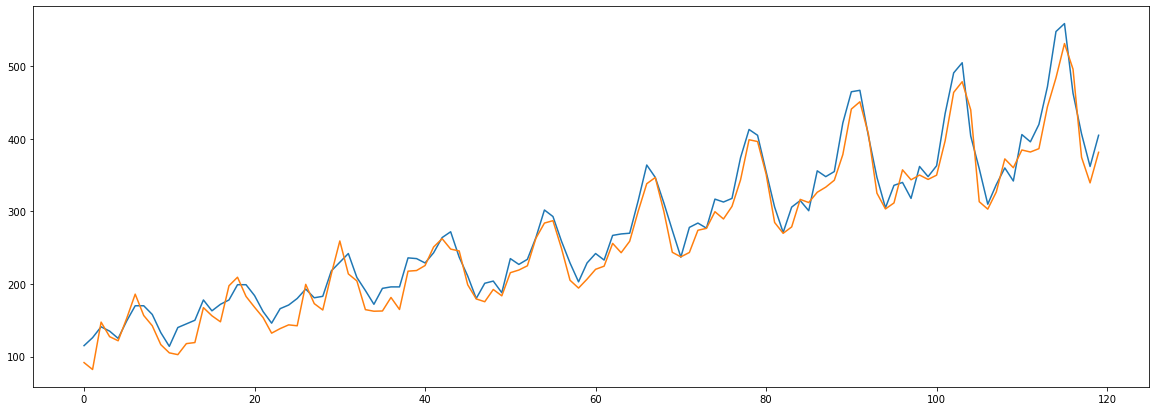

In [1092]:
plt.plot(np.array(y_train))
plt.plot(y_train_pred)

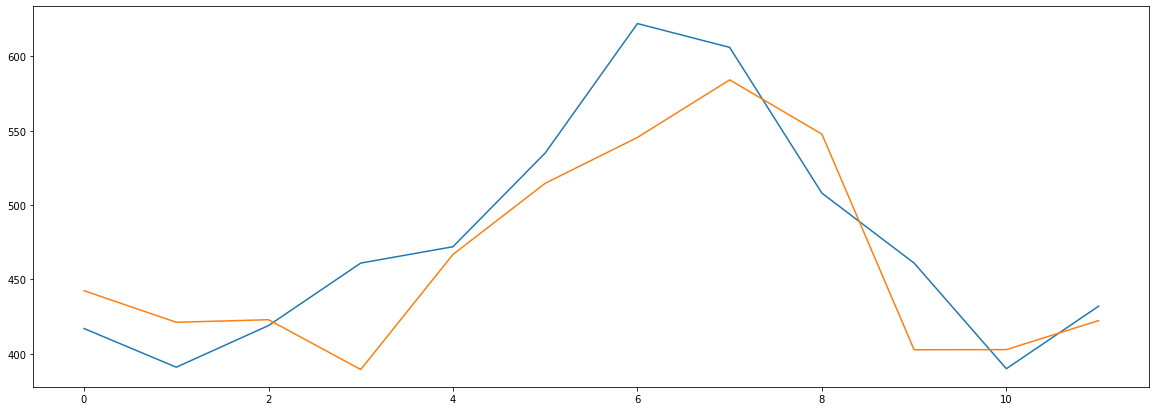

In [1093]:
plt.plot(np.array(y_test))
plt.plot(y_test_pred)

In [1094]:
test_r2 = r2_score(y_test, y_test_pred)
test_r2

0.7186999621556956

# Обучим рекуррентную сеть

Для этого преобразуем данные, на вход будем подавать вектора [месяц, сумма] по каждому из 12 предшествующих этому месяцев

In [978]:
df_rec = np.array(df[['Passengers1month_back',
       'month1month_back', 'Passengers2month_back',
       'month2month_back', 'Passengers3month_back',
       'month3month_back', 'Passengers4month_back',
       'month4month_back', 'Passengers5month_back',
       'month5month_back', 'Passengers6month_back',
       'month6month_back', 'Passengers7month_back',
       'month7month_back', 'Passengers8month_back',
       'month8month_back', 'Passengers9month_back',
        'month9month_back', 'Passengers10month_back',
      'month10month_back', 'Passengers11month_back',
        'month11month_back', 'Passengers12month_back',
     'month12month_back']][x_len:])

df_rec_scaled = scaler.fit_transform(df_rec)


df_rec_scaled.shape

(132, 24)

In [979]:
df_rec_scaled[0]

array([0.00787402, 1.        , 0.        , 0.90909091, 0.02895753,
       0.81818182, 0.06177606, 0.72727273, 0.08494208, 0.63636364,
       0.0967033 , 0.54545455, 0.06813187, 0.45454545, 0.03736264,
       0.36363636, 0.05494505, 0.27272727, 0.06153846, 0.18181818,
       0.03076923, 0.09090909, 0.01758242, 0.        ])

In [980]:
df_rec_scaled = df_rec_scaled.reshape(132, 12, 2)

In [981]:
df_rec_scaled[0]

array([[0.00787402, 1.        ],
       [0.        , 0.90909091],
       [0.02895753, 0.81818182],
       [0.06177606, 0.72727273],
       [0.08494208, 0.63636364],
       [0.0967033 , 0.54545455],
       [0.06813187, 0.45454545],
       [0.03736264, 0.36363636],
       [0.05494505, 0.27272727],
       [0.06153846, 0.18181818],
       [0.03076923, 0.09090909],
       [0.01758242, 0.        ]])

In [982]:
X_train = df_rec_scaled[:120]
X_train.shape

(120, 12, 2)

In [983]:
X_test = df_rec_scaled[120:]
X_test.shape

(12, 12, 2)

In [929]:
model = Sequential()
model.add(LSTM(128, input_shape=(12, 2)))
model.add(Dense(1, activation='elu'))


model.compile(optimizer='Adam',
              loss='mse',
              metrics=['mse'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 128)               67072     
                                                                 
 dense_100 (Dense)           (None, 1)                 129       
                                                                 
Total params: 67201 (262.50 KB)
Trainable params: 67201 (262.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [931]:
X_train.shape

(120, 12, 2)

In [940]:
%%time
model.fit(X_train, y_train,
          epochs=5000,
          validation_data=(X_test, y_test)
          )

Epoch 1/5000
4/4 [==============================] - 0s 20ms/step - loss: 174.7310 - mse: 174.7310 - val_loss: 4719.5703 - val_mse: 4719.5703
Epoch 2/5000
4/4 [==============================] - 0s 12ms/step - loss: 174.6382 - mse: 174.6382 - val_loss: 4731.8081 - val_mse: 4731.8081
Epoch 3/5000
4/4 [==============================] - 0s 13ms/step - loss: 175.3338 - mse: 175.3338 - val_loss: 4750.5605 - val_mse: 4750.5605
Epoch 4/5000
4/4 [==============================] - 0s 12ms/step - loss: 172.0706 - mse: 172.0706 - val_loss: 4685.5801 - val_mse: 4685.5801
Epoch 5/5000
4/4 [==============================] - 0s 14ms/step - loss: 171.6221 - mse: 171.6221 - val_loss: 4722.7256 - val_mse: 4722.7256
Epoch 6/5000
4/4 [==============================] - 0s 12ms/step - loss: 170.9666 - mse: 170.9666 - val_loss: 4681.1216 - val_mse: 4681.1216
Epoch 7/5000
4/4 [==============================] - 0s 12ms/step - loss: 171.0857 - mse: 171.0857 - val_loss: 4729.1299 - val_mse: 4729.1299
Epoch 8/5000


Epoch 59/5000
4/4 [==============================] - 0s 11ms/step - loss: 148.3736 - mse: 148.3736 - val_loss: 4294.0186 - val_mse: 4294.0186
Epoch 60/5000
4/4 [==============================] - 0s 11ms/step - loss: 145.6072 - mse: 145.6072 - val_loss: 4290.2910 - val_mse: 4290.2910
Epoch 61/5000
4/4 [==============================] - 0s 11ms/step - loss: 145.1301 - mse: 145.1301 - val_loss: 4264.8267 - val_mse: 4264.8267
Epoch 62/5000
4/4 [==============================] - 0s 10ms/step - loss: 143.9980 - mse: 143.9980 - val_loss: 4270.6729 - val_mse: 4270.6729
Epoch 63/5000
4/4 [==============================] - 0s 11ms/step - loss: 143.7608 - mse: 143.7608 - val_loss: 4249.0615 - val_mse: 4249.0615
Epoch 64/5000
4/4 [==============================] - 0s 11ms/step - loss: 143.6239 - mse: 143.6239 - val_loss: 4281.8115 - val_mse: 4281.8115
Epoch 65/5000
4/4 [==============================] - 0s 11ms/step - loss: 144.9314 - mse: 144.9314 - val_loss: 4268.2554 - val_mse: 4268.2554
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 113.0503 - mse: 113.0503 - val_loss: 3682.5154 - val_mse: 3682.5154
Epoch 174/5000
4/4 [==============================] - 0s 12ms/step - loss: 112.2478 - mse: 112.2478 - val_loss: 3691.6729 - val_mse: 3691.6729
Epoch 175/5000
4/4 [==============================] - 0s 11ms/step - loss: 110.5221 - mse: 110.5221 - val_loss: 3677.2617 - val_mse: 3677.2617
Epoch 176/5000
4/4 [==============================] - 0s 12ms/step - loss: 110.2462 - mse: 110.2462 - val_loss: 3672.3376 - val_mse: 3672.3376
Epoch 177/5000
4/4 [==============================] - 0s 11ms/step - loss: 109.8295 - mse: 109.8295 - val_loss: 3675.4954 - val_mse: 3675.4954
Epoch 178/5000
4/4 [==============================] - 0s 11ms/step - loss: 109.3681 - mse: 109.3681 - val_loss: 3664.4597 - val_mse: 3664.4597
Epoch 179/5000
4/4 [==============================] - 0s 11ms/step - loss: 109.2118 - mse: 109.2118 - val_loss: 3661.5535 - val_mse: 3661.5535
Epoch 180/5000

Epoch 288/5000
4/4 [==============================] - 0s 11ms/step - loss: 83.4493 - mse: 83.4493 - val_loss: 3174.1111 - val_mse: 3174.1111
Epoch 289/5000
4/4 [==============================] - 0s 12ms/step - loss: 82.5640 - mse: 82.5640 - val_loss: 3166.1116 - val_mse: 3166.1116
Epoch 290/5000
4/4 [==============================] - 0s 11ms/step - loss: 80.9606 - mse: 80.9606 - val_loss: 3161.6895 - val_mse: 3161.6895
Epoch 291/5000
4/4 [==============================] - 0s 11ms/step - loss: 80.3685 - mse: 80.3685 - val_loss: 3138.7517 - val_mse: 3138.7517
Epoch 292/5000
4/4 [==============================] - 0s 11ms/step - loss: 82.2712 - mse: 82.2712 - val_loss: 3138.9856 - val_mse: 3138.9856
Epoch 293/5000
4/4 [==============================] - 0s 11ms/step - loss: 83.1768 - mse: 83.1768 - val_loss: 3146.9119 - val_mse: 3146.9119
Epoch 294/5000
4/4 [==============================] - 0s 11ms/step - loss: 78.9461 - mse: 78.9461 - val_loss: 3118.2605 - val_mse: 3118.2605
Epoch 295/500

Epoch 346/5000
4/4 [==============================] - 0s 12ms/step - loss: 69.9901 - mse: 69.9901 - val_loss: 2966.5576 - val_mse: 2966.5576
Epoch 347/5000
4/4 [==============================] - 0s 12ms/step - loss: 70.2378 - mse: 70.2378 - val_loss: 2956.4128 - val_mse: 2956.4128
Epoch 348/5000
4/4 [==============================] - 0s 12ms/step - loss: 69.5025 - mse: 69.5025 - val_loss: 2953.5764 - val_mse: 2953.5764
Epoch 349/5000
4/4 [==============================] - 0s 12ms/step - loss: 68.2480 - mse: 68.2480 - val_loss: 2951.5886 - val_mse: 2951.5886
Epoch 350/5000
4/4 [==============================] - 0s 12ms/step - loss: 67.5294 - mse: 67.5294 - val_loss: 2949.6240 - val_mse: 2949.6240
Epoch 351/5000
4/4 [==============================] - 0s 12ms/step - loss: 67.3547 - mse: 67.3547 - val_loss: 2939.7305 - val_mse: 2939.7305
Epoch 352/5000
4/4 [==============================] - 0s 12ms/step - loss: 67.3760 - mse: 67.3760 - val_loss: 2935.9050 - val_mse: 2935.9050
Epoch 353/500

4/4 [==============================] - 0s 12ms/step - loss: 57.1209 - mse: 57.1209 - val_loss: 2775.1348 - val_mse: 2775.1348
Epoch 405/5000
4/4 [==============================] - 0s 12ms/step - loss: 56.9463 - mse: 56.9463 - val_loss: 2738.3242 - val_mse: 2738.3242
Epoch 406/5000
4/4 [==============================] - 0s 11ms/step - loss: 56.4707 - mse: 56.4707 - val_loss: 2693.5842 - val_mse: 2693.5842
Epoch 407/5000
4/4 [==============================] - 0s 11ms/step - loss: 56.5039 - mse: 56.5039 - val_loss: 2698.4597 - val_mse: 2698.4597
Epoch 408/5000
4/4 [==============================] - 0s 11ms/step - loss: 55.5164 - mse: 55.5164 - val_loss: 2695.3740 - val_mse: 2695.3740
Epoch 409/5000
4/4 [==============================] - 0s 11ms/step - loss: 54.8407 - mse: 54.8407 - val_loss: 2691.4915 - val_mse: 2691.4915
Epoch 410/5000
4/4 [==============================] - 0s 11ms/step - loss: 55.3125 - mse: 55.3125 - val_loss: 2706.5449 - val_mse: 2706.5449
Epoch 411/5000
4/4 [========

4/4 [==============================] - 0s 10ms/step - loss: 61.1574 - mse: 61.1574 - val_loss: 2581.3508 - val_mse: 2581.3508
Epoch 463/5000
4/4 [==============================] - 0s 11ms/step - loss: 69.2536 - mse: 69.2536 - val_loss: 2606.9124 - val_mse: 2606.9124
Epoch 464/5000
4/4 [==============================] - 0s 11ms/step - loss: 71.5896 - mse: 71.5896 - val_loss: 2560.9800 - val_mse: 2560.9800
Epoch 465/5000
4/4 [==============================] - 0s 11ms/step - loss: 69.5085 - mse: 69.5085 - val_loss: 2522.5071 - val_mse: 2522.5071
Epoch 466/5000
4/4 [==============================] - 0s 13ms/step - loss: 60.5649 - mse: 60.5649 - val_loss: 2571.5969 - val_mse: 2571.5969
Epoch 467/5000
4/4 [==============================] - 0s 12ms/step - loss: 58.1668 - mse: 58.1668 - val_loss: 2586.0361 - val_mse: 2586.0361
Epoch 468/5000
4/4 [==============================] - 0s 12ms/step - loss: 53.0197 - mse: 53.0197 - val_loss: 2568.9263 - val_mse: 2568.9263
Epoch 469/5000
4/4 [========

4/4 [==============================] - 0s 11ms/step - loss: 31.5363 - mse: 31.5363 - val_loss: 2224.2732 - val_mse: 2224.2732
Epoch 579/5000
4/4 [==============================] - 0s 11ms/step - loss: 32.5426 - mse: 32.5426 - val_loss: 2201.9199 - val_mse: 2201.9199
Epoch 580/5000
4/4 [==============================] - 0s 11ms/step - loss: 33.0750 - mse: 33.0750 - val_loss: 2299.5583 - val_mse: 2299.5583
Epoch 581/5000
4/4 [==============================] - 0s 11ms/step - loss: 32.5620 - mse: 32.5620 - val_loss: 2237.9929 - val_mse: 2237.9929
Epoch 582/5000
4/4 [==============================] - 0s 11ms/step - loss: 31.2514 - mse: 31.2514 - val_loss: 2214.0852 - val_mse: 2214.0852
Epoch 583/5000
4/4 [==============================] - 0s 11ms/step - loss: 32.1623 - mse: 32.1623 - val_loss: 2207.9333 - val_mse: 2207.9333
Epoch 584/5000
4/4 [==============================] - 0s 11ms/step - loss: 31.8255 - mse: 31.8255 - val_loss: 2226.7263 - val_mse: 2226.7263
Epoch 585/5000
4/4 [========

4/4 [==============================] - 0s 11ms/step - loss: 21.2456 - mse: 21.2456 - val_loss: 2109.4695 - val_mse: 2109.4695
Epoch 695/5000
4/4 [==============================] - 0s 11ms/step - loss: 21.5632 - mse: 21.5632 - val_loss: 2129.3806 - val_mse: 2129.3806
Epoch 696/5000
4/4 [==============================] - 0s 11ms/step - loss: 21.3410 - mse: 21.3410 - val_loss: 2106.3591 - val_mse: 2106.3591
Epoch 697/5000
4/4 [==============================] - 0s 11ms/step - loss: 20.2453 - mse: 20.2453 - val_loss: 2148.6389 - val_mse: 2148.6389
Epoch 698/5000
4/4 [==============================] - 0s 11ms/step - loss: 21.5541 - mse: 21.5541 - val_loss: 2073.8718 - val_mse: 2073.8718
Epoch 699/5000
4/4 [==============================] - 0s 11ms/step - loss: 20.6046 - mse: 20.6046 - val_loss: 2112.3816 - val_mse: 2112.3816
Epoch 700/5000
4/4 [==============================] - 0s 11ms/step - loss: 21.3273 - mse: 21.3273 - val_loss: 2077.7122 - val_mse: 2077.7122
Epoch 701/5000
4/4 [========

4/4 [==============================] - 0s 11ms/step - loss: 151.6930 - mse: 151.6930 - val_loss: 1558.2775 - val_mse: 1558.2775
Epoch 811/5000
4/4 [==============================] - 0s 11ms/step - loss: 125.9179 - mse: 125.9179 - val_loss: 2340.6890 - val_mse: 2340.6890
Epoch 812/5000
4/4 [==============================] - 0s 12ms/step - loss: 139.5827 - mse: 139.5827 - val_loss: 1627.5918 - val_mse: 1627.5918
Epoch 813/5000
4/4 [==============================] - 0s 12ms/step - loss: 196.9797 - mse: 196.9797 - val_loss: 1583.9365 - val_mse: 1583.9365
Epoch 814/5000
4/4 [==============================] - 0s 11ms/step - loss: 131.9373 - mse: 131.9373 - val_loss: 1631.7501 - val_mse: 1631.7501
Epoch 815/5000
4/4 [==============================] - 0s 12ms/step - loss: 90.9134 - mse: 90.9134 - val_loss: 1579.9489 - val_mse: 1579.9489
Epoch 816/5000
4/4 [==============================] - 0s 12ms/step - loss: 85.5851 - mse: 85.5851 - val_loss: 1541.5049 - val_mse: 1541.5049
Epoch 817/5000
4/4

4/4 [==============================] - 0s 17ms/step - loss: 12.9900 - mse: 12.9900 - val_loss: 1550.6210 - val_mse: 1550.6210
Epoch 927/5000
4/4 [==============================] - 0s 17ms/step - loss: 11.9483 - mse: 11.9483 - val_loss: 1524.6237 - val_mse: 1524.6237
Epoch 928/5000
4/4 [==============================] - 0s 13ms/step - loss: 10.2716 - mse: 10.2716 - val_loss: 1655.0826 - val_mse: 1655.0826
Epoch 929/5000
4/4 [==============================] - 0s 13ms/step - loss: 12.0726 - mse: 12.0726 - val_loss: 1565.1644 - val_mse: 1565.1644
Epoch 930/5000
4/4 [==============================] - 0s 13ms/step - loss: 10.7622 - mse: 10.7622 - val_loss: 1522.7954 - val_mse: 1522.7954
Epoch 931/5000
4/4 [==============================] - 0s 13ms/step - loss: 10.6186 - mse: 10.6186 - val_loss: 1561.0322 - val_mse: 1561.0322
Epoch 932/5000
4/4 [==============================] - 0s 13ms/step - loss: 12.1001 - mse: 12.1001 - val_loss: 1534.4093 - val_mse: 1534.4093
Epoch 933/5000
4/4 [========

4/4 [==============================] - 0s 13ms/step - loss: 7.6578 - mse: 7.6578 - val_loss: 1673.6976 - val_mse: 1673.6976
Epoch 1043/5000
4/4 [==============================] - 0s 12ms/step - loss: 7.0846 - mse: 7.0846 - val_loss: 1712.8510 - val_mse: 1712.8510
Epoch 1044/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.4592 - mse: 6.4592 - val_loss: 1774.0439 - val_mse: 1774.0439
Epoch 1045/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.6559 - mse: 6.6559 - val_loss: 1757.2574 - val_mse: 1757.2574
Epoch 1046/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.6938 - mse: 6.6938 - val_loss: 1676.6005 - val_mse: 1676.6005
Epoch 1047/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.7162 - mse: 6.7162 - val_loss: 1681.4176 - val_mse: 1681.4176
Epoch 1048/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.1914 - mse: 6.1914 - val_loss: 1676.3516 - val_mse: 1676.3516
Epoch 1049/5000
4/4 [===============

4/4 [==============================] - 0s 13ms/step - loss: 6.9447 - mse: 6.9447 - val_loss: 1662.9274 - val_mse: 1662.9274
Epoch 1159/5000
4/4 [==============================] - 0s 12ms/step - loss: 7.5065 - mse: 7.5065 - val_loss: 1762.7677 - val_mse: 1762.7677
Epoch 1160/5000
4/4 [==============================] - 0s 12ms/step - loss: 7.6665 - mse: 7.6665 - val_loss: 1783.4362 - val_mse: 1783.4362
Epoch 1161/5000
4/4 [==============================] - 0s 13ms/step - loss: 9.2510 - mse: 9.2510 - val_loss: 1570.6578 - val_mse: 1570.6578
Epoch 1162/5000
4/4 [==============================] - 0s 13ms/step - loss: 11.9407 - mse: 11.9407 - val_loss: 1802.5570 - val_mse: 1802.5570
Epoch 1163/5000
4/4 [==============================] - 0s 13ms/step - loss: 8.8185 - mse: 8.8185 - val_loss: 1537.4144 - val_mse: 1537.4144
Epoch 1164/5000
4/4 [==============================] - 0s 12ms/step - loss: 13.6790 - mse: 13.6790 - val_loss: 1889.7579 - val_mse: 1889.7579
Epoch 1165/5000
4/4 [===========

Epoch 1216/5000
4/4 [==============================] - 0s 12ms/step - loss: 7.5537 - mse: 7.5537 - val_loss: 1885.5861 - val_mse: 1885.5861
Epoch 1217/5000
4/4 [==============================] - 0s 12ms/step - loss: 6.9473 - mse: 6.9473 - val_loss: 1886.6464 - val_mse: 1886.6464
Epoch 1218/5000
4/4 [==============================] - 0s 12ms/step - loss: 7.4349 - mse: 7.4349 - val_loss: 1871.9889 - val_mse: 1871.9889
Epoch 1219/5000
4/4 [==============================] - 0s 12ms/step - loss: 7.0552 - mse: 7.0552 - val_loss: 1884.5140 - val_mse: 1884.5140
Epoch 1220/5000
4/4 [==============================] - 0s 12ms/step - loss: 6.9470 - mse: 6.9470 - val_loss: 1852.7065 - val_mse: 1852.7065
Epoch 1221/5000
4/4 [==============================] - 0s 12ms/step - loss: 6.6895 - mse: 6.6895 - val_loss: 1920.5088 - val_mse: 1920.5088
Epoch 1222/5000
4/4 [==============================] - 0s 12ms/step - loss: 6.5735 - mse: 6.5735 - val_loss: 1833.6508 - val_mse: 1833.6508
Epoch 1223/5000
4/4 

4/4 [==============================] - 0s 12ms/step - loss: 10.6724 - mse: 10.6724 - val_loss: 1653.6312 - val_mse: 1653.6312
Epoch 1333/5000
4/4 [==============================] - 0s 13ms/step - loss: 11.5833 - mse: 11.5833 - val_loss: 1630.4097 - val_mse: 1630.4097
Epoch 1334/5000
4/4 [==============================] - 0s 13ms/step - loss: 7.7714 - mse: 7.7714 - val_loss: 1529.5656 - val_mse: 1529.5656
Epoch 1335/5000
4/4 [==============================] - 0s 12ms/step - loss: 6.8412 - mse: 6.8412 - val_loss: 1733.7841 - val_mse: 1733.7841
Epoch 1336/5000
4/4 [==============================] - 0s 12ms/step - loss: 9.0153 - mse: 9.0153 - val_loss: 1558.4930 - val_mse: 1558.4930
Epoch 1337/5000
4/4 [==============================] - 0s 12ms/step - loss: 9.5709 - mse: 9.5709 - val_loss: 1563.7018 - val_mse: 1563.7018
Epoch 1338/5000
4/4 [==============================] - 0s 12ms/step - loss: 9.5264 - mse: 9.5264 - val_loss: 1724.3624 - val_mse: 1724.3624
Epoch 1339/5000
4/4 [===========

4/4 [==============================] - 0s 14ms/step - loss: 29.0594 - mse: 29.0594 - val_loss: 11796.0156 - val_mse: 11796.0156
Epoch 1391/5000
4/4 [==============================] - 0s 13ms/step - loss: 29.7112 - mse: 29.7112 - val_loss: 8921.8877 - val_mse: 8921.8877
Epoch 1392/5000
4/4 [==============================] - 0s 13ms/step - loss: 21.7903 - mse: 21.7903 - val_loss: 8554.2139 - val_mse: 8554.2139
Epoch 1393/5000
4/4 [==============================] - 0s 14ms/step - loss: 15.1431 - mse: 15.1431 - val_loss: 5020.6748 - val_mse: 5020.6748
Epoch 1394/5000
4/4 [==============================] - 0s 12ms/step - loss: 11.8206 - mse: 11.8206 - val_loss: 3825.5354 - val_mse: 3825.5354
Epoch 1395/5000
4/4 [==============================] - 0s 12ms/step - loss: 15.6459 - mse: 15.6459 - val_loss: 4828.7563 - val_mse: 4828.7563
Epoch 1396/5000
4/4 [==============================] - 0s 13ms/step - loss: 19.9803 - mse: 19.9803 - val_loss: 4027.1465 - val_mse: 4027.1465
Epoch 1397/5000
4/4 

4/4 [==============================] - 0s 13ms/step - loss: 4.7162 - mse: 4.7162 - val_loss: 1688.0465 - val_mse: 1688.0465
Epoch 1507/5000
4/4 [==============================] - 0s 12ms/step - loss: 3.6075 - mse: 3.6075 - val_loss: 1601.5270 - val_mse: 1601.5270
Epoch 1508/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.2183 - mse: 5.2183 - val_loss: 1677.4928 - val_mse: 1677.4928
Epoch 1509/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.4178 - mse: 3.4178 - val_loss: 1647.0557 - val_mse: 1647.0557
Epoch 1510/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.6116 - mse: 3.6116 - val_loss: 1627.8973 - val_mse: 1627.8973
Epoch 1511/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.6734 - mse: 3.6734 - val_loss: 1648.2386 - val_mse: 1648.2386
Epoch 1512/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.7263 - mse: 2.7263 - val_loss: 1557.2705 - val_mse: 1557.2705
Epoch 1513/5000
4/4 [===============

Epoch 1564/5000
4/4 [==============================] - 0s 14ms/step - loss: 48.5008 - mse: 48.5008 - val_loss: 2341.1658 - val_mse: 2341.1658
Epoch 1565/5000
4/4 [==============================] - 0s 14ms/step - loss: 36.2531 - mse: 36.2531 - val_loss: 1708.1801 - val_mse: 1708.1801
Epoch 1566/5000
4/4 [==============================] - 0s 14ms/step - loss: 44.2408 - mse: 44.2408 - val_loss: 1732.2710 - val_mse: 1732.2710
Epoch 1567/5000
4/4 [==============================] - 0s 14ms/step - loss: 29.2977 - mse: 29.2977 - val_loss: 2038.8124 - val_mse: 2038.8124
Epoch 1568/5000
4/4 [==============================] - 0s 14ms/step - loss: 34.1832 - mse: 34.1832 - val_loss: 1858.5118 - val_mse: 1858.5118
Epoch 1569/5000
4/4 [==============================] - 0s 14ms/step - loss: 26.2553 - mse: 26.2553 - val_loss: 1817.4296 - val_mse: 1817.4296
Epoch 1570/5000
4/4 [==============================] - 0s 13ms/step - loss: 24.8058 - mse: 24.8058 - val_loss: 2179.2649 - val_mse: 2179.2649
Epoch 

Epoch 1622/5000
4/4 [==============================] - 0s 13ms/step - loss: 7.2206 - mse: 7.2206 - val_loss: 3050.2556 - val_mse: 3050.2556
Epoch 1623/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.5422 - mse: 6.5422 - val_loss: 3107.2122 - val_mse: 3107.2122
Epoch 1624/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.3049 - mse: 6.3049 - val_loss: 3197.6963 - val_mse: 3197.6963
Epoch 1625/5000
4/4 [==============================] - 0s 12ms/step - loss: 5.9985 - mse: 5.9985 - val_loss: 3751.6855 - val_mse: 3751.6855
Epoch 1626/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.8404 - mse: 5.8404 - val_loss: 3314.6477 - val_mse: 3314.6477
Epoch 1627/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.9213 - mse: 5.9213 - val_loss: 3415.5828 - val_mse: 3415.5828
Epoch 1628/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.8952 - mse: 6.8952 - val_loss: 3520.1292 - val_mse: 3520.1292
Epoch 1629/5000
4/4 

4/4 [==============================] - 0s 14ms/step - loss: 4.4069 - mse: 4.4069 - val_loss: 4074.5745 - val_mse: 4074.5745
Epoch 1739/5000
4/4 [==============================] - 0s 14ms/step - loss: 4.7334 - mse: 4.7334 - val_loss: 4491.6650 - val_mse: 4491.6650
Epoch 1740/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.6677 - mse: 4.6677 - val_loss: 3680.4766 - val_mse: 3680.4766
Epoch 1741/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.6532 - mse: 5.6532 - val_loss: 3386.8357 - val_mse: 3386.8357
Epoch 1742/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.7957 - mse: 5.7957 - val_loss: 3869.9060 - val_mse: 3869.9060
Epoch 1743/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.3584 - mse: 5.3584 - val_loss: 4520.4199 - val_mse: 4520.4199
Epoch 1744/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.7520 - mse: 4.7520 - val_loss: 3886.3623 - val_mse: 3886.3623
Epoch 1745/5000
4/4 [===============

4/4 [==============================] - 0s 12ms/step - loss: 8.5969 - mse: 8.5969 - val_loss: 5857.3032 - val_mse: 5857.3032
Epoch 1855/5000
4/4 [==============================] - 0s 12ms/step - loss: 6.9612 - mse: 6.9612 - val_loss: 3876.7217 - val_mse: 3876.7217
Epoch 1856/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.6179 - mse: 6.6179 - val_loss: 6674.2031 - val_mse: 6674.2031
Epoch 1857/5000
4/4 [==============================] - 0s 12ms/step - loss: 5.3680 - mse: 5.3680 - val_loss: 5272.2622 - val_mse: 5272.2622
Epoch 1858/5000
4/4 [==============================] - 0s 12ms/step - loss: 6.0228 - mse: 6.0228 - val_loss: 4383.5444 - val_mse: 4383.5444
Epoch 1859/5000
4/4 [==============================] - 0s 14ms/step - loss: 5.9254 - mse: 5.9254 - val_loss: 6169.2188 - val_mse: 6169.2188
Epoch 1860/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.5573 - mse: 3.5573 - val_loss: 7107.4126 - val_mse: 7107.4126
Epoch 1861/5000
4/4 [===============

Epoch 1970/5000
4/4 [==============================] - 0s 13ms/step - loss: 15.3565 - mse: 15.3565 - val_loss: 18546.3887 - val_mse: 18546.3887
Epoch 1971/5000
4/4 [==============================] - 0s 13ms/step - loss: 11.4466 - mse: 11.4466 - val_loss: 10319.5459 - val_mse: 10319.5459
Epoch 1972/5000
4/4 [==============================] - 0s 13ms/step - loss: 15.7310 - mse: 15.7310 - val_loss: 8925.9277 - val_mse: 8925.9277
Epoch 1973/5000
4/4 [==============================] - 0s 12ms/step - loss: 16.6884 - mse: 16.6884 - val_loss: 6714.4570 - val_mse: 6714.4570
Epoch 1974/5000
4/4 [==============================] - 0s 13ms/step - loss: 13.1123 - mse: 13.1123 - val_loss: 8421.6416 - val_mse: 8421.6416
Epoch 1975/5000
4/4 [==============================] - 0s 13ms/step - loss: 14.7067 - mse: 14.7067 - val_loss: 11654.2646 - val_mse: 11654.2646
Epoch 1976/5000
4/4 [==============================] - 0s 13ms/step - loss: 19.8847 - mse: 19.8847 - val_loss: 2661.8550 - val_mse: 2661.8550


Epoch 2085/5000
4/4 [==============================] - 0s 13ms/step - loss: 14.6130 - mse: 14.6130 - val_loss: 1421.4603 - val_mse: 1421.4603
Epoch 2086/5000
4/4 [==============================] - 0s 12ms/step - loss: 14.3308 - mse: 14.3308 - val_loss: 1443.6666 - val_mse: 1443.6666
Epoch 2087/5000
4/4 [==============================] - 0s 13ms/step - loss: 16.2170 - mse: 16.2170 - val_loss: 1386.1089 - val_mse: 1386.1089
Epoch 2088/5000
4/4 [==============================] - 0s 12ms/step - loss: 14.1339 - mse: 14.1339 - val_loss: 1402.3164 - val_mse: 1402.3164
Epoch 2089/5000
4/4 [==============================] - 0s 12ms/step - loss: 12.1229 - mse: 12.1229 - val_loss: 1442.5682 - val_mse: 1442.5682
Epoch 2090/5000
4/4 [==============================] - 0s 13ms/step - loss: 15.2647 - mse: 15.2647 - val_loss: 1418.3297 - val_mse: 1418.3297
Epoch 2091/5000
4/4 [==============================] - 0s 12ms/step - loss: 13.5444 - mse: 13.5444 - val_loss: 1405.7570 - val_mse: 1405.7570
Epoch 

Epoch 2143/5000
4/4 [==============================] - 0s 14ms/step - loss: 17.0042 - mse: 17.0042 - val_loss: 987.5327 - val_mse: 987.5327
Epoch 2144/5000
4/4 [==============================] - 0s 14ms/step - loss: 14.4799 - mse: 14.4799 - val_loss: 964.9543 - val_mse: 964.9543
Epoch 2145/5000
4/4 [==============================] - 0s 14ms/step - loss: 16.0389 - mse: 16.0389 - val_loss: 984.3185 - val_mse: 984.3185
Epoch 2146/5000
4/4 [==============================] - 0s 13ms/step - loss: 12.5993 - mse: 12.5993 - val_loss: 978.7603 - val_mse: 978.7603
Epoch 2147/5000
4/4 [==============================] - 0s 12ms/step - loss: 11.4190 - mse: 11.4190 - val_loss: 1006.8304 - val_mse: 1006.8304
Epoch 2148/5000
4/4 [==============================] - 0s 13ms/step - loss: 9.0752 - mse: 9.0752 - val_loss: 1048.7247 - val_mse: 1048.7247
Epoch 2149/5000
4/4 [==============================] - 0s 14ms/step - loss: 10.1285 - mse: 10.1285 - val_loss: 1037.0321 - val_mse: 1037.0321
Epoch 2150/5000


4/4 [==============================] - 0s 14ms/step - loss: 4.4108 - mse: 4.4108 - val_loss: 1101.9351 - val_mse: 1101.9351
Epoch 2260/5000
4/4 [==============================] - 0s 12ms/step - loss: 4.4500 - mse: 4.4500 - val_loss: 1081.5170 - val_mse: 1081.5170
Epoch 2261/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.7388 - mse: 4.7388 - val_loss: 1106.9164 - val_mse: 1106.9164
Epoch 2262/5000
4/4 [==============================] - 0s 12ms/step - loss: 4.4258 - mse: 4.4258 - val_loss: 1103.3730 - val_mse: 1103.3730
Epoch 2263/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.7551 - mse: 4.7551 - val_loss: 1108.6400 - val_mse: 1108.6400
Epoch 2264/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.3740 - mse: 4.3740 - val_loss: 1089.1704 - val_mse: 1089.1704
Epoch 2265/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.0935 - mse: 5.0935 - val_loss: 1115.6167 - val_mse: 1115.6167
Epoch 2266/5000
4/4 [===============

4/4 [==============================] - 0s 13ms/step - loss: 101.0404 - mse: 101.0404 - val_loss: 1316.1106 - val_mse: 1316.1106
Epoch 2376/5000
4/4 [==============================] - 0s 18ms/step - loss: 120.8418 - mse: 120.8418 - val_loss: 977.1127 - val_mse: 977.1127
Epoch 2377/5000
4/4 [==============================] - 0s 12ms/step - loss: 88.2351 - mse: 88.2351 - val_loss: 1270.2178 - val_mse: 1270.2178
Epoch 2378/5000
4/4 [==============================] - 0s 14ms/step - loss: 97.2945 - mse: 97.2945 - val_loss: 1610.9897 - val_mse: 1610.9897
Epoch 2379/5000
4/4 [==============================] - 0s 14ms/step - loss: 91.0136 - mse: 91.0136 - val_loss: 1149.0885 - val_mse: 1149.0885
Epoch 2380/5000
4/4 [==============================] - 0s 15ms/step - loss: 95.2817 - mse: 95.2817 - val_loss: 1025.4669 - val_mse: 1025.4669
Epoch 2381/5000
4/4 [==============================] - 0s 14ms/step - loss: 73.8230 - mse: 73.8230 - val_loss: 962.7703 - val_mse: 962.7703
Epoch 2382/5000
4/4 [=

4/4 [==============================] - 0s 14ms/step - loss: 5.0080 - mse: 5.0080 - val_loss: 973.5095 - val_mse: 973.5095
Epoch 2493/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.8451 - mse: 3.8451 - val_loss: 975.8035 - val_mse: 975.8035
Epoch 2494/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.8386 - mse: 3.8386 - val_loss: 970.6968 - val_mse: 970.6968
Epoch 2495/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.6391 - mse: 3.6391 - val_loss: 978.0266 - val_mse: 978.0266
Epoch 2496/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.6988 - mse: 3.6988 - val_loss: 988.8138 - val_mse: 988.8138
Epoch 2497/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.6856 - mse: 3.6856 - val_loss: 974.5815 - val_mse: 974.5815
Epoch 2498/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.2153 - mse: 4.2153 - val_loss: 963.8465 - val_mse: 963.8465
Epoch 2499/5000
4/4 [=============================

4/4 [==============================] - 0s 13ms/step - loss: 19.2690 - mse: 19.2690 - val_loss: 1183.5732 - val_mse: 1183.5732
Epoch 2610/5000
4/4 [==============================] - 0s 14ms/step - loss: 16.5853 - mse: 16.5853 - val_loss: 1198.8290 - val_mse: 1198.8290
Epoch 2611/5000
4/4 [==============================] - 0s 13ms/step - loss: 17.6616 - mse: 17.6616 - val_loss: 1210.9298 - val_mse: 1210.9298
Epoch 2612/5000
4/4 [==============================] - 0s 13ms/step - loss: 15.6602 - mse: 15.6602 - val_loss: 1194.6021 - val_mse: 1194.6021
Epoch 2613/5000
4/4 [==============================] - 0s 13ms/step - loss: 15.8889 - mse: 15.8889 - val_loss: 1198.5359 - val_mse: 1198.5359
Epoch 2614/5000
4/4 [==============================] - 0s 13ms/step - loss: 13.2721 - mse: 13.2721 - val_loss: 1216.7115 - val_mse: 1216.7115
Epoch 2615/5000
4/4 [==============================] - 0s 13ms/step - loss: 11.7007 - mse: 11.7007 - val_loss: 1212.1156 - val_mse: 1212.1156
Epoch 2616/5000
4/4 [=

4/4 [==============================] - 0s 15ms/step - loss: 3.1845 - mse: 3.1845 - val_loss: 1253.9487 - val_mse: 1253.9487
Epoch 2726/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.4126 - mse: 3.4126 - val_loss: 1244.7506 - val_mse: 1244.7506
Epoch 2727/5000
4/4 [==============================] - 0s 17ms/step - loss: 3.6378 - mse: 3.6378 - val_loss: 1254.0282 - val_mse: 1254.0282
Epoch 2728/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.2208 - mse: 4.2208 - val_loss: 1247.0770 - val_mse: 1247.0770
Epoch 2729/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.7239 - mse: 3.7239 - val_loss: 1237.8969 - val_mse: 1237.8969
Epoch 2730/5000
4/4 [==============================] - 0s 14ms/step - loss: 3.5554 - mse: 3.5554 - val_loss: 1253.9894 - val_mse: 1253.9894
Epoch 2731/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.1440 - mse: 3.1440 - val_loss: 1249.4843 - val_mse: 1249.4843
Epoch 2732/5000
4/4 [===============

4/4 [==============================] - 0s 15ms/step - loss: 115.9739 - mse: 115.9739 - val_loss: 1201.5811 - val_mse: 1201.5811
Epoch 2842/5000
4/4 [==============================] - 0s 13ms/step - loss: 121.8406 - mse: 121.8406 - val_loss: 1142.3451 - val_mse: 1142.3451
Epoch 2843/5000
4/4 [==============================] - 0s 14ms/step - loss: 69.1412 - mse: 69.1412 - val_loss: 1077.1704 - val_mse: 1077.1704
Epoch 2844/5000
4/4 [==============================] - 0s 13ms/step - loss: 76.2175 - mse: 76.2175 - val_loss: 1282.5503 - val_mse: 1282.5503
Epoch 2845/5000
4/4 [==============================] - 0s 13ms/step - loss: 94.8431 - mse: 94.8431 - val_loss: 1723.5350 - val_mse: 1723.5350
Epoch 2846/5000
4/4 [==============================] - 0s 13ms/step - loss: 74.6468 - mse: 74.6468 - val_loss: 1676.1123 - val_mse: 1676.1123
Epoch 2847/5000
4/4 [==============================] - 0s 13ms/step - loss: 52.1832 - mse: 52.1832 - val_loss: 999.9377 - val_mse: 999.9377
Epoch 2848/5000
4/4 

Epoch 2900/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.8221 - mse: 4.8221 - val_loss: 927.4592 - val_mse: 927.4592
Epoch 2901/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.5118 - mse: 4.5118 - val_loss: 938.1880 - val_mse: 938.1880
Epoch 2902/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.2804 - mse: 4.2804 - val_loss: 928.2947 - val_mse: 928.2947
Epoch 2903/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.1911 - mse: 4.1911 - val_loss: 944.8486 - val_mse: 944.8486
Epoch 2904/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.5954 - mse: 3.5954 - val_loss: 943.5156 - val_mse: 943.5156
Epoch 2905/5000
4/4 [==============================] - 0s 14ms/step - loss: 4.0389 - mse: 4.0389 - val_loss: 931.9446 - val_mse: 931.9446
Epoch 2906/5000
4/4 [==============================] - 0s 14ms/step - loss: 3.7417 - mse: 3.7417 - val_loss: 934.3860 - val_mse: 934.3860
Epoch 2907/5000
4/4 [=============

4/4 [==============================] - 0s 13ms/step - loss: 3.1660 - mse: 3.1660 - val_loss: 1029.0696 - val_mse: 1029.0696
Epoch 3019/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.0169 - mse: 3.0169 - val_loss: 1040.8700 - val_mse: 1040.8700
Epoch 3020/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.0560 - mse: 3.0560 - val_loss: 922.0811 - val_mse: 922.0811
Epoch 3021/5000
4/4 [==============================] - 0s 13ms/step - loss: 9.5486 - mse: 9.5486 - val_loss: 1071.1984 - val_mse: 1071.1984
Epoch 3022/5000
4/4 [==============================] - 0s 13ms/step - loss: 13.2294 - mse: 13.2294 - val_loss: 1091.2449 - val_mse: 1091.2449
Epoch 3023/5000
4/4 [==============================] - 0s 13ms/step - loss: 10.8463 - mse: 10.8463 - val_loss: 987.8760 - val_mse: 987.8760
Epoch 3024/5000
4/4 [==============================] - 0s 13ms/step - loss: 7.7744 - mse: 7.7744 - val_loss: 1004.1861 - val_mse: 1004.1861
Epoch 3025/5000
4/4 [===============

Epoch 3134/5000
4/4 [==============================] - 0s 13ms/step - loss: 17.8143 - mse: 17.8143 - val_loss: 1360.8768 - val_mse: 1360.8768
Epoch 3135/5000
4/4 [==============================] - 0s 13ms/step - loss: 11.9535 - mse: 11.9535 - val_loss: 1264.7775 - val_mse: 1264.7775
Epoch 3136/5000
4/4 [==============================] - 0s 12ms/step - loss: 18.1264 - mse: 18.1264 - val_loss: 1305.3245 - val_mse: 1305.3245
Epoch 3137/5000
4/4 [==============================] - 0s 13ms/step - loss: 18.4771 - mse: 18.4771 - val_loss: 1185.1770 - val_mse: 1185.1770
Epoch 3138/5000
4/4 [==============================] - 0s 13ms/step - loss: 12.9190 - mse: 12.9190 - val_loss: 1171.1572 - val_mse: 1171.1572
Epoch 3139/5000
4/4 [==============================] - 0s 13ms/step - loss: 12.1519 - mse: 12.1519 - val_loss: 1200.4561 - val_mse: 1200.4561
Epoch 3140/5000
4/4 [==============================] - 0s 15ms/step - loss: 10.2682 - mse: 10.2682 - val_loss: 1239.8114 - val_mse: 1239.8114
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 3.9069 - mse: 3.9069 - val_loss: 1255.8361 - val_mse: 1255.8361
Epoch 3251/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.3435 - mse: 5.3435 - val_loss: 1252.6425 - val_mse: 1252.6425
Epoch 3252/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.1948 - mse: 5.1948 - val_loss: 1265.5731 - val_mse: 1265.5731
Epoch 3253/5000
4/4 [==============================] - 0s 13ms/step - loss: 8.0123 - mse: 8.0123 - val_loss: 1254.6249 - val_mse: 1254.6249
Epoch 3254/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.9262 - mse: 6.9262 - val_loss: 1227.3070 - val_mse: 1227.3070
Epoch 3255/5000
4/4 [==============================] - 0s 14ms/step - loss: 6.7457 - mse: 6.7457 - val_loss: 1218.5000 - val_mse: 1218.5000
Epoch 3256/5000
4/4 [==============================] - 0s 13ms/step - loss: 7.6351 - mse: 7.6351 - val_loss: 1241.1183 - val_mse: 1241.1183
Epoch 3257/5000
4/4 [===============

4/4 [==============================] - 0s 13ms/step - loss: 2.9901 - mse: 2.9901 - val_loss: 1269.3580 - val_mse: 1269.3580
Epoch 3367/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.2494 - mse: 2.2494 - val_loss: 1268.1340 - val_mse: 1268.1340
Epoch 3368/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.6181 - mse: 2.6181 - val_loss: 1261.4346 - val_mse: 1261.4346
Epoch 3369/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.8426 - mse: 3.8426 - val_loss: 1266.6163 - val_mse: 1266.6163
Epoch 3370/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.1263 - mse: 5.1263 - val_loss: 1282.9740 - val_mse: 1282.9740
Epoch 3371/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.6069 - mse: 3.6069 - val_loss: 1253.8052 - val_mse: 1253.8052
Epoch 3372/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.7364 - mse: 3.7364 - val_loss: 1254.4845 - val_mse: 1254.4845
Epoch 3373/5000
4/4 [===============

4/4 [==============================] - 0s 14ms/step - loss: 3.2777 - mse: 3.2777 - val_loss: 1255.3080 - val_mse: 1255.3080
Epoch 3483/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.9552 - mse: 2.9552 - val_loss: 1261.3914 - val_mse: 1261.3914
Epoch 3484/5000
4/4 [==============================] - 0s 14ms/step - loss: 2.6687 - mse: 2.6687 - val_loss: 1256.9857 - val_mse: 1256.9857
Epoch 3485/5000
4/4 [==============================] - 0s 14ms/step - loss: 2.4603 - mse: 2.4603 - val_loss: 1260.2504 - val_mse: 1260.2504
Epoch 3486/5000
4/4 [==============================] - 0s 14ms/step - loss: 2.7346 - mse: 2.7346 - val_loss: 1262.1268 - val_mse: 1262.1268
Epoch 3487/5000
4/4 [==============================] - 0s 14ms/step - loss: 2.6603 - mse: 2.6603 - val_loss: 1257.2069 - val_mse: 1257.2069
Epoch 3488/5000
4/4 [==============================] - 0s 14ms/step - loss: 2.3320 - mse: 2.3320 - val_loss: 1268.8322 - val_mse: 1268.8322
Epoch 3489/5000
4/4 [===============

Epoch 3540/5000
4/4 [==============================] - 0s 14ms/step - loss: 17.9066 - mse: 17.9066 - val_loss: 1041.8651 - val_mse: 1041.8651
Epoch 3541/5000
4/4 [==============================] - 0s 13ms/step - loss: 24.3450 - mse: 24.3450 - val_loss: 1031.1975 - val_mse: 1031.1975
Epoch 3542/5000
4/4 [==============================] - 0s 13ms/step - loss: 16.4519 - mse: 16.4519 - val_loss: 1004.7375 - val_mse: 1004.7375
Epoch 3543/5000
4/4 [==============================] - 0s 12ms/step - loss: 17.4037 - mse: 17.4037 - val_loss: 992.3970 - val_mse: 992.3970
Epoch 3544/5000
4/4 [==============================] - 0s 13ms/step - loss: 23.5015 - mse: 23.5015 - val_loss: 996.4943 - val_mse: 996.4943
Epoch 3545/5000
4/4 [==============================] - 0s 14ms/step - loss: 16.5121 - mse: 16.5121 - val_loss: 1045.9454 - val_mse: 1045.9454
Epoch 3546/5000
4/4 [==============================] - 0s 13ms/step - loss: 10.7831 - mse: 10.7831 - val_loss: 1039.1313 - val_mse: 1039.1313
Epoch 3547

4/4 [==============================] - 0s 13ms/step - loss: 3.5272 - mse: 3.5272 - val_loss: 1267.1986 - val_mse: 1267.1986
Epoch 3657/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.2425 - mse: 4.2425 - val_loss: 1240.0189 - val_mse: 1240.0189
Epoch 3658/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.6025 - mse: 3.6025 - val_loss: 1202.3298 - val_mse: 1202.3298
Epoch 3659/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.5813 - mse: 2.5813 - val_loss: 1269.1289 - val_mse: 1269.1289
Epoch 3660/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.6719 - mse: 2.6719 - val_loss: 1204.3298 - val_mse: 1204.3298
Epoch 3661/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.3772 - mse: 2.3772 - val_loss: 1225.1925 - val_mse: 1225.1925
Epoch 3662/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.8202 - mse: 2.8202 - val_loss: 1201.7794 - val_mse: 1201.7794
Epoch 3663/5000
4/4 [===============

4/4 [==============================] - 0s 13ms/step - loss: 3.1480 - mse: 3.1480 - val_loss: 1213.0984 - val_mse: 1213.0984
Epoch 3773/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.3094 - mse: 3.3094 - val_loss: 1244.1322 - val_mse: 1244.1322
Epoch 3774/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.9949 - mse: 1.9949 - val_loss: 1311.4811 - val_mse: 1311.4811
Epoch 3775/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.7169 - mse: 2.7169 - val_loss: 1233.8260 - val_mse: 1233.8260
Epoch 3776/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.2601 - mse: 3.2601 - val_loss: 1180.2974 - val_mse: 1180.2974
Epoch 3777/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.1222 - mse: 3.1222 - val_loss: 1283.0549 - val_mse: 1283.0549
Epoch 3778/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.9087 - mse: 2.9087 - val_loss: 1215.6637 - val_mse: 1215.6637
Epoch 3779/5000
4/4 [===============

4/4 [==============================] - 0s 13ms/step - loss: 4.2011 - mse: 4.2011 - val_loss: 1330.8788 - val_mse: 1330.8788
Epoch 3889/5000
4/4 [==============================] - 0s 14ms/step - loss: 4.1190 - mse: 4.1190 - val_loss: 1286.7900 - val_mse: 1286.7900
Epoch 3890/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.9876 - mse: 5.9876 - val_loss: 1317.1737 - val_mse: 1317.1737
Epoch 3891/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.1679 - mse: 5.1679 - val_loss: 1307.9227 - val_mse: 1307.9227
Epoch 3892/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.0800 - mse: 5.0800 - val_loss: 1285.4209 - val_mse: 1285.4209
Epoch 3893/5000
4/4 [==============================] - 0s 14ms/step - loss: 2.3398 - mse: 2.3398 - val_loss: 1318.4965 - val_mse: 1318.4965
Epoch 3894/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.2698 - mse: 3.2698 - val_loss: 1308.1307 - val_mse: 1308.1307
Epoch 3895/5000
4/4 [===============

Epoch 4004/5000
4/4 [==============================] - 0s 14ms/step - loss: 4.6783 - mse: 4.6783 - val_loss: 1236.4854 - val_mse: 1236.4854
Epoch 4005/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.7195 - mse: 4.7195 - val_loss: 1220.8091 - val_mse: 1220.8091
Epoch 4006/5000
4/4 [==============================] - 0s 12ms/step - loss: 4.5295 - mse: 4.5295 - val_loss: 1250.8208 - val_mse: 1250.8208
Epoch 4007/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.1751 - mse: 5.1751 - val_loss: 1253.8359 - val_mse: 1253.8359
Epoch 4008/5000
4/4 [==============================] - 0s 12ms/step - loss: 4.8496 - mse: 4.8496 - val_loss: 1225.9188 - val_mse: 1225.9188
Epoch 4009/5000
4/4 [==============================] - 0s 12ms/step - loss: 4.5018 - mse: 4.5018 - val_loss: 1236.1184 - val_mse: 1236.1184
Epoch 4010/5000
4/4 [==============================] - 0s 12ms/step - loss: 4.7729 - mse: 4.7729 - val_loss: 1256.9513 - val_mse: 1256.9513
Epoch 4011/5000
4/4 

4/4 [==============================] - 0s 13ms/step - loss: 2.4881 - mse: 2.4881 - val_loss: 1278.3389 - val_mse: 1278.3389
Epoch 4121/5000
4/4 [==============================] - 0s 12ms/step - loss: 2.6078 - mse: 2.6078 - val_loss: 1286.1764 - val_mse: 1286.1764
Epoch 4122/5000
4/4 [==============================] - 0s 12ms/step - loss: 3.3277 - mse: 3.3277 - val_loss: 1279.5236 - val_mse: 1279.5236
Epoch 4123/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.2969 - mse: 2.2969 - val_loss: 1296.6736 - val_mse: 1296.6736
Epoch 4124/5000
4/4 [==============================] - 0s 12ms/step - loss: 3.2259 - mse: 3.2259 - val_loss: 1283.5586 - val_mse: 1283.5586
Epoch 4125/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.8516 - mse: 2.8516 - val_loss: 1290.0648 - val_mse: 1290.0648
Epoch 4126/5000
4/4 [==============================] - 0s 13ms/step - loss: 1.9839 - mse: 1.9839 - val_loss: 1300.3177 - val_mse: 1300.3177
Epoch 4127/5000
4/4 [===============

4/4 [==============================] - 0s 13ms/step - loss: 2.5759 - mse: 2.5759 - val_loss: 1323.2833 - val_mse: 1323.2833
Epoch 4237/5000
4/4 [==============================] - 0s 12ms/step - loss: 1.7141 - mse: 1.7141 - val_loss: 1314.2151 - val_mse: 1314.2151
Epoch 4238/5000
4/4 [==============================] - 0s 12ms/step - loss: 2.2942 - mse: 2.2942 - val_loss: 1298.9886 - val_mse: 1298.9886
Epoch 4239/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.1566 - mse: 3.1566 - val_loss: 1272.6885 - val_mse: 1272.6885
Epoch 4240/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.9677 - mse: 2.9677 - val_loss: 1301.2347 - val_mse: 1301.2347
Epoch 4241/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.7841 - mse: 3.7841 - val_loss: 1314.7279 - val_mse: 1314.7279
Epoch 4242/5000
4/4 [==============================] - 0s 12ms/step - loss: 3.6039 - mse: 3.6039 - val_loss: 1306.2977 - val_mse: 1306.2977
Epoch 4243/5000
4/4 [===============

4/4 [==============================] - 0s 13ms/step - loss: 2.7430 - mse: 2.7430 - val_loss: 1266.0072 - val_mse: 1266.0072
Epoch 4353/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.3000 - mse: 2.3000 - val_loss: 1261.4158 - val_mse: 1261.4158
Epoch 4354/5000
4/4 [==============================] - 0s 12ms/step - loss: 5.8829 - mse: 5.8829 - val_loss: 1254.7587 - val_mse: 1254.7587
Epoch 4355/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.1382 - mse: 3.1382 - val_loss: 1246.4452 - val_mse: 1246.4452
Epoch 4356/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.8467 - mse: 5.8467 - val_loss: 1243.1451 - val_mse: 1243.1451
Epoch 4357/5000
4/4 [==============================] - 0s 15ms/step - loss: 5.0189 - mse: 5.0189 - val_loss: 1296.2391 - val_mse: 1296.2391
Epoch 4358/5000
4/4 [==============================] - 0s 12ms/step - loss: 6.2912 - mse: 6.2912 - val_loss: 1226.9171 - val_mse: 1226.9171
Epoch 4359/5000
4/4 [===============

4/4 [==============================] - 0s 13ms/step - loss: 5.3502 - mse: 5.3502 - val_loss: 1520.2614 - val_mse: 1520.2614
Epoch 4469/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.3358 - mse: 4.3358 - val_loss: 1326.7186 - val_mse: 1326.7186
Epoch 4470/5000
4/4 [==============================] - 0s 12ms/step - loss: 9.4157 - mse: 9.4157 - val_loss: 1320.8103 - val_mse: 1320.8103
Epoch 4471/5000
4/4 [==============================] - 0s 13ms/step - loss: 7.2295 - mse: 7.2295 - val_loss: 1248.0062 - val_mse: 1248.0062
Epoch 4472/5000
4/4 [==============================] - 0s 14ms/step - loss: 5.3275 - mse: 5.3275 - val_loss: 1255.1044 - val_mse: 1255.1044
Epoch 4473/5000
4/4 [==============================] - 0s 13ms/step - loss: 7.6153 - mse: 7.6153 - val_loss: 1298.7500 - val_mse: 1298.7500
Epoch 4474/5000
4/4 [==============================] - 0s 12ms/step - loss: 4.9041 - mse: 4.9041 - val_loss: 1251.6987 - val_mse: 1251.6987
Epoch 4475/5000
4/4 [===============

4/4 [==============================] - 0s 14ms/step - loss: 5.9758 - mse: 5.9758 - val_loss: 1263.6407 - val_mse: 1263.6407
Epoch 4585/5000
4/4 [==============================] - 0s 13ms/step - loss: 11.0768 - mse: 11.0768 - val_loss: 1289.8335 - val_mse: 1289.8335
Epoch 4586/5000
4/4 [==============================] - 0s 13ms/step - loss: 8.6332 - mse: 8.6332 - val_loss: 1337.7915 - val_mse: 1337.7915
Epoch 4587/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.5306 - mse: 5.5306 - val_loss: 1328.5939 - val_mse: 1328.5939
Epoch 4588/5000
4/4 [==============================] - 0s 12ms/step - loss: 4.1247 - mse: 4.1247 - val_loss: 1284.1411 - val_mse: 1284.1411
Epoch 4589/5000
4/4 [==============================] - 0s 14ms/step - loss: 3.5170 - mse: 3.5170 - val_loss: 1228.1700 - val_mse: 1228.1700
Epoch 4590/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.9914 - mse: 2.9914 - val_loss: 1276.8933 - val_mse: 1276.8933
Epoch 4591/5000
4/4 [=============

4/4 [==============================] - 0s 13ms/step - loss: 58.7594 - mse: 58.7594 - val_loss: 2021.6271 - val_mse: 2021.6271
Epoch 4643/5000
4/4 [==============================] - 0s 13ms/step - loss: 55.2004 - mse: 55.2004 - val_loss: 1999.4717 - val_mse: 1999.4717
Epoch 4644/5000
4/4 [==============================] - 0s 12ms/step - loss: 41.1716 - mse: 41.1716 - val_loss: 2053.7046 - val_mse: 2053.7046
Epoch 4645/5000
4/4 [==============================] - 0s 13ms/step - loss: 41.6335 - mse: 41.6335 - val_loss: 2059.5146 - val_mse: 2059.5146
Epoch 4646/5000
4/4 [==============================] - 0s 13ms/step - loss: 39.6285 - mse: 39.6285 - val_loss: 1944.6528 - val_mse: 1944.6528
Epoch 4647/5000
4/4 [==============================] - 0s 13ms/step - loss: 37.6272 - mse: 37.6272 - val_loss: 1888.9481 - val_mse: 1888.9481
Epoch 4648/5000
4/4 [==============================] - 0s 12ms/step - loss: 39.9020 - mse: 39.9020 - val_loss: 1852.9564 - val_mse: 1852.9564
Epoch 4649/5000
4/4 [=

4/4 [==============================] - 0s 13ms/step - loss: 5.2105 - mse: 5.2105 - val_loss: 1508.8163 - val_mse: 1508.8163
Epoch 4759/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.3643 - mse: 4.3643 - val_loss: 1519.2417 - val_mse: 1519.2417
Epoch 4760/5000
4/4 [==============================] - 0s 14ms/step - loss: 4.8375 - mse: 4.8375 - val_loss: 1467.3229 - val_mse: 1467.3229
Epoch 4761/5000
4/4 [==============================] - 0s 14ms/step - loss: 6.8200 - mse: 6.8200 - val_loss: 1485.9506 - val_mse: 1485.9506
Epoch 4762/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.8500 - mse: 4.8500 - val_loss: 1513.6772 - val_mse: 1513.6772
Epoch 4763/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.4015 - mse: 4.4015 - val_loss: 1409.6049 - val_mse: 1409.6049
Epoch 4764/5000
4/4 [==============================] - 0s 12ms/step - loss: 6.6758 - mse: 6.6758 - val_loss: 1577.5978 - val_mse: 1577.5978
Epoch 4765/5000
4/4 [===============

4/4 [==============================] - 0s 12ms/step - loss: 1.7685 - mse: 1.7685 - val_loss: 1323.1654 - val_mse: 1323.1654
Epoch 4875/5000
4/4 [==============================] - 0s 12ms/step - loss: 4.0375 - mse: 4.0375 - val_loss: 1358.7548 - val_mse: 1358.7548
Epoch 4876/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.6532 - mse: 3.6532 - val_loss: 1369.6699 - val_mse: 1369.6699
Epoch 4877/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.5037 - mse: 2.5037 - val_loss: 1318.0776 - val_mse: 1318.0776
Epoch 4878/5000
4/4 [==============================] - 0s 13ms/step - loss: 2.6125 - mse: 2.6125 - val_loss: 1345.2114 - val_mse: 1345.2114
Epoch 4879/5000
4/4 [==============================] - 0s 12ms/step - loss: 1.8237 - mse: 1.8237 - val_loss: 1343.8400 - val_mse: 1343.8400
Epoch 4880/5000
4/4 [==============================] - 0s 13ms/step - loss: 1.3806 - mse: 1.3806 - val_loss: 1315.7633 - val_mse: 1315.7633
Epoch 4881/5000
4/4 [===============

4/4 [==============================] - 0s 16ms/step - loss: 1.1892 - mse: 1.1892 - val_loss: 1308.1067 - val_mse: 1308.1067
Epoch 4991/5000
4/4 [==============================] - 0s 12ms/step - loss: 0.9030 - mse: 0.9030 - val_loss: 1297.4777 - val_mse: 1297.4777
Epoch 4992/5000
4/4 [==============================] - 0s 13ms/step - loss: 1.4120 - mse: 1.4120 - val_loss: 1311.4926 - val_mse: 1311.4926
Epoch 4993/5000
4/4 [==============================] - 0s 12ms/step - loss: 0.8473 - mse: 0.8473 - val_loss: 1304.1329 - val_mse: 1304.1329
Epoch 4994/5000
4/4 [==============================] - 0s 13ms/step - loss: 0.8073 - mse: 0.8073 - val_loss: 1311.7908 - val_mse: 1311.7908
Epoch 4995/5000
4/4 [==============================] - 0s 13ms/step - loss: 0.9364 - mse: 0.9364 - val_loss: 1311.6190 - val_mse: 1311.6190
Epoch 4996/5000
4/4 [==============================] - 0s 13ms/step - loss: 0.8004 - mse: 0.8004 - val_loss: 1306.7294 - val_mse: 1306.7294
Epoch 4997/5000
4/4 [===============

In [941]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 18ms/step - loss: 1312.5142 - mse: 1312.5142


[1312.51416015625, 1312.51416015625]

In [942]:
X_train[:2]

array([[[0.00787402, 1.        ],
        [0.        , 0.90909091],
        [0.02895753, 0.81818182],
        [0.06177606, 0.72727273],
        [0.08494208, 0.63636364],
        [0.0967033 , 0.54545455],
        [0.06813187, 0.45454545],
        [0.03736264, 0.36363636],
        [0.05494505, 0.27272727],
        [0.06153846, 0.18181818],
        [0.03076923, 0.09090909],
        [0.01758242, 0.        ]],

       [[0.0019685 , 0.        ],
        [0.02702703, 1.        ],
        [0.        , 0.90909091],
        [0.02895753, 0.81818182],
        [0.06177606, 0.72727273],
        [0.0967033 , 0.63636364],
        [0.0967033 , 0.54545455],
        [0.06813187, 0.45454545],
        [0.03736264, 0.36363636],
        [0.05494505, 0.27272727],
        [0.06153846, 0.18181818],
        [0.03076923, 0.09090909]]])

In [943]:
y_train

array([115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145,
       150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180,
       193, 181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236,
       235, 229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227,
       234, 264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270,
       315, 364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374,
       413, 405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465,
       467, 404, 347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505,
       404, 359, 310, 337, 360, 342, 406, 396, 420, 472, 548, 559, 463,
       407, 362, 405])

In [944]:
y_train_pred = np.array(model.predict(X_train))
y_train_pred

4/4 [==============================] - 0s 3ms/step


array([[115.70207 ],
       [126.3638  ],
       [141.49316 ],
       [135.23906 ],
       [125.109535],
       [149.11029 ],
       [170.64209 ],
       [170.24661 ],
       [158.71008 ],
       [133.6564  ],
       [114.232994],
       [141.30981 ],
       [145.90158 ],
       [150.55133 ],
       [178.68599 ],
       [163.75443 ],
       [172.60345 ],
       [178.83273 ],
       [199.69159 ],
       [199.60019 ],
       [184.44919 ],
       [162.59814 ],
       [146.42435 ],
       [166.70337 ],
       [171.74127 ],
       [180.29388 ],
       [192.9846  ],
       [181.92618 ],
       [183.79732 ],
       [217.93652 ],
       [231.4544  ],
       [243.11649 ],
       [209.22894 ],
       [191.2424  ],
       [172.11696 ],
       [193.88577 ],
       [196.05215 ],
       [196.30795 ],
       [236.77968 ],
       [231.7264  ],
       [231.62189 ],
       [248.20316 ],
       [265.59515 ],
       [272.81924 ],
       [237.92554 ],
       [211.8678  ],
       [180.59518 ],
       [202.1

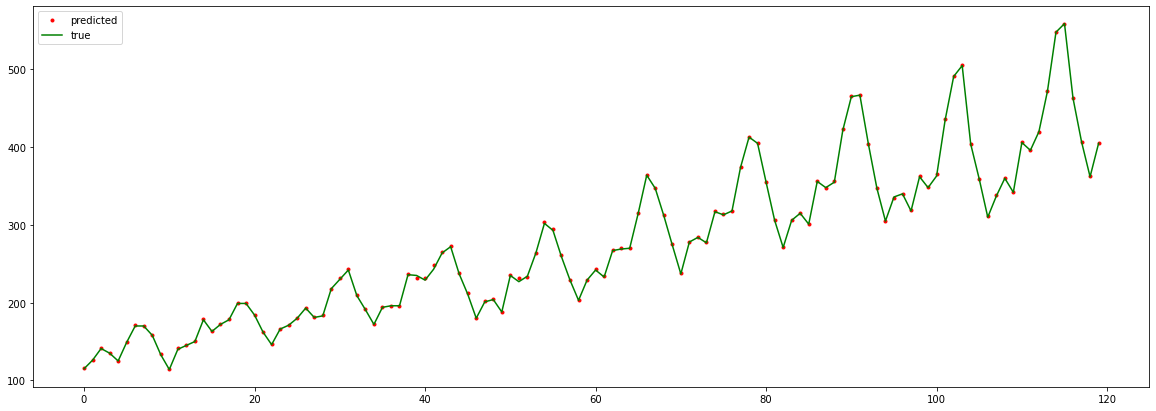

In [945]:
plt.plot(y_train_pred, '.r', label='predicted')
plt.plot(np.array(y_train), 'g', label='true')
plt.legend();

1/1 [==============================] - 0s 14ms/step


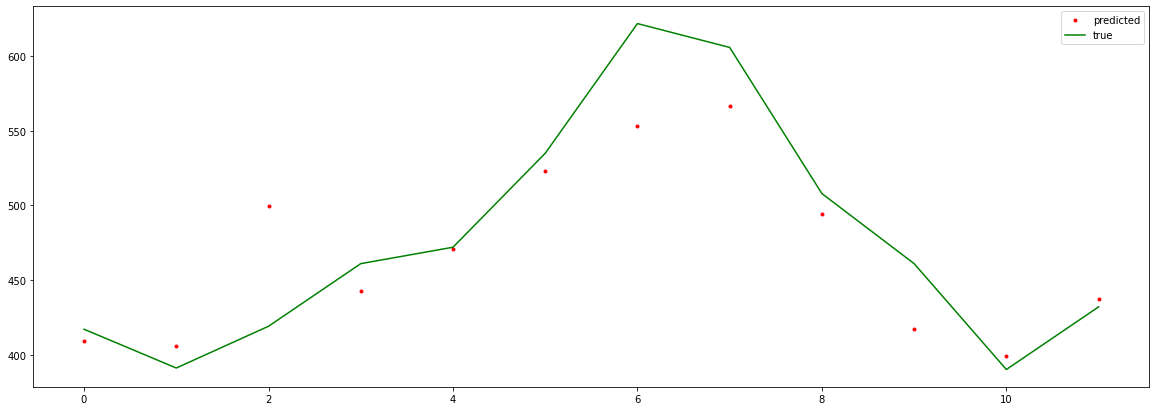

In [946]:
y_test_pred = np.array(model.predict(X_test))

plt.plot(y_test_pred, '.r', label='predicted')
plt.plot(np.array(y_test), 'g', label='true')
plt.legend();

In [947]:
test_r2 = r2_score(y_test, y_test_pred)
test_r2

0.7630615120564468

Вывод: рекуррентная сеть LSTM(128) показала самый высокий результат по метрике r2 при использовании входных данных в виде 12 пар предыдущих показателей [месяц, пассажиропоток], нормализации этих данных с помощью minmaxscaler и использовании 5000 эпох (недостаток - длительность обечения). 

## Gated Recurrent Unit (GRU)

Теперь, когда мы знаем как работает LSTM, давайте бегло взглянем на то, как работает GRU.

In [1045]:
from tensorflow.keras.layers import GRU


model = Sequential()
model.add(GRU(128, input_shape=(12, 2)))
model.add(Dense(1, activation='elu'))


model.compile(optimizer='Adam',
              loss='mse',
              metrics=['mse'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 128)               50688     
                                                                 
 dense_105 (Dense)           (None, 1)                 129       
                                                                 
Total params: 50817 (198.50 KB)
Trainable params: 50817 (198.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [1046]:
%%time
model.fit(X_train, y_train,
          epochs=5000,
          validation_data=(X_test, y_test)
          )

Epoch 1/5000
4/4 [==============================] - 1s 82ms/step - loss: 86515.0703 - mse: 86515.0703 - val_loss: 231832.2656 - val_mse: 231832.2656
Epoch 2/5000
4/4 [==============================] - 0s 11ms/step - loss: 86320.5469 - mse: 86320.5469 - val_loss: 231343.2969 - val_mse: 231343.2969
Epoch 3/5000
4/4 [==============================] - 0s 12ms/step - loss: 86049.7344 - mse: 86049.7344 - val_loss: 230527.4531 - val_mse: 230527.4531
Epoch 4/5000
4/4 [==============================] - 0s 11ms/step - loss: 85539.8516 - mse: 85539.8516 - val_loss: 228563.1875 - val_mse: 228563.1875
Epoch 5/5000
4/4 [==============================] - 0s 12ms/step - loss: 84139.1172 - mse: 84139.1172 - val_loss: 223402.1719 - val_mse: 223402.1719
Epoch 6/5000
4/4 [==============================] - 0s 11ms/step - loss: 80953.8438 - mse: 80953.8438 - val_loss: 219922.0469 - val_mse: 219922.0469
Epoch 7/5000
4/4 [==============================] - 0s 12ms/step - loss: 79262.3906 - mse: 79262.3906 - va

Epoch 56/5000
4/4 [==============================] - 0s 11ms/step - loss: 65095.4609 - mse: 65095.4609 - val_loss: 193636.8750 - val_mse: 193636.8750
Epoch 57/5000
4/4 [==============================] - 0s 10ms/step - loss: 64852.4531 - mse: 64852.4531 - val_loss: 193194.9219 - val_mse: 193194.9219
Epoch 58/5000
4/4 [==============================] - 0s 11ms/step - loss: 64616.7422 - mse: 64616.7422 - val_loss: 192750.7344 - val_mse: 192750.7344
Epoch 59/5000
4/4 [==============================] - 0s 10ms/step - loss: 64377.9297 - mse: 64377.9297 - val_loss: 192308.6250 - val_mse: 192308.6250
Epoch 60/5000
4/4 [==============================] - 0s 10ms/step - loss: 64142.6172 - mse: 64142.6172 - val_loss: 191866.4375 - val_mse: 191866.4375
Epoch 61/5000
4/4 [==============================] - 0s 10ms/step - loss: 63903.0352 - mse: 63903.0352 - val_loss: 191425.4375 - val_mse: 191425.4375
Epoch 62/5000
4/4 [==============================] - 0s 10ms/step - loss: 63665.4961 - mse: 63665.49

4/4 [==============================] - 0s 11ms/step - loss: 43599.5234 - mse: 43599.5234 - val_loss: 151536.9375 - val_mse: 151536.9375
Epoch 165/5000
4/4 [==============================] - 0s 11ms/step - loss: 43436.9961 - mse: 43436.9961 - val_loss: 151197.1562 - val_mse: 151197.1562
Epoch 166/5000
4/4 [==============================] - 0s 10ms/step - loss: 43277.8086 - mse: 43277.8086 - val_loss: 150855.7344 - val_mse: 150855.7344
Epoch 167/5000
4/4 [==============================] - 0s 10ms/step - loss: 43117.1797 - mse: 43117.1797 - val_loss: 150515.3906 - val_mse: 150515.3906
Epoch 168/5000
4/4 [==============================] - 0s 10ms/step - loss: 42953.4648 - mse: 42953.4648 - val_loss: 150178.9375 - val_mse: 150178.9375
Epoch 169/5000
4/4 [==============================] - 0s 11ms/step - loss: 42794.1016 - mse: 42794.1016 - val_loss: 149842.8750 - val_mse: 149842.8750
Epoch 170/5000
4/4 [==============================] - 0s 11ms/step - loss: 42634.7930 - mse: 42634.7930 - val

4/4 [==============================] - 0s 11ms/step - loss: 29181.8242 - mse: 29181.8242 - val_loss: 119129.8984 - val_mse: 119129.8984
Epoch 273/5000
4/4 [==============================] - 0s 11ms/step - loss: 29080.6699 - mse: 29080.6699 - val_loss: 118870.3438 - val_mse: 118870.3438
Epoch 274/5000
4/4 [==============================] - 0s 11ms/step - loss: 28973.7148 - mse: 28973.7148 - val_loss: 118612.9766 - val_mse: 118612.9766
Epoch 275/5000
4/4 [==============================] - 0s 11ms/step - loss: 28867.6211 - mse: 28867.6230 - val_loss: 118356.7734 - val_mse: 118356.7734
Epoch 276/5000
4/4 [==============================] - 0s 11ms/step - loss: 28765.2852 - mse: 28765.2852 - val_loss: 118099.0391 - val_mse: 118099.0391
Epoch 277/5000
4/4 [==============================] - 0s 11ms/step - loss: 28662.1367 - mse: 28662.1367 - val_loss: 117841.5547 - val_mse: 117841.5547
Epoch 278/5000
4/4 [==============================] - 0s 11ms/step - loss: 28558.7070 - mse: 28558.7070 - val

Epoch 381/5000
4/4 [==============================] - 0s 11ms/step - loss: 20084.2930 - mse: 20084.2930 - val_loss: 94623.2578 - val_mse: 94623.2578
Epoch 382/5000
4/4 [==============================] - 0s 11ms/step - loss: 20019.0078 - mse: 20019.0078 - val_loss: 94432.1562 - val_mse: 94432.1562
Epoch 383/5000
4/4 [==============================] - 0s 11ms/step - loss: 19957.7207 - mse: 19957.7207 - val_loss: 94238.8359 - val_mse: 94238.8359
Epoch 384/5000
4/4 [==============================] - 0s 11ms/step - loss: 19897.5332 - mse: 19897.5332 - val_loss: 94043.3828 - val_mse: 94043.3828
Epoch 385/5000
4/4 [==============================] - 0s 11ms/step - loss: 19832.1621 - mse: 19832.1621 - val_loss: 93853.1250 - val_mse: 93853.1250
Epoch 386/5000
4/4 [==============================] - 0s 10ms/step - loss: 19767.7129 - mse: 19767.7129 - val_loss: 93666.2891 - val_mse: 93666.2891
Epoch 387/5000
4/4 [==============================] - 0s 11ms/step - loss: 19705.1367 - mse: 19705.1367 - 

Epoch 436/5000
4/4 [==============================] - 0s 11ms/step - loss: 17029.9922 - mse: 17029.9922 - val_loss: 84809.2734 - val_mse: 84809.2734
Epoch 437/5000
4/4 [==============================] - 0s 11ms/step - loss: 16984.2871 - mse: 16984.2871 - val_loss: 84641.1328 - val_mse: 84641.1328
Epoch 438/5000
4/4 [==============================] - 0s 11ms/step - loss: 16932.4395 - mse: 16932.4395 - val_loss: 84478.8125 - val_mse: 84478.8125
Epoch 439/5000
4/4 [==============================] - 0s 11ms/step - loss: 16888.6621 - mse: 16888.6621 - val_loss: 84311.5547 - val_mse: 84311.5547
Epoch 440/5000
4/4 [==============================] - 0s 11ms/step - loss: 16839.6367 - mse: 16839.6367 - val_loss: 84147.4531 - val_mse: 84147.4531
Epoch 441/5000
4/4 [==============================] - 0s 11ms/step - loss: 16792.1641 - mse: 16792.1641 - val_loss: 83984.8828 - val_mse: 83984.8828
Epoch 442/5000
4/4 [==============================] - 0s 11ms/step - loss: 16747.5723 - mse: 16747.5723 - 

Epoch 491/5000
4/4 [==============================] - 0s 11ms/step - loss: 14766.4170 - mse: 14766.4170 - val_loss: 76437.3984 - val_mse: 76437.3984
Epoch 492/5000
4/4 [==============================] - 0s 10ms/step - loss: 14732.0498 - mse: 14732.0508 - val_loss: 76297.6953 - val_mse: 76297.6953
Epoch 493/5000
4/4 [==============================] - 0s 11ms/step - loss: 14695.7480 - mse: 14695.7480 - val_loss: 76161.9688 - val_mse: 76161.9688
Epoch 494/5000
4/4 [==============================] - 0s 11ms/step - loss: 14662.1816 - mse: 14662.1816 - val_loss: 76024.9766 - val_mse: 76024.9766
Epoch 495/5000
4/4 [==============================] - 0s 11ms/step - loss: 14631.6768 - mse: 14631.6768 - val_loss: 75884.1875 - val_mse: 75884.1875
Epoch 496/5000
4/4 [==============================] - 0s 10ms/step - loss: 14596.2705 - mse: 14596.2715 - val_loss: 75747.9141 - val_mse: 75747.9141
Epoch 497/5000
4/4 [==============================] - 0s 10ms/step - loss: 14562.2402 - mse: 14562.2402 - 

Epoch 546/5000
4/4 [==============================] - 0s 11ms/step - loss: 13160.9375 - mse: 13160.9375 - val_loss: 69457.0859 - val_mse: 69457.0859
Epoch 547/5000
4/4 [==============================] - 0s 11ms/step - loss: 13137.2539 - mse: 13137.2539 - val_loss: 69340.6562 - val_mse: 69340.6562
Epoch 548/5000
4/4 [==============================] - 0s 11ms/step - loss: 13112.4287 - mse: 13112.4287 - val_loss: 69226.9922 - val_mse: 69226.9922
Epoch 549/5000
4/4 [==============================] - 0s 11ms/step - loss: 13088.1357 - mse: 13088.1357 - val_loss: 69114.8047 - val_mse: 69114.8047
Epoch 550/5000
4/4 [==============================] - 0s 11ms/step - loss: 13065.5166 - mse: 13065.5166 - val_loss: 69000.5625 - val_mse: 69000.5625
Epoch 551/5000
4/4 [==============================] - 0s 11ms/step - loss: 13041.8926 - mse: 13041.8926 - val_loss: 68886.4141 - val_mse: 68886.4141
Epoch 552/5000
4/4 [==============================] - 0s 11ms/step - loss: 13018.3320 - mse: 13018.3320 - 

Epoch 601/5000
4/4 [==============================] - 0s 11ms/step - loss: 12063.5664 - mse: 12063.5664 - val_loss: 63699.3594 - val_mse: 63699.3594
Epoch 602/5000
4/4 [==============================] - 0s 11ms/step - loss: 12046.8486 - mse: 12046.8486 - val_loss: 63603.2969 - val_mse: 63603.2969
Epoch 603/5000
4/4 [==============================] - 0s 10ms/step - loss: 12030.0146 - mse: 12030.0146 - val_loss: 63509.3242 - val_mse: 63509.3242
Epoch 604/5000
4/4 [==============================] - 0s 10ms/step - loss: 12013.6768 - mse: 12013.6768 - val_loss: 63416.5898 - val_mse: 63416.5898
Epoch 605/5000
4/4 [==============================] - 0s 11ms/step - loss: 11997.1201 - mse: 11997.1201 - val_loss: 63324.7227 - val_mse: 63324.7227
Epoch 606/5000
4/4 [==============================] - 0s 11ms/step - loss: 11983.1602 - mse: 11983.1602 - val_loss: 63227.6250 - val_mse: 63227.6250
Epoch 607/5000
4/4 [==============================] - 0s 10ms/step - loss: 11965.8232 - mse: 11965.8232 - 

Epoch 656/5000
4/4 [==============================] - 0s 11ms/step - loss: 11333.8213 - mse: 11333.8213 - val_loss: 58966.9570 - val_mse: 58966.9570
Epoch 657/5000
4/4 [==============================] - 0s 11ms/step - loss: 11325.0879 - mse: 11325.0879 - val_loss: 58887.7617 - val_mse: 58887.7617
Epoch 658/5000
4/4 [==============================] - 0s 11ms/step - loss: 11314.7393 - mse: 11314.7393 - val_loss: 58809.6055 - val_mse: 58809.6055
Epoch 659/5000
4/4 [==============================] - 0s 11ms/step - loss: 11303.9756 - mse: 11303.9756 - val_loss: 58733.9180 - val_mse: 58733.9180
Epoch 660/5000
4/4 [==============================] - 0s 11ms/step - loss: 11294.0293 - mse: 11294.0293 - val_loss: 58658.6992 - val_mse: 58658.6992
Epoch 661/5000
4/4 [==============================] - 0s 11ms/step - loss: 11284.1562 - mse: 11284.1562 - val_loss: 58583.5742 - val_mse: 58583.5742
Epoch 662/5000
4/4 [==============================] - 0s 11ms/step - loss: 11275.1475 - mse: 11275.1475 - 

Epoch 711/5000
4/4 [==============================] - 0s 11ms/step - loss: 10888.9463 - mse: 10888.9463 - val_loss: 55220.8750 - val_mse: 55220.8750
Epoch 712/5000
4/4 [==============================] - 0s 16ms/step - loss: 10881.4658 - mse: 10881.4658 - val_loss: 55165.3281 - val_mse: 55165.3281
Epoch 713/5000
4/4 [==============================] - 0s 11ms/step - loss: 10875.4961 - mse: 10875.4961 - val_loss: 55106.8867 - val_mse: 55106.8867
Epoch 714/5000
4/4 [==============================] - 0s 11ms/step - loss: 10871.7031 - mse: 10871.7031 - val_loss: 55039.6250 - val_mse: 55039.6250
Epoch 715/5000
4/4 [==============================] - 0s 10ms/step - loss: 10863.7500 - mse: 10863.7500 - val_loss: 54980.0938 - val_mse: 54980.0938
Epoch 716/5000
4/4 [==============================] - 0s 11ms/step - loss: 10859.0566 - mse: 10859.0566 - val_loss: 54916.4961 - val_mse: 54916.4961
Epoch 717/5000
4/4 [==============================] - 0s 11ms/step - loss: 10851.6855 - mse: 10851.6855 - 

Epoch 766/5000
4/4 [==============================] - 0s 11ms/step - loss: 10629.5977 - mse: 10629.5977 - val_loss: 52325.5977 - val_mse: 52325.5977
Epoch 767/5000
4/4 [==============================] - 0s 11ms/step - loss: 10625.7832 - mse: 10625.7832 - val_loss: 52280.8477 - val_mse: 52280.8477
Epoch 768/5000
4/4 [==============================] - 0s 11ms/step - loss: 10623.1934 - mse: 10623.1934 - val_loss: 52232.8320 - val_mse: 52232.8320
Epoch 769/5000
4/4 [==============================] - 0s 11ms/step - loss: 10618.5439 - mse: 10618.5439 - val_loss: 52191.1680 - val_mse: 52191.1680
Epoch 770/5000
4/4 [==============================] - 0s 11ms/step - loss: 10615.6768 - mse: 10615.6768 - val_loss: 52145.0312 - val_mse: 52145.0312
Epoch 771/5000
4/4 [==============================] - 0s 11ms/step - loss: 10612.4248 - mse: 10612.4238 - val_loss: 52098.7383 - val_mse: 52098.7383
Epoch 772/5000
4/4 [==============================] - 0s 11ms/step - loss: 10608.3848 - mse: 10608.3848 - 

Epoch 821/5000
4/4 [==============================] - 0s 11ms/step - loss: 10487.9170 - mse: 10487.9170 - val_loss: 50124.8711 - val_mse: 50124.8711
Epoch 822/5000
4/4 [==============================] - 0s 11ms/step - loss: 10486.3613 - mse: 10486.3613 - val_loss: 50086.5820 - val_mse: 50086.5820
Epoch 823/5000
4/4 [==============================] - 0s 11ms/step - loss: 10484.4580 - mse: 10484.4580 - val_loss: 50050.0977 - val_mse: 50050.0977
Epoch 824/5000
4/4 [==============================] - 0s 11ms/step - loss: 10483.0508 - mse: 10483.0508 - val_loss: 50012.8789 - val_mse: 50012.8789
Epoch 825/5000
4/4 [==============================] - 0s 11ms/step - loss: 10480.2441 - mse: 10480.2441 - val_loss: 49984.7031 - val_mse: 49984.7031
Epoch 826/5000
4/4 [==============================] - 0s 11ms/step - loss: 10478.5244 - mse: 10478.5244 - val_loss: 49954.9688 - val_mse: 49954.9688
Epoch 827/5000
4/4 [==============================] - 0s 11ms/step - loss: 10477.7812 - mse: 10477.7812 - 

Epoch 876/5000
4/4 [==============================] - 0s 11ms/step - loss: 10417.8291 - mse: 10417.8291 - val_loss: 48528.4375 - val_mse: 48528.4375
Epoch 877/5000
4/4 [==============================] - 0s 11ms/step - loss: 10417.2568 - mse: 10417.2568 - val_loss: 48504.1992 - val_mse: 48504.1992
Epoch 878/5000
4/4 [==============================] - 0s 11ms/step - loss: 10416.0215 - mse: 10416.0215 - val_loss: 48484.0625 - val_mse: 48484.0625
Epoch 879/5000
4/4 [==============================] - 0s 11ms/step - loss: 10415.3311 - mse: 10415.3311 - val_loss: 48462.7461 - val_mse: 48462.7461
Epoch 880/5000
4/4 [==============================] - 0s 11ms/step - loss: 10414.4287 - mse: 10414.4287 - val_loss: 48440.1836 - val_mse: 48440.1836
Epoch 881/5000
4/4 [==============================] - 0s 11ms/step - loss: 10413.6533 - mse: 10413.6533 - val_loss: 48416.6992 - val_mse: 48416.6992
Epoch 882/5000
4/4 [==============================] - 0s 11ms/step - loss: 10413.1309 - mse: 10413.1309 - 

Epoch 931/5000
4/4 [==============================] - 0s 12ms/step - loss: 10384.9834 - mse: 10384.9834 - val_loss: 47397.8398 - val_mse: 47397.8398
Epoch 932/5000
4/4 [==============================] - 0s 13ms/step - loss: 10384.7725 - mse: 10384.7725 - val_loss: 47380.1992 - val_mse: 47380.1992
Epoch 933/5000
4/4 [==============================] - 0s 12ms/step - loss: 10384.4248 - mse: 10384.4248 - val_loss: 47360.3945 - val_mse: 47360.3945
Epoch 934/5000
4/4 [==============================] - 0s 12ms/step - loss: 10384.1787 - mse: 10384.1787 - val_loss: 47339.7695 - val_mse: 47339.7695
Epoch 935/5000
4/4 [==============================] - 0s 12ms/step - loss: 10383.5020 - mse: 10383.5020 - val_loss: 47324.0312 - val_mse: 47324.0312
Epoch 936/5000
4/4 [==============================] - 0s 12ms/step - loss: 10383.3301 - mse: 10383.3301 - val_loss: 47306.0742 - val_mse: 47306.0742
Epoch 937/5000
4/4 [==============================] - 0s 13ms/step - loss: 10382.7793 - mse: 10382.7793 - 

Epoch 986/5000
4/4 [==============================] - 0s 12ms/step - loss: 10371.6865 - mse: 10371.6865 - val_loss: 46628.6133 - val_mse: 46628.6133
Epoch 987/5000
4/4 [==============================] - 0s 12ms/step - loss: 10371.3926 - mse: 10371.3926 - val_loss: 46621.2852 - val_mse: 46621.2852
Epoch 988/5000
4/4 [==============================] - 0s 12ms/step - loss: 10371.5215 - mse: 10371.5215 - val_loss: 46605.2852 - val_mse: 46605.2852
Epoch 989/5000
4/4 [==============================] - 0s 12ms/step - loss: 10371.4795 - mse: 10371.4795 - val_loss: 46590.7969 - val_mse: 46590.7969
Epoch 990/5000
4/4 [==============================] - 0s 12ms/step - loss: 10371.0693 - mse: 10371.0693 - val_loss: 46578.6992 - val_mse: 46578.6992
Epoch 991/5000
4/4 [==============================] - 0s 12ms/step - loss: 10370.8926 - mse: 10370.8926 - val_loss: 46576.4844 - val_mse: 46576.4844
Epoch 992/5000
4/4 [==============================] - 0s 12ms/step - loss: 10370.8340 - mse: 10370.8340 - 

Epoch 1041/5000
4/4 [==============================] - 0s 12ms/step - loss: 10366.9365 - mse: 10366.9365 - val_loss: 46165.2812 - val_mse: 46165.2812
Epoch 1042/5000
4/4 [==============================] - 0s 12ms/step - loss: 10366.8369 - mse: 10366.8369 - val_loss: 46152.7344 - val_mse: 46152.7344
Epoch 1043/5000
4/4 [==============================] - 0s 12ms/step - loss: 10366.6289 - mse: 10366.6289 - val_loss: 46145.8164 - val_mse: 46145.8164
Epoch 1044/5000
4/4 [==============================] - 0s 12ms/step - loss: 10366.6143 - mse: 10366.6143 - val_loss: 46136.8750 - val_mse: 46136.8750
Epoch 1045/5000
4/4 [==============================] - 0s 12ms/step - loss: 10366.6084 - mse: 10366.6084 - val_loss: 46134.1211 - val_mse: 46134.1211
Epoch 1046/5000
4/4 [==============================] - 0s 12ms/step - loss: 10366.6230 - mse: 10366.6230 - val_loss: 46119.7227 - val_mse: 46119.7227
Epoch 1047/5000
4/4 [==============================] - 0s 12ms/step - loss: 10366.4990 - mse: 10366.

4/4 [==============================] - 0s 12ms/step - loss: 5316.8975 - mse: 5316.8975 - val_loss: 40224.4219 - val_mse: 40224.4219
Epoch 1151/5000
4/4 [==============================] - 0s 13ms/step - loss: 5228.2388 - mse: 5228.2393 - val_loss: 40069.8398 - val_mse: 40069.8398
Epoch 1152/5000
4/4 [==============================] - 0s 13ms/step - loss: 5194.6333 - mse: 5194.6333 - val_loss: 39907.2227 - val_mse: 39907.2227
Epoch 1153/5000
4/4 [==============================] - 0s 13ms/step - loss: 5184.7495 - mse: 5184.7495 - val_loss: 39750.4844 - val_mse: 39750.4844
Epoch 1154/5000
4/4 [==============================] - 0s 12ms/step - loss: 5130.7373 - mse: 5130.7373 - val_loss: 39647.7461 - val_mse: 39647.7461
Epoch 1155/5000
4/4 [==============================] - 0s 13ms/step - loss: 5082.5498 - mse: 5082.5498 - val_loss: 39440.9102 - val_mse: 39440.9102
Epoch 1156/5000
4/4 [==============================] - 0s 13ms/step - loss: 5064.3369 - mse: 5064.3369 - val_loss: 39274.9688 - 

4/4 [==============================] - 0s 14ms/step - loss: 3050.0615 - mse: 3050.0615 - val_loss: 27539.8652 - val_mse: 27539.8652
Epoch 1261/5000
4/4 [==============================] - 0s 13ms/step - loss: 3036.6724 - mse: 3036.6724 - val_loss: 27302.9199 - val_mse: 27302.9199
Epoch 1262/5000
4/4 [==============================] - 0s 12ms/step - loss: 3036.5933 - mse: 3036.5933 - val_loss: 27169.0137 - val_mse: 27169.0137
Epoch 1263/5000
4/4 [==============================] - 0s 13ms/step - loss: 3021.8110 - mse: 3021.8110 - val_loss: 27123.5723 - val_mse: 27123.5723
Epoch 1264/5000
4/4 [==============================] - 0s 13ms/step - loss: 3000.3633 - mse: 3000.3633 - val_loss: 27483.2344 - val_mse: 27483.2344
Epoch 1265/5000
4/4 [==============================] - 0s 12ms/step - loss: 3001.4231 - mse: 3001.4231 - val_loss: 26926.8379 - val_mse: 26926.8379
Epoch 1266/5000
4/4 [==============================] - 0s 12ms/step - loss: 2988.5510 - mse: 2988.5510 - val_loss: 26831.1094 - 

4/4 [==============================] - 0s 14ms/step - loss: 2145.7590 - mse: 2145.7593 - val_loss: 20118.9121 - val_mse: 20118.9121
Epoch 1371/5000
4/4 [==============================] - 0s 13ms/step - loss: 2153.6643 - mse: 2153.6643 - val_loss: 20072.0664 - val_mse: 20072.0664
Epoch 1372/5000
4/4 [==============================] - 0s 13ms/step - loss: 2128.8257 - mse: 2128.8257 - val_loss: 20018.5605 - val_mse: 20018.5605
Epoch 1373/5000
4/4 [==============================] - 0s 13ms/step - loss: 2137.8455 - mse: 2137.8455 - val_loss: 19979.5000 - val_mse: 19979.5000
Epoch 1374/5000
4/4 [==============================] - 0s 13ms/step - loss: 2139.4844 - mse: 2139.4844 - val_loss: 19923.6465 - val_mse: 19923.6465
Epoch 1375/5000
4/4 [==============================] - 0s 13ms/step - loss: 2121.5051 - mse: 2121.5051 - val_loss: 19871.1660 - val_mse: 19871.1660
Epoch 1376/5000
4/4 [==============================] - 0s 14ms/step - loss: 2107.6833 - mse: 2107.6833 - val_loss: 19875.5703 - 

4/4 [==============================] - 0s 12ms/step - loss: 1396.4214 - mse: 1396.4214 - val_loss: 15557.7764 - val_mse: 15557.7764
Epoch 1481/5000
4/4 [==============================] - 0s 12ms/step - loss: 1381.7231 - mse: 1381.7231 - val_loss: 15527.5469 - val_mse: 15527.5469
Epoch 1482/5000
4/4 [==============================] - 0s 12ms/step - loss: 1377.1952 - mse: 1377.1952 - val_loss: 15737.4766 - val_mse: 15737.4766
Epoch 1483/5000
4/4 [==============================] - 0s 12ms/step - loss: 1369.8607 - mse: 1369.8607 - val_loss: 15679.7002 - val_mse: 15679.7002
Epoch 1484/5000
4/4 [==============================] - 0s 12ms/step - loss: 1377.2349 - mse: 1377.2349 - val_loss: 15445.4639 - val_mse: 15445.4639
Epoch 1485/5000
4/4 [==============================] - 0s 12ms/step - loss: 1374.5181 - mse: 1374.5181 - val_loss: 15400.6094 - val_mse: 15400.6094
Epoch 1486/5000
4/4 [==============================] - 0s 12ms/step - loss: 1347.9568 - mse: 1347.9568 - val_loss: 15468.7354 - 

Epoch 1591/5000
4/4 [==============================] - 0s 12ms/step - loss: 908.0248 - mse: 908.0248 - val_loss: 12006.1406 - val_mse: 12006.1406
Epoch 1592/5000
4/4 [==============================] - 0s 12ms/step - loss: 901.7108 - mse: 901.7108 - val_loss: 12050.4814 - val_mse: 12050.4814
Epoch 1593/5000
4/4 [==============================] - 0s 11ms/step - loss: 912.2031 - mse: 912.2031 - val_loss: 12319.5127 - val_mse: 12319.5127
Epoch 1594/5000
4/4 [==============================] - 0s 12ms/step - loss: 916.8246 - mse: 916.8246 - val_loss: 12043.7930 - val_mse: 12043.7930
Epoch 1595/5000
4/4 [==============================] - 0s 11ms/step - loss: 884.1006 - mse: 884.1006 - val_loss: 11909.4072 - val_mse: 11909.4072
Epoch 1596/5000
4/4 [==============================] - 0s 14ms/step - loss: 889.8670 - mse: 889.8670 - val_loss: 11851.9053 - val_mse: 11851.9053
Epoch 1597/5000
4/4 [==============================] - 0s 11ms/step - loss: 879.0612 - mse: 879.0612 - val_loss: 11833.6172 

4/4 [==============================] - 0s 11ms/step - loss: 595.5922 - mse: 595.5922 - val_loss: 9254.0430 - val_mse: 9254.0430
Epoch 1704/5000
4/4 [==============================] - 0s 11ms/step - loss: 600.4299 - mse: 600.4299 - val_loss: 9159.6279 - val_mse: 9159.6279
Epoch 1705/5000
4/4 [==============================] - 0s 11ms/step - loss: 596.0854 - mse: 596.0854 - val_loss: 9178.7207 - val_mse: 9178.7207
Epoch 1706/5000
4/4 [==============================] - 0s 10ms/step - loss: 601.6172 - mse: 601.6172 - val_loss: 9338.7568 - val_mse: 9338.7568
Epoch 1707/5000
4/4 [==============================] - 0s 11ms/step - loss: 607.4149 - mse: 607.4149 - val_loss: 9203.0693 - val_mse: 9203.0693
Epoch 1708/5000
4/4 [==============================] - 0s 11ms/step - loss: 596.9883 - mse: 596.9883 - val_loss: 9118.7188 - val_mse: 9118.7188
Epoch 1709/5000
4/4 [==============================] - 0s 11ms/step - loss: 604.6158 - mse: 604.6158 - val_loss: 9180.5332 - val_mse: 9180.5332
Epoch 17

4/4 [==============================] - 0s 12ms/step - loss: 494.4920 - mse: 494.4920 - val_loss: 8225.5977 - val_mse: 8225.5977
Epoch 1761/5000
4/4 [==============================] - 0s 15ms/step - loss: 495.7079 - mse: 495.7079 - val_loss: 8355.6279 - val_mse: 8355.6279
Epoch 1762/5000
4/4 [==============================] - 0s 13ms/step - loss: 492.5028 - mse: 492.5028 - val_loss: 8241.6406 - val_mse: 8241.6406
Epoch 1763/5000
4/4 [==============================] - 0s 13ms/step - loss: 493.3432 - mse: 493.3432 - val_loss: 8152.6821 - val_mse: 8152.6821
Epoch 1764/5000
4/4 [==============================] - 0s 11ms/step - loss: 492.6134 - mse: 492.6134 - val_loss: 8130.4180 - val_mse: 8130.4180
Epoch 1765/5000
4/4 [==============================] - 0s 11ms/step - loss: 489.3705 - mse: 489.3705 - val_loss: 8121.6538 - val_mse: 8121.6538
Epoch 1766/5000
4/4 [==============================] - 0s 11ms/step - loss: 495.8514 - mse: 495.8514 - val_loss: 8140.4331 - val_mse: 8140.4331
Epoch 17

4/4 [==============================] - 0s 11ms/step - loss: 432.8653 - mse: 432.8653 - val_loss: 7422.0078 - val_mse: 7422.0078
Epoch 1818/5000
4/4 [==============================] - 0s 11ms/step - loss: 424.5602 - mse: 424.5602 - val_loss: 7395.2129 - val_mse: 7395.2129
Epoch 1819/5000
4/4 [==============================] - 0s 11ms/step - loss: 420.4440 - mse: 420.4440 - val_loss: 7388.1606 - val_mse: 7388.1606
Epoch 1820/5000
4/4 [==============================] - 0s 11ms/step - loss: 418.6927 - mse: 418.6927 - val_loss: 7376.2241 - val_mse: 7376.2241
Epoch 1821/5000
4/4 [==============================] - 0s 10ms/step - loss: 418.1963 - mse: 418.1963 - val_loss: 7350.1353 - val_mse: 7350.1353
Epoch 1822/5000
4/4 [==============================] - 0s 11ms/step - loss: 423.0858 - mse: 423.0858 - val_loss: 7337.5879 - val_mse: 7337.5879
Epoch 1823/5000
4/4 [==============================] - 0s 11ms/step - loss: 414.7257 - mse: 414.7257 - val_loss: 7325.9980 - val_mse: 7325.9980
Epoch 18

4/4 [==============================] - 0s 11ms/step - loss: 355.5867 - mse: 355.5867 - val_loss: 6624.6294 - val_mse: 6624.6294
Epoch 1875/5000
4/4 [==============================] - 0s 10ms/step - loss: 354.4429 - mse: 354.4429 - val_loss: 6604.1118 - val_mse: 6604.1118
Epoch 1876/5000
4/4 [==============================] - 0s 10ms/step - loss: 348.4086 - mse: 348.4086 - val_loss: 6638.9009 - val_mse: 6638.9009
Epoch 1877/5000
4/4 [==============================] - 0s 11ms/step - loss: 347.4426 - mse: 347.4426 - val_loss: 6586.3047 - val_mse: 6586.3047
Epoch 1878/5000
4/4 [==============================] - 0s 11ms/step - loss: 348.7634 - mse: 348.7634 - val_loss: 6567.4556 - val_mse: 6567.4556
Epoch 1879/5000
4/4 [==============================] - 0s 11ms/step - loss: 346.1846 - mse: 346.1846 - val_loss: 6559.1328 - val_mse: 6559.1328
Epoch 1880/5000
4/4 [==============================] - 0s 11ms/step - loss: 343.7036 - mse: 343.7036 - val_loss: 6543.7544 - val_mse: 6543.7544
Epoch 18

4/4 [==============================] - 0s 13ms/step - loss: 320.6597 - mse: 320.6597 - val_loss: 5972.3804 - val_mse: 5972.3804
Epoch 1932/5000
4/4 [==============================] - 0s 12ms/step - loss: 308.3281 - mse: 308.3281 - val_loss: 5967.7886 - val_mse: 5967.7886
Epoch 1933/5000
4/4 [==============================] - 0s 11ms/step - loss: 301.5666 - mse: 301.5666 - val_loss: 6015.1055 - val_mse: 6015.1055
Epoch 1934/5000
4/4 [==============================] - 0s 11ms/step - loss: 297.6344 - mse: 297.6344 - val_loss: 5970.3276 - val_mse: 5970.3276
Epoch 1935/5000
4/4 [==============================] - 0s 11ms/step - loss: 297.4762 - mse: 297.4762 - val_loss: 5935.1313 - val_mse: 5935.1313
Epoch 1936/5000
4/4 [==============================] - 0s 11ms/step - loss: 293.1835 - mse: 293.1835 - val_loss: 5904.5000 - val_mse: 5904.5000
Epoch 1937/5000
4/4 [==============================] - 0s 11ms/step - loss: 282.1911 - mse: 282.1911 - val_loss: 5929.3794 - val_mse: 5929.3794
Epoch 19

4/4 [==============================] - 0s 11ms/step - loss: 233.7927 - mse: 233.7927 - val_loss: 5392.6636 - val_mse: 5392.6636
Epoch 1989/5000
4/4 [==============================] - 0s 11ms/step - loss: 230.2460 - mse: 230.2460 - val_loss: 5401.5640 - val_mse: 5401.5640
Epoch 1990/5000
4/4 [==============================] - 0s 11ms/step - loss: 231.7738 - mse: 231.7738 - val_loss: 5399.0259 - val_mse: 5399.0259
Epoch 1991/5000
4/4 [==============================] - 0s 11ms/step - loss: 233.9616 - mse: 233.9616 - val_loss: 5386.2778 - val_mse: 5386.2778
Epoch 1992/5000
4/4 [==============================] - 0s 11ms/step - loss: 236.3674 - mse: 236.3674 - val_loss: 5368.9438 - val_mse: 5368.9438
Epoch 1993/5000
4/4 [==============================] - 0s 11ms/step - loss: 226.8722 - mse: 226.8722 - val_loss: 5361.5483 - val_mse: 5361.5483
Epoch 1994/5000
4/4 [==============================] - 0s 12ms/step - loss: 223.9582 - mse: 223.9582 - val_loss: 5338.3325 - val_mse: 5338.3325
Epoch 19

4/4 [==============================] - 0s 16ms/step - loss: 184.0505 - mse: 184.0505 - val_loss: 4932.4971 - val_mse: 4932.4971
Epoch 2046/5000
4/4 [==============================] - 0s 16ms/step - loss: 185.5747 - mse: 185.5747 - val_loss: 4926.0000 - val_mse: 4926.0000
Epoch 2047/5000
4/4 [==============================] - 0s 13ms/step - loss: 187.3758 - mse: 187.3758 - val_loss: 4902.9360 - val_mse: 4902.9360
Epoch 2048/5000
4/4 [==============================] - 0s 14ms/step - loss: 183.0793 - mse: 183.0793 - val_loss: 4890.5591 - val_mse: 4890.5591
Epoch 2049/5000
4/4 [==============================] - 0s 15ms/step - loss: 186.4088 - mse: 186.4088 - val_loss: 5025.3594 - val_mse: 5025.3594
Epoch 2050/5000
4/4 [==============================] - 0s 15ms/step - loss: 183.6903 - mse: 183.6903 - val_loss: 4875.6489 - val_mse: 4875.6489
Epoch 2051/5000
4/4 [==============================] - 0s 14ms/step - loss: 185.0613 - mse: 185.0613 - val_loss: 4883.0322 - val_mse: 4883.0322
Epoch 20

4/4 [==============================] - 0s 12ms/step - loss: 154.3331 - mse: 154.3331 - val_loss: 5957.4316 - val_mse: 5957.4316
Epoch 2103/5000
4/4 [==============================] - 0s 12ms/step - loss: 154.4080 - mse: 154.4080 - val_loss: 5701.3579 - val_mse: 5701.3579
Epoch 2104/5000
4/4 [==============================] - 0s 11ms/step - loss: 153.6524 - mse: 153.6524 - val_loss: 5201.3950 - val_mse: 5201.3950
Epoch 2105/5000
4/4 [==============================] - 0s 11ms/step - loss: 151.0505 - mse: 151.0505 - val_loss: 5219.7847 - val_mse: 5219.7847
Epoch 2106/5000
4/4 [==============================] - 0s 11ms/step - loss: 150.6914 - mse: 150.6914 - val_loss: 5229.9458 - val_mse: 5229.9458
Epoch 2107/5000
4/4 [==============================] - 0s 11ms/step - loss: 149.7260 - mse: 149.7260 - val_loss: 5405.5874 - val_mse: 5405.5874
Epoch 2108/5000
4/4 [==============================] - 0s 11ms/step - loss: 150.7475 - mse: 150.7475 - val_loss: 5141.4429 - val_mse: 5141.4429
Epoch 21

4/4 [==============================] - 0s 13ms/step - loss: 134.3472 - mse: 134.3472 - val_loss: 5320.8784 - val_mse: 5320.8784
Epoch 2160/5000
4/4 [==============================] - 0s 13ms/step - loss: 131.1994 - mse: 131.1994 - val_loss: 5034.2300 - val_mse: 5034.2300
Epoch 2161/5000
4/4 [==============================] - 0s 14ms/step - loss: 129.2745 - mse: 129.2745 - val_loss: 5282.8462 - val_mse: 5282.8462
Epoch 2162/5000
4/4 [==============================] - 0s 15ms/step - loss: 128.3293 - mse: 128.3293 - val_loss: 5195.8218 - val_mse: 5195.8218
Epoch 2163/5000
4/4 [==============================] - 0s 14ms/step - loss: 127.7716 - mse: 127.7716 - val_loss: 5193.1919 - val_mse: 5193.1919
Epoch 2164/5000
4/4 [==============================] - 0s 14ms/step - loss: 127.8659 - mse: 127.8659 - val_loss: 5228.7690 - val_mse: 5228.7690
Epoch 2165/5000
4/4 [==============================] - 0s 14ms/step - loss: 127.6677 - mse: 127.6677 - val_loss: 5034.6470 - val_mse: 5034.6470
Epoch 21

4/4 [==============================] - 0s 11ms/step - loss: 112.4346 - mse: 112.4346 - val_loss: 4628.6348 - val_mse: 4628.6348
Epoch 2217/5000
4/4 [==============================] - 0s 11ms/step - loss: 120.7336 - mse: 120.7336 - val_loss: 5540.0957 - val_mse: 5540.0957
Epoch 2218/5000
4/4 [==============================] - 0s 13ms/step - loss: 116.1752 - mse: 116.1752 - val_loss: 4765.7378 - val_mse: 4765.7378
Epoch 2219/5000
4/4 [==============================] - 0s 12ms/step - loss: 115.4953 - mse: 115.4953 - val_loss: 4259.4692 - val_mse: 4259.4692
Epoch 2220/5000
4/4 [==============================] - 0s 12ms/step - loss: 118.6471 - mse: 118.6471 - val_loss: 4570.3999 - val_mse: 4570.3999
Epoch 2221/5000
4/4 [==============================] - 0s 11ms/step - loss: 123.2736 - mse: 123.2736 - val_loss: 4791.8647 - val_mse: 4791.8647
Epoch 2222/5000
4/4 [==============================] - 0s 11ms/step - loss: 125.0538 - mse: 125.0538 - val_loss: 5579.8711 - val_mse: 5579.8711
Epoch 22

4/4 [==============================] - 0s 11ms/step - loss: 148.2205 - mse: 148.2205 - val_loss: 3680.9666 - val_mse: 3680.9666
Epoch 2274/5000
4/4 [==============================] - 0s 12ms/step - loss: 134.3171 - mse: 134.3171 - val_loss: 3528.6467 - val_mse: 3528.6467
Epoch 2275/5000
4/4 [==============================] - 0s 11ms/step - loss: 136.5172 - mse: 136.5172 - val_loss: 3561.0400 - val_mse: 3561.0400
Epoch 2276/5000
4/4 [==============================] - 0s 11ms/step - loss: 132.3442 - mse: 132.3442 - val_loss: 3450.7021 - val_mse: 3450.7021
Epoch 2277/5000
4/4 [==============================] - 0s 11ms/step - loss: 127.0894 - mse: 127.0894 - val_loss: 3477.9802 - val_mse: 3477.9802
Epoch 2278/5000
4/4 [==============================] - 0s 11ms/step - loss: 127.6247 - mse: 127.6247 - val_loss: 3411.8154 - val_mse: 3411.8154
Epoch 2279/5000
4/4 [==============================] - 0s 11ms/step - loss: 123.6821 - mse: 123.6821 - val_loss: 3416.4375 - val_mse: 3416.4375
Epoch 22

Epoch 2388/5000
4/4 [==============================] - 0s 12ms/step - loss: 77.8627 - mse: 77.8627 - val_loss: 2903.4495 - val_mse: 2903.4495
Epoch 2389/5000
4/4 [==============================] - 0s 15ms/step - loss: 75.4577 - mse: 75.4577 - val_loss: 2905.3591 - val_mse: 2905.3591
Epoch 2390/5000
4/4 [==============================] - 0s 14ms/step - loss: 73.4696 - mse: 73.4696 - val_loss: 2942.3789 - val_mse: 2942.3789
Epoch 2391/5000
4/4 [==============================] - 0s 13ms/step - loss: 73.9920 - mse: 73.9920 - val_loss: 2908.4983 - val_mse: 2908.4983
Epoch 2392/5000
4/4 [==============================] - 0s 12ms/step - loss: 72.4314 - mse: 72.4314 - val_loss: 2969.9414 - val_mse: 2969.9414
Epoch 2393/5000
4/4 [==============================] - 0s 12ms/step - loss: 74.1861 - mse: 74.1861 - val_loss: 2939.6790 - val_mse: 2939.6790
Epoch 2394/5000
4/4 [==============================] - 0s 12ms/step - loss: 74.0567 - mse: 74.0567 - val_loss: 2912.5505 - val_mse: 2912.5505
Epoch 

Epoch 2446/5000
4/4 [==============================] - 0s 11ms/step - loss: 64.0439 - mse: 64.0439 - val_loss: 2718.4219 - val_mse: 2718.4219
Epoch 2447/5000
4/4 [==============================] - 0s 11ms/step - loss: 72.5900 - mse: 72.5900 - val_loss: 2704.3164 - val_mse: 2704.3164
Epoch 2448/5000
4/4 [==============================] - 0s 11ms/step - loss: 82.8099 - mse: 82.8099 - val_loss: 2602.7561 - val_mse: 2602.7561
Epoch 2449/5000
4/4 [==============================] - 0s 11ms/step - loss: 75.0972 - mse: 75.0972 - val_loss: 2765.8538 - val_mse: 2765.8538
Epoch 2450/5000
4/4 [==============================] - 0s 11ms/step - loss: 72.4738 - mse: 72.4738 - val_loss: 2616.1995 - val_mse: 2616.1995
Epoch 2451/5000
4/4 [==============================] - 0s 11ms/step - loss: 74.9725 - mse: 74.9725 - val_loss: 2706.0239 - val_mse: 2706.0239
Epoch 2452/5000
4/4 [==============================] - 0s 12ms/step - loss: 72.1360 - mse: 72.1360 - val_loss: 2721.6589 - val_mse: 2721.6589
Epoch 

Epoch 2504/5000
4/4 [==============================] - 0s 11ms/step - loss: 48.8328 - mse: 48.8328 - val_loss: 2496.9338 - val_mse: 2496.9338
Epoch 2505/5000
4/4 [==============================] - 0s 11ms/step - loss: 51.3673 - mse: 51.3673 - val_loss: 2487.3342 - val_mse: 2487.3342
Epoch 2506/5000
4/4 [==============================] - 0s 11ms/step - loss: 49.8398 - mse: 49.8398 - val_loss: 2473.8542 - val_mse: 2473.8542
Epoch 2507/5000
4/4 [==============================] - 0s 11ms/step - loss: 48.8537 - mse: 48.8537 - val_loss: 2527.8369 - val_mse: 2527.8369
Epoch 2508/5000
4/4 [==============================] - 0s 13ms/step - loss: 46.9362 - mse: 46.9362 - val_loss: 2459.0378 - val_mse: 2459.0378
Epoch 2509/5000
4/4 [==============================] - 0s 13ms/step - loss: 51.4743 - mse: 51.4743 - val_loss: 2466.1912 - val_mse: 2466.1912
Epoch 2510/5000
4/4 [==============================] - 0s 13ms/step - loss: 49.4487 - mse: 49.4487 - val_loss: 2483.0544 - val_mse: 2483.0544
Epoch 

Epoch 2562/5000
4/4 [==============================] - 0s 11ms/step - loss: 40.4862 - mse: 40.4862 - val_loss: 2287.0737 - val_mse: 2287.0737
Epoch 2563/5000
4/4 [==============================] - 0s 11ms/step - loss: 39.3552 - mse: 39.3552 - val_loss: 2327.0496 - val_mse: 2327.0496
Epoch 2564/5000
4/4 [==============================] - 0s 11ms/step - loss: 38.4390 - mse: 38.4390 - val_loss: 2273.5894 - val_mse: 2273.5894
Epoch 2565/5000
4/4 [==============================] - 0s 11ms/step - loss: 38.5891 - mse: 38.5891 - val_loss: 2319.7175 - val_mse: 2319.7175
Epoch 2566/5000
4/4 [==============================] - 0s 12ms/step - loss: 38.0402 - mse: 38.0402 - val_loss: 2335.3638 - val_mse: 2335.3638
Epoch 2567/5000
4/4 [==============================] - 0s 14ms/step - loss: 38.0258 - mse: 38.0258 - val_loss: 2260.8606 - val_mse: 2260.8606
Epoch 2568/5000
4/4 [==============================] - 0s 12ms/step - loss: 37.4893 - mse: 37.4893 - val_loss: 2323.7234 - val_mse: 2323.7234
Epoch 

Epoch 2620/5000
4/4 [==============================] - 0s 11ms/step - loss: 63.3460 - mse: 63.3460 - val_loss: 2192.2620 - val_mse: 2192.2620
Epoch 2621/5000
4/4 [==============================] - 0s 11ms/step - loss: 52.9524 - mse: 52.9524 - val_loss: 2277.5151 - val_mse: 2277.5151
Epoch 2622/5000
4/4 [==============================] - 0s 11ms/step - loss: 49.0302 - mse: 49.0302 - val_loss: 2248.2825 - val_mse: 2248.2825
Epoch 2623/5000
4/4 [==============================] - 0s 11ms/step - loss: 51.8079 - mse: 51.8079 - val_loss: 2358.3728 - val_mse: 2358.3728
Epoch 2624/5000
4/4 [==============================] - 0s 11ms/step - loss: 51.6919 - mse: 51.6919 - val_loss: 2160.5073 - val_mse: 2160.5073
Epoch 2625/5000
4/4 [==============================] - 0s 11ms/step - loss: 42.2664 - mse: 42.2664 - val_loss: 2318.8171 - val_mse: 2318.8171
Epoch 2626/5000
4/4 [==============================] - 0s 11ms/step - loss: 46.8457 - mse: 46.8457 - val_loss: 2264.9084 - val_mse: 2264.9084
Epoch 

Epoch 2678/5000
4/4 [==============================] - 0s 11ms/step - loss: 25.9165 - mse: 25.9165 - val_loss: 2153.6716 - val_mse: 2153.6716
Epoch 2679/5000
4/4 [==============================] - 0s 11ms/step - loss: 26.1325 - mse: 26.1325 - val_loss: 2125.2273 - val_mse: 2125.2273
Epoch 2680/5000
4/4 [==============================] - 0s 11ms/step - loss: 25.6991 - mse: 25.6991 - val_loss: 2113.2192 - val_mse: 2113.2192
Epoch 2681/5000
4/4 [==============================] - 0s 11ms/step - loss: 25.8468 - mse: 25.8468 - val_loss: 2135.9739 - val_mse: 2135.9739
Epoch 2682/5000
4/4 [==============================] - 0s 11ms/step - loss: 25.8487 - mse: 25.8487 - val_loss: 2124.1477 - val_mse: 2124.1477
Epoch 2683/5000
4/4 [==============================] - 0s 11ms/step - loss: 24.6980 - mse: 24.6980 - val_loss: 2128.7173 - val_mse: 2128.7173
Epoch 2684/5000
4/4 [==============================] - 0s 11ms/step - loss: 24.6123 - mse: 24.6123 - val_loss: 2098.6880 - val_mse: 2098.6880
Epoch 

Epoch 2736/5000
4/4 [==============================] - 0s 11ms/step - loss: 21.6590 - mse: 21.6590 - val_loss: 2023.8336 - val_mse: 2023.8336
Epoch 2737/5000
4/4 [==============================] - 0s 11ms/step - loss: 21.8969 - mse: 21.8969 - val_loss: 2075.5667 - val_mse: 2075.5667
Epoch 2738/5000
4/4 [==============================] - 0s 11ms/step - loss: 21.5024 - mse: 21.5024 - val_loss: 2032.9590 - val_mse: 2032.9590
Epoch 2739/5000
4/4 [==============================] - 0s 11ms/step - loss: 21.4411 - mse: 21.4411 - val_loss: 2123.7285 - val_mse: 2123.7285
Epoch 2740/5000
4/4 [==============================] - 0s 11ms/step - loss: 21.3052 - mse: 21.3052 - val_loss: 2053.9209 - val_mse: 2053.9209
Epoch 2741/5000
4/4 [==============================] - 0s 11ms/step - loss: 21.8490 - mse: 21.8490 - val_loss: 2017.6512 - val_mse: 2017.6512
Epoch 2742/5000
4/4 [==============================] - 0s 13ms/step - loss: 21.4632 - mse: 21.4632 - val_loss: 2049.5388 - val_mse: 2049.5388
Epoch 

Epoch 2794/5000
4/4 [==============================] - 0s 11ms/step - loss: 16.8296 - mse: 16.8296 - val_loss: 2022.9471 - val_mse: 2022.9471
Epoch 2795/5000
4/4 [==============================] - 0s 11ms/step - loss: 16.7532 - mse: 16.7532 - val_loss: 2043.9166 - val_mse: 2043.9166
Epoch 2796/5000
4/4 [==============================] - 0s 11ms/step - loss: 17.4847 - mse: 17.4847 - val_loss: 1975.6885 - val_mse: 1975.6885
Epoch 2797/5000
4/4 [==============================] - 0s 11ms/step - loss: 17.0085 - mse: 17.0085 - val_loss: 2076.9490 - val_mse: 2076.9490
Epoch 2798/5000
4/4 [==============================] - 0s 11ms/step - loss: 16.9563 - mse: 16.9563 - val_loss: 2026.9567 - val_mse: 2026.9567
Epoch 2799/5000
4/4 [==============================] - 0s 12ms/step - loss: 17.3069 - mse: 17.3069 - val_loss: 2124.3179 - val_mse: 2124.3179
Epoch 2800/5000
4/4 [==============================] - 0s 11ms/step - loss: 17.4537 - mse: 17.4537 - val_loss: 2015.5815 - val_mse: 2015.5815
Epoch 

Epoch 2852/5000
4/4 [==============================] - 0s 13ms/step - loss: 23.7572 - mse: 23.7572 - val_loss: 2130.2119 - val_mse: 2130.2119
Epoch 2853/5000
4/4 [==============================] - 0s 13ms/step - loss: 25.3411 - mse: 25.3411 - val_loss: 2069.8162 - val_mse: 2069.8162
Epoch 2854/5000
4/4 [==============================] - 0s 12ms/step - loss: 26.9863 - mse: 26.9863 - val_loss: 1848.6117 - val_mse: 1848.6117
Epoch 2855/5000
4/4 [==============================] - 0s 12ms/step - loss: 26.7608 - mse: 26.7608 - val_loss: 2165.7756 - val_mse: 2165.7756
Epoch 2856/5000
4/4 [==============================] - 0s 11ms/step - loss: 30.4528 - mse: 30.4528 - val_loss: 1903.3281 - val_mse: 1903.3281
Epoch 2857/5000
4/4 [==============================] - 0s 13ms/step - loss: 27.6453 - mse: 27.6453 - val_loss: 2617.5723 - val_mse: 2617.5723
Epoch 2858/5000
4/4 [==============================] - 0s 11ms/step - loss: 29.4606 - mse: 29.4606 - val_loss: 1889.3202 - val_mse: 1889.3202
Epoch 

Epoch 2910/5000
4/4 [==============================] - 0s 11ms/step - loss: 20.7941 - mse: 20.7941 - val_loss: 1905.7217 - val_mse: 1905.7217
Epoch 2911/5000
4/4 [==============================] - 0s 11ms/step - loss: 21.4482 - mse: 21.4482 - val_loss: 1939.7428 - val_mse: 1939.7428
Epoch 2912/5000
4/4 [==============================] - 0s 11ms/step - loss: 21.0278 - mse: 21.0278 - val_loss: 1958.1782 - val_mse: 1958.1782
Epoch 2913/5000
4/4 [==============================] - 0s 11ms/step - loss: 29.4504 - mse: 29.4504 - val_loss: 1892.5756 - val_mse: 1892.5756
Epoch 2914/5000
4/4 [==============================] - 0s 11ms/step - loss: 25.4068 - mse: 25.4068 - val_loss: 1994.1725 - val_mse: 1994.1725
Epoch 2915/5000
4/4 [==============================] - 0s 11ms/step - loss: 22.5983 - mse: 22.5983 - val_loss: 1871.2994 - val_mse: 1871.2994
Epoch 2916/5000
4/4 [==============================] - 0s 11ms/step - loss: 25.9954 - mse: 25.9954 - val_loss: 1899.4147 - val_mse: 1899.4147
Epoch 

Epoch 2968/5000
4/4 [==============================] - 0s 11ms/step - loss: 10.3477 - mse: 10.3477 - val_loss: 1929.7465 - val_mse: 1929.7465
Epoch 2969/5000
4/4 [==============================] - 0s 11ms/step - loss: 10.5739 - mse: 10.5739 - val_loss: 1929.2531 - val_mse: 1929.2531
Epoch 2970/5000
4/4 [==============================] - 0s 11ms/step - loss: 10.0430 - mse: 10.0430 - val_loss: 1935.4912 - val_mse: 1935.4912
Epoch 2971/5000
4/4 [==============================] - 0s 12ms/step - loss: 10.2015 - mse: 10.2015 - val_loss: 1915.4615 - val_mse: 1915.4615
Epoch 2972/5000
4/4 [==============================] - 0s 11ms/step - loss: 10.4869 - mse: 10.4869 - val_loss: 1954.6591 - val_mse: 1954.6591
Epoch 2973/5000
4/4 [==============================] - 0s 12ms/step - loss: 9.8711 - mse: 9.8711 - val_loss: 1925.3296 - val_mse: 1925.3296
Epoch 2974/5000
4/4 [==============================] - 0s 11ms/step - loss: 9.0193 - mse: 9.0193 - val_loss: 1950.5231 - val_mse: 1950.5231
Epoch 2975

4/4 [==============================] - 0s 11ms/step - loss: 6.1973 - mse: 6.1973 - val_loss: 1911.3278 - val_mse: 1911.3278
Epoch 3085/5000
4/4 [==============================] - 0s 11ms/step - loss: 6.7946 - mse: 6.7946 - val_loss: 1885.8926 - val_mse: 1885.8926
Epoch 3086/5000
4/4 [==============================] - 0s 11ms/step - loss: 7.0584 - mse: 7.0584 - val_loss: 1949.9017 - val_mse: 1949.9017
Epoch 3087/5000
4/4 [==============================] - 0s 11ms/step - loss: 7.4247 - mse: 7.4247 - val_loss: 1882.1680 - val_mse: 1882.1680
Epoch 3088/5000
4/4 [==============================] - 0s 10ms/step - loss: 7.2463 - mse: 7.2463 - val_loss: 1889.5096 - val_mse: 1889.5096
Epoch 3089/5000
4/4 [==============================] - 0s 11ms/step - loss: 6.8846 - mse: 6.8846 - val_loss: 1938.3348 - val_mse: 1938.3348
Epoch 3090/5000
4/4 [==============================] - 0s 11ms/step - loss: 6.4420 - mse: 6.4420 - val_loss: 1856.1973 - val_mse: 1856.1973
Epoch 3091/5000
4/4 [===============

4/4 [==============================] - 0s 11ms/step - loss: 4.7455 - mse: 4.7455 - val_loss: 1900.7777 - val_mse: 1900.7777
Epoch 3201/5000
4/4 [==============================] - 0s 11ms/step - loss: 5.2768 - mse: 5.2768 - val_loss: 1921.1014 - val_mse: 1921.1014
Epoch 3202/5000
4/4 [==============================] - 0s 11ms/step - loss: 5.6462 - mse: 5.6462 - val_loss: 1870.8756 - val_mse: 1870.8756
Epoch 3203/5000
4/4 [==============================] - 0s 11ms/step - loss: 5.3656 - mse: 5.3656 - val_loss: 1907.8522 - val_mse: 1907.8522
Epoch 3204/5000
4/4 [==============================] - 0s 12ms/step - loss: 5.0347 - mse: 5.0347 - val_loss: 1901.2113 - val_mse: 1901.2113
Epoch 3205/5000
4/4 [==============================] - 0s 11ms/step - loss: 4.8034 - mse: 4.8034 - val_loss: 1901.8456 - val_mse: 1901.8456
Epoch 3206/5000
4/4 [==============================] - 0s 14ms/step - loss: 4.8930 - mse: 4.8930 - val_loss: 1892.5575 - val_mse: 1892.5575
Epoch 3207/5000
4/4 [===============

4/4 [==============================] - 0s 11ms/step - loss: 7.1193 - mse: 7.1193 - val_loss: 2041.2206 - val_mse: 2041.2206
Epoch 3317/5000
4/4 [==============================] - 0s 11ms/step - loss: 6.2098 - mse: 6.2098 - val_loss: 1935.2404 - val_mse: 1935.2404
Epoch 3318/5000
4/4 [==============================] - 0s 11ms/step - loss: 6.8000 - mse: 6.8000 - val_loss: 1995.5250 - val_mse: 1995.5250
Epoch 3319/5000
4/4 [==============================] - 0s 11ms/step - loss: 8.5688 - mse: 8.5688 - val_loss: 1980.5070 - val_mse: 1980.5070
Epoch 3320/5000
4/4 [==============================] - 0s 10ms/step - loss: 10.4266 - mse: 10.4266 - val_loss: 1998.7305 - val_mse: 1998.7305
Epoch 3321/5000
4/4 [==============================] - 0s 11ms/step - loss: 7.6660 - mse: 7.6660 - val_loss: 1886.8125 - val_mse: 1886.8125
Epoch 3322/5000
4/4 [==============================] - 0s 11ms/step - loss: 7.0881 - mse: 7.0881 - val_loss: 1999.6198 - val_mse: 1999.6198
Epoch 3323/5000
4/4 [=============

4/4 [==============================] - 0s 11ms/step - loss: 5.1629 - mse: 5.1629 - val_loss: 1860.6821 - val_mse: 1860.6821
Epoch 3433/5000
4/4 [==============================] - 0s 11ms/step - loss: 6.1223 - mse: 6.1223 - val_loss: 1990.6752 - val_mse: 1990.6752
Epoch 3434/5000
4/4 [==============================] - 0s 11ms/step - loss: 4.2862 - mse: 4.2862 - val_loss: 1929.5348 - val_mse: 1929.5348
Epoch 3435/5000
4/4 [==============================] - 0s 11ms/step - loss: 4.7696 - mse: 4.7696 - val_loss: 2020.4810 - val_mse: 2020.4810
Epoch 3436/5000
4/4 [==============================] - 0s 11ms/step - loss: 5.0508 - mse: 5.0508 - val_loss: 1979.2740 - val_mse: 1979.2740
Epoch 3437/5000
4/4 [==============================] - 0s 11ms/step - loss: 6.2878 - mse: 6.2878 - val_loss: 1935.9017 - val_mse: 1935.9017
Epoch 3438/5000
4/4 [==============================] - 0s 11ms/step - loss: 5.8503 - mse: 5.8503 - val_loss: 2094.4189 - val_mse: 2094.4189
Epoch 3439/5000
4/4 [===============

Epoch 3548/5000
4/4 [==============================] - 0s 11ms/step - loss: 10.6679 - mse: 10.6679 - val_loss: 1772.7618 - val_mse: 1772.7618
Epoch 3549/5000
4/4 [==============================] - 0s 11ms/step - loss: 8.8792 - mse: 8.8792 - val_loss: 1579.4537 - val_mse: 1579.4537
Epoch 3550/5000
4/4 [==============================] - 0s 11ms/step - loss: 14.4162 - mse: 14.4162 - val_loss: 1808.0211 - val_mse: 1808.0211
Epoch 3551/5000
4/4 [==============================] - 0s 13ms/step - loss: 12.7605 - mse: 12.7605 - val_loss: 1604.9640 - val_mse: 1604.9640
Epoch 3552/5000
4/4 [==============================] - 0s 11ms/step - loss: 11.4529 - mse: 11.4529 - val_loss: 1886.3506 - val_mse: 1886.3506
Epoch 3553/5000
4/4 [==============================] - 0s 12ms/step - loss: 10.5227 - mse: 10.5227 - val_loss: 1614.0685 - val_mse: 1614.0685
Epoch 3554/5000
4/4 [==============================] - 0s 11ms/step - loss: 10.4252 - mse: 10.4252 - val_loss: 1917.7228 - val_mse: 1917.7228
Epoch 35

4/4 [==============================] - 0s 11ms/step - loss: 3.7435 - mse: 3.7435 - val_loss: 1682.6064 - val_mse: 1682.6064
Epoch 3665/5000
4/4 [==============================] - 0s 11ms/step - loss: 4.3186 - mse: 4.3186 - val_loss: 1742.3300 - val_mse: 1742.3300
Epoch 3666/5000
4/4 [==============================] - 0s 11ms/step - loss: 3.6397 - mse: 3.6397 - val_loss: 1685.5924 - val_mse: 1685.5924
Epoch 3667/5000
4/4 [==============================] - 0s 11ms/step - loss: 3.2205 - mse: 3.2205 - val_loss: 1741.0156 - val_mse: 1741.0156
Epoch 3668/5000
4/4 [==============================] - 0s 11ms/step - loss: 3.5168 - mse: 3.5168 - val_loss: 1724.0153 - val_mse: 1724.0153
Epoch 3669/5000
4/4 [==============================] - 0s 11ms/step - loss: 3.3418 - mse: 3.3418 - val_loss: 1709.3927 - val_mse: 1709.3927
Epoch 3670/5000
4/4 [==============================] - 0s 11ms/step - loss: 4.2048 - mse: 4.2048 - val_loss: 1746.8414 - val_mse: 1746.8414
Epoch 3671/5000
4/4 [===============

4/4 [==============================] - 0s 11ms/step - loss: 2.6332 - mse: 2.6332 - val_loss: 1728.6915 - val_mse: 1728.6915
Epoch 3781/5000
4/4 [==============================] - 0s 11ms/step - loss: 3.2004 - mse: 3.2004 - val_loss: 1758.7891 - val_mse: 1758.7891
Epoch 3782/5000
4/4 [==============================] - 0s 11ms/step - loss: 2.6401 - mse: 2.6401 - val_loss: 1694.4935 - val_mse: 1694.4935
Epoch 3783/5000
4/4 [==============================] - 0s 11ms/step - loss: 2.9892 - mse: 2.9892 - val_loss: 1736.8867 - val_mse: 1736.8867
Epoch 3784/5000
4/4 [==============================] - 0s 11ms/step - loss: 3.2889 - mse: 3.2889 - val_loss: 1767.9932 - val_mse: 1767.9932
Epoch 3785/5000
4/4 [==============================] - 0s 11ms/step - loss: 3.0514 - mse: 3.0514 - val_loss: 1641.2871 - val_mse: 1641.2871
Epoch 3786/5000
4/4 [==============================] - 0s 11ms/step - loss: 4.1145 - mse: 4.1145 - val_loss: 1790.2809 - val_mse: 1790.2809
Epoch 3787/5000
4/4 [===============

4/4 [==============================] - 0s 11ms/step - loss: 30.8202 - mse: 30.8202 - val_loss: 1150.9354 - val_mse: 1150.9354
Epoch 3897/5000
4/4 [==============================] - 0s 11ms/step - loss: 35.9191 - mse: 35.9191 - val_loss: 1333.3665 - val_mse: 1333.3665
Epoch 3898/5000
4/4 [==============================] - 0s 11ms/step - loss: 43.2806 - mse: 43.2806 - val_loss: 1173.2233 - val_mse: 1173.2233
Epoch 3899/5000
4/4 [==============================] - 0s 11ms/step - loss: 36.9613 - mse: 36.9613 - val_loss: 1184.6008 - val_mse: 1184.6008
Epoch 3900/5000
4/4 [==============================] - 0s 11ms/step - loss: 33.8690 - mse: 33.8690 - val_loss: 1173.1422 - val_mse: 1173.1422
Epoch 3901/5000
4/4 [==============================] - 0s 11ms/step - loss: 28.5576 - mse: 28.5576 - val_loss: 1145.3666 - val_mse: 1145.3666
Epoch 3902/5000
4/4 [==============================] - 0s 11ms/step - loss: 28.1929 - mse: 28.1929 - val_loss: 1136.4169 - val_mse: 1136.4169
Epoch 3903/5000
4/4 [=

4/4 [==============================] - 0s 11ms/step - loss: 4.3462 - mse: 4.3462 - val_loss: 949.1021 - val_mse: 949.1021
Epoch 4014/5000
4/4 [==============================] - 0s 11ms/step - loss: 5.2771 - mse: 5.2771 - val_loss: 969.7433 - val_mse: 969.7433
Epoch 4015/5000
4/4 [==============================] - 0s 13ms/step - loss: 4.0597 - mse: 4.0597 - val_loss: 966.0876 - val_mse: 966.0876
Epoch 4016/5000
4/4 [==============================] - 0s 12ms/step - loss: 3.9778 - mse: 3.9778 - val_loss: 978.9169 - val_mse: 978.9169
Epoch 4017/5000
4/4 [==============================] - 0s 11ms/step - loss: 6.7295 - mse: 6.7295 - val_loss: 958.3445 - val_mse: 958.3445
Epoch 4018/5000
4/4 [==============================] - 0s 12ms/step - loss: 10.4691 - mse: 10.4691 - val_loss: 939.1052 - val_mse: 939.1052
Epoch 4019/5000
4/4 [==============================] - 0s 11ms/step - loss: 7.0133 - mse: 7.0133 - val_loss: 952.7912 - val_mse: 952.7912
Epoch 4020/5000
4/4 [===========================

Epoch 4131/5000
4/4 [==============================] - 0s 11ms/step - loss: 4.9021 - mse: 4.9021 - val_loss: 1038.7360 - val_mse: 1038.7360
Epoch 4132/5000
4/4 [==============================] - 0s 11ms/step - loss: 4.2655 - mse: 4.2655 - val_loss: 1037.1222 - val_mse: 1037.1222
Epoch 4133/5000
4/4 [==============================] - 0s 11ms/step - loss: 3.2717 - mse: 3.2717 - val_loss: 1002.0821 - val_mse: 1002.0821
Epoch 4134/5000
4/4 [==============================] - 0s 11ms/step - loss: 5.1363 - mse: 5.1363 - val_loss: 1006.4126 - val_mse: 1006.4126
Epoch 4135/5000
4/4 [==============================] - 0s 11ms/step - loss: 4.1165 - mse: 4.1165 - val_loss: 1022.7109 - val_mse: 1022.7109
Epoch 4136/5000
4/4 [==============================] - 0s 12ms/step - loss: 4.9843 - mse: 4.9843 - val_loss: 1053.7443 - val_mse: 1053.7443
Epoch 4137/5000
4/4 [==============================] - 0s 13ms/step - loss: 3.6691 - mse: 3.6691 - val_loss: 1023.0678 - val_mse: 1023.0678
Epoch 4138/5000
4/4 

4/4 [==============================] - 0s 11ms/step - loss: 11.9964 - mse: 11.9964 - val_loss: 1033.6823 - val_mse: 1033.6823
Epoch 4248/5000
4/4 [==============================] - 0s 11ms/step - loss: 13.9511 - mse: 13.9511 - val_loss: 1040.0021 - val_mse: 1040.0021
Epoch 4249/5000
4/4 [==============================] - 0s 11ms/step - loss: 17.0276 - mse: 17.0276 - val_loss: 1011.3843 - val_mse: 1011.3843
Epoch 4250/5000
4/4 [==============================] - 0s 11ms/step - loss: 12.8384 - mse: 12.8384 - val_loss: 949.5789 - val_mse: 949.5789
Epoch 4251/5000
4/4 [==============================] - 0s 12ms/step - loss: 17.4461 - mse: 17.4461 - val_loss: 1022.3480 - val_mse: 1022.3480
Epoch 4252/5000
4/4 [==============================] - 0s 12ms/step - loss: 13.6330 - mse: 13.6330 - val_loss: 1148.0575 - val_mse: 1148.0575
Epoch 4253/5000
4/4 [==============================] - 0s 13ms/step - loss: 23.2830 - mse: 23.2830 - val_loss: 1078.1859 - val_mse: 1078.1859
Epoch 4254/5000
4/4 [===

4/4 [==============================] - 0s 12ms/step - loss: 1.8404 - mse: 1.8404 - val_loss: 1057.3295 - val_mse: 1057.3295
Epoch 4364/5000
4/4 [==============================] - 0s 11ms/step - loss: 2.1194 - mse: 2.1194 - val_loss: 1131.5544 - val_mse: 1131.5544
Epoch 4365/5000
4/4 [==============================] - 0s 12ms/step - loss: 2.1691 - mse: 2.1691 - val_loss: 1035.3322 - val_mse: 1035.3322
Epoch 4366/5000
4/4 [==============================] - 0s 12ms/step - loss: 3.2955 - mse: 3.2955 - val_loss: 1033.4954 - val_mse: 1033.4954
Epoch 4367/5000
4/4 [==============================] - 0s 12ms/step - loss: 3.2524 - mse: 3.2524 - val_loss: 1078.8329 - val_mse: 1078.8329
Epoch 4368/5000
4/4 [==============================] - 0s 12ms/step - loss: 2.6590 - mse: 2.6590 - val_loss: 1122.9424 - val_mse: 1122.9424
Epoch 4369/5000
4/4 [==============================] - 0s 12ms/step - loss: 3.0158 - mse: 3.0158 - val_loss: 1134.0385 - val_mse: 1134.0385
Epoch 4370/5000
4/4 [===============

4/4 [==============================] - 0s 15ms/step - loss: 2.2837 - mse: 2.2837 - val_loss: 1094.5037 - val_mse: 1094.5037
Epoch 4480/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.0761 - mse: 3.0761 - val_loss: 1055.1949 - val_mse: 1055.1949
Epoch 4481/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.7101 - mse: 7.7101 - val_loss: 1012.9206 - val_mse: 1012.9206
Epoch 4482/5000
4/4 [==============================] - 0s 12ms/step - loss: 7.2644 - mse: 7.2644 - val_loss: 1053.2567 - val_mse: 1053.2567
Epoch 4483/5000
4/4 [==============================] - 0s 12ms/step - loss: 4.6826 - mse: 4.6826 - val_loss: 1042.9774 - val_mse: 1042.9774
Epoch 4484/5000
4/4 [==============================] - 0s 12ms/step - loss: 4.4866 - mse: 4.4866 - val_loss: 1028.5559 - val_mse: 1028.5559
Epoch 4485/5000
4/4 [==============================] - 0s 12ms/step - loss: 3.7942 - mse: 3.7942 - val_loss: 1038.0139 - val_mse: 1038.0139
Epoch 4486/5000
4/4 [===============

4/4 [==============================] - 0s 10ms/step - loss: 20.1783 - mse: 20.1783 - val_loss: 1115.7427 - val_mse: 1115.7427
Epoch 4596/5000
4/4 [==============================] - 0s 11ms/step - loss: 20.9742 - mse: 20.9742 - val_loss: 1087.0547 - val_mse: 1087.0547
Epoch 4597/5000
4/4 [==============================] - 0s 11ms/step - loss: 34.9694 - mse: 34.9694 - val_loss: 1195.0645 - val_mse: 1195.0645
Epoch 4598/5000
4/4 [==============================] - 0s 11ms/step - loss: 39.7209 - mse: 39.7209 - val_loss: 1117.1940 - val_mse: 1117.1940
Epoch 4599/5000
4/4 [==============================] - 0s 11ms/step - loss: 55.4694 - mse: 55.4694 - val_loss: 1111.8253 - val_mse: 1111.8253
Epoch 4600/5000
4/4 [==============================] - 0s 11ms/step - loss: 62.0284 - mse: 62.0284 - val_loss: 936.1545 - val_mse: 936.1545
Epoch 4601/5000
4/4 [==============================] - 0s 12ms/step - loss: 55.8339 - mse: 55.8339 - val_loss: 1061.7490 - val_mse: 1061.7490
Epoch 4602/5000
4/4 [===

4/4 [==============================] - 0s 11ms/step - loss: 1.6636 - mse: 1.6636 - val_loss: 1237.4668 - val_mse: 1237.4668
Epoch 4712/5000
4/4 [==============================] - 0s 13ms/step - loss: 1.7729 - mse: 1.7729 - val_loss: 1210.8923 - val_mse: 1210.8923
Epoch 4713/5000
4/4 [==============================] - 0s 12ms/step - loss: 1.9058 - mse: 1.9058 - val_loss: 1217.6948 - val_mse: 1217.6948
Epoch 4714/5000
4/4 [==============================] - 0s 12ms/step - loss: 1.7554 - mse: 1.7554 - val_loss: 1222.6069 - val_mse: 1222.6069
Epoch 4715/5000
4/4 [==============================] - 0s 13ms/step - loss: 1.7315 - mse: 1.7315 - val_loss: 1222.7279 - val_mse: 1222.7279
Epoch 4716/5000
4/4 [==============================] - 0s 12ms/step - loss: 1.7241 - mse: 1.7241 - val_loss: 1211.3888 - val_mse: 1211.3888
Epoch 4717/5000
4/4 [==============================] - 0s 12ms/step - loss: 1.5653 - mse: 1.5653 - val_loss: 1228.9503 - val_mse: 1228.9503
Epoch 4718/5000
4/4 [===============

4/4 [==============================] - 0s 12ms/step - loss: 1.8789 - mse: 1.8789 - val_loss: 1218.9231 - val_mse: 1218.9231
Epoch 4828/5000
4/4 [==============================] - 0s 11ms/step - loss: 1.7936 - mse: 1.7936 - val_loss: 1216.0341 - val_mse: 1216.0341
Epoch 4829/5000
4/4 [==============================] - 0s 12ms/step - loss: 1.4802 - mse: 1.4802 - val_loss: 1242.2230 - val_mse: 1242.2230
Epoch 4830/5000
4/4 [==============================] - 0s 11ms/step - loss: 2.3480 - mse: 2.3480 - val_loss: 1188.4911 - val_mse: 1188.4911
Epoch 4831/5000
4/4 [==============================] - 0s 11ms/step - loss: 2.6360 - mse: 2.6360 - val_loss: 1267.6642 - val_mse: 1267.6642
Epoch 4832/5000
4/4 [==============================] - 0s 11ms/step - loss: 2.9029 - mse: 2.9029 - val_loss: 1133.2904 - val_mse: 1133.2904
Epoch 4833/5000
4/4 [==============================] - 0s 12ms/step - loss: 3.5431 - mse: 3.5431 - val_loss: 1231.4998 - val_mse: 1231.4998
Epoch 4834/5000
4/4 [===============

4/4 [==============================] - 0s 12ms/step - loss: 1.1300 - mse: 1.1300 - val_loss: 1171.4393 - val_mse: 1171.4393
Epoch 4944/5000
4/4 [==============================] - 0s 12ms/step - loss: 1.3439 - mse: 1.3439 - val_loss: 1208.9001 - val_mse: 1208.9001
Epoch 4945/5000
4/4 [==============================] - 0s 12ms/step - loss: 1.7559 - mse: 1.7559 - val_loss: 1191.3899 - val_mse: 1191.3899
Epoch 4946/5000
4/4 [==============================] - 0s 12ms/step - loss: 1.2630 - mse: 1.2630 - val_loss: 1214.6295 - val_mse: 1214.6295
Epoch 4947/5000
4/4 [==============================] - 0s 12ms/step - loss: 1.2552 - mse: 1.2552 - val_loss: 1206.0585 - val_mse: 1206.0585
Epoch 4948/5000
4/4 [==============================] - 0s 12ms/step - loss: 1.0402 - mse: 1.0402 - val_loss: 1210.4078 - val_mse: 1210.4078
Epoch 4949/5000
4/4 [==============================] - 0s 12ms/step - loss: 1.0051 - mse: 1.0051 - val_loss: 1173.2495 - val_mse: 1173.2495
Epoch 4950/5000
4/4 [===============

In [1047]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 18ms/step - loss: 1195.5420 - mse: 1195.5420


[1195.5419921875, 1195.5419921875]

In [1048]:
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

4/4 [==============================] - 0s 2ms/step


In [1049]:
y_test_pred

array([[423.35486],
       [429.09924],
       [426.842  ],
       [438.93536],
       [534.08594],
       [545.7565 ],
       [558.9148 ],
       [563.64386],
       [477.5965 ],
       [450.4947 ],
       [429.06097],
       [433.25537]], dtype=float32)

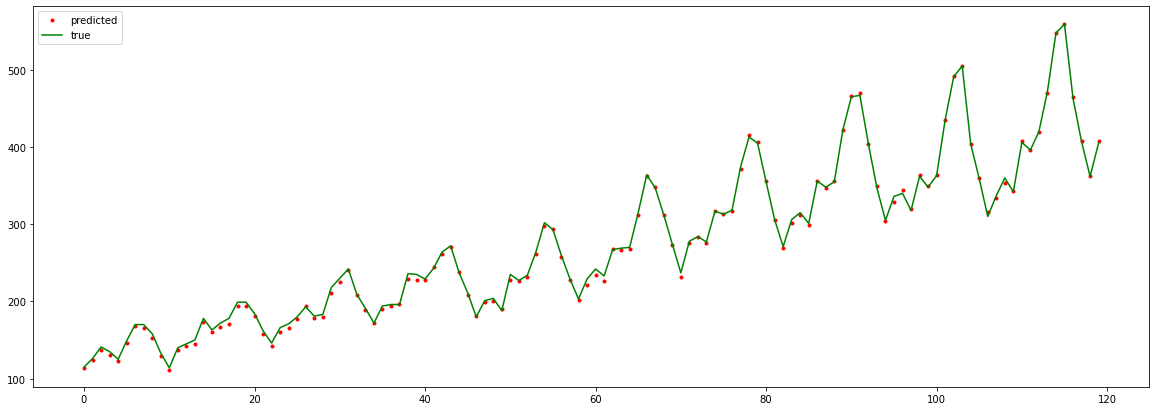

In [1050]:
plt.plot(y_train_pred, '.r', label='predicted')
plt.plot(np.array(y_train), 'g', label='true')
plt.legend();

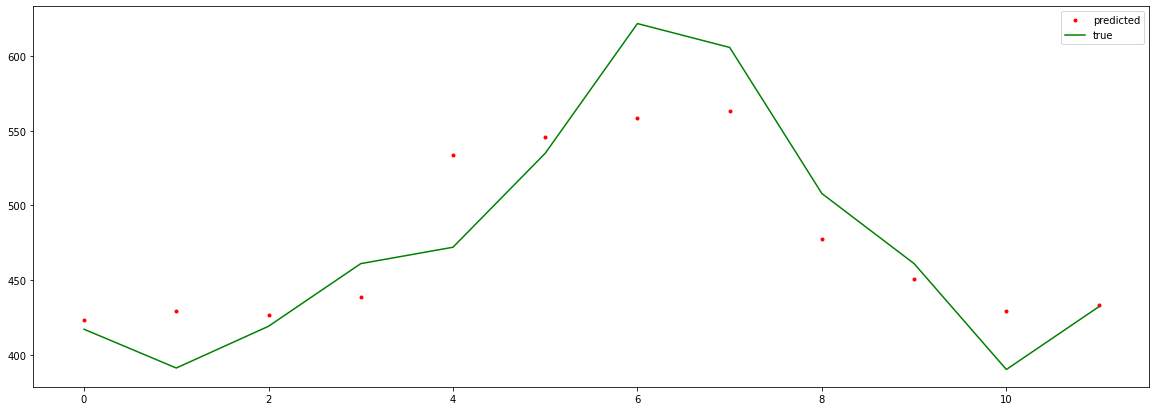

In [1051]:
plt.plot(y_test_pred, '.r', label='predicted')
plt.plot(y_test, 'g', label='true')
plt.legend();

In [1052]:
train_r2 = r2_score(y_train, y_train_pred)
train_r2

0.9990183236782398

In [1053]:
test_r2 = r2_score(y_test, y_test_pred)
test_r2

0.7841776484790294

Вывод: рекуррентные сети LSTM(128) и GRU(128) показали самый высокий результат по сравнению с полносвязной сетью по метрике r2 (LSTM 0,76, GRU 0,78 r2) при использовании входных данных в виде 12 пар предыдущих показателей [месяц, пассажиропоток], нормализации этих данных с помощью minmaxscaler и использовании 5000 эпох (недостаток - длительность обечения), активация elu. GRU при прочих равных результат чуть лучше. Также неплохо с задачей справляется бустинг. Если осуществить подбор оптимальных параметров, возможно достичь более высокого результата с помощью бустинга, плюс - он обучается очень быстро.